## CredX Case Study

CredX is a leading credit card provider that gets thousands of credit card applications every year. But in the past few years, it has experienced an increase in credit loss. The CEO believes that the best strategy to mitigate credit risk is to 'acquire the right customers'.

In this project, we need to help CredX identify the right customers using predictive models. Using past data of the bank’s applicants, we need to **determine the factors affecting credit risk, create strategies to mitigate the acquisition risk and assess the financial benefit of your project**.  

**Importing Libraries:**

In [325]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

In [326]:
import pandas as pd
import pandas_profiling
import numpy as np
import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
#mpl.rc('axes', labelsize=12)
#mpl.rc('xtick', labelsize=10)
#mpl.rc('ytick', labelsize=10)
%matplotlib inline

#import plotly.plotly as py
import chart_studio.plotly as py
import plotly.graph_objs as go
import plotly
import plotly.figure_factory as ff
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
plotly.offline.init_notebook_mode(connected=True)

import pandas.core.algorithms as algos
import scipy.stats.stats as stats
import string

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score , roc_auc_score, roc_curve
from sklearn import metrics

# maximum display
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 5000)

### Common functions used in module

In [327]:
def missing_values(data):
    total = data.isnull().sum().sort_values(ascending = False) # getting the sum of null values and ordering
    percent = (data.isnull().sum() / data.isnull().count() * 100 ).sort_values(ascending = False) #getting the percent and order of null
    df = pd.concat([total, percent], axis=1, keys=['Total', 'Percent']) # Concatenating the total and percent
    print("Total columns at least one Values: ")
    print (df[~(df['Total'] == 0)]) # Returning values of nulls different of 0
    return

In [328]:
max_bin = 20
force_bin = 3

# define a binning function
def mono_bin(Y, X, n = max_bin):
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    r = 0
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            n = n - 1 
        except Exception as e:
            n = n - 1

    if len(d2) == 1:
        n = force_bin         
        bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
        d2 = d1.groupby('Bucket', as_index=True)

    d3 = pd.DataFrame({},index=[])
    d3["Min_value"] = d2.min().X
    d3["Max_value"] = d2.max().X
    d3["N"] = d2.count().Y
    d3["Events"] = d2.sum().Y
    
    d3["Non-Events"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'Min_value':np.nan},index=[0])
        d4["Max_value"] = np.nan
        d4["N"] = justmiss.count().Y
        d4["Events"] = justmiss.sum().Y
        d4["Non-Events"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
        
    # Adjustment for WOE
    d3["Events"] = d3["Events"].apply(lambda x : np.maximum(0.5,x))
    d3["Non-Events"] = d3["Non-Events"].apply(lambda x : np.maximum(0.5,x))
    
    d3["% of Events"] = d3["Events"]/d3.sum()["Events"]
    d3["% of Non-Events"] = d3["Non-Events"]/d3.sum()["Non-Events"]
    d3["WoE"] = np.log(d3["% of Non-Events"]/d3["% of Events"])
    d3["IV"] = (d3["% of Non-Events"]-d3["% of Events"])*d3["WoE"]
    d3["Variable"] = "VAR"
    d3 = d3[['Variable','Min_value', 'Max_value', 'N', 'Events', 'Non-Events', '% of Events','% of Non-Events','WoE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    return(d3)

def char_bin(Y, X):
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]    
    df2 = notmiss.groupby('X',as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["N"] = df2.count().Y
    d3["Min_value"] = df2.sum().Y.index
    d3["Max_value"] = d3["Min_value"]
    d3["Events"] = df2.sum().Y
    d3["Non-Events"] = df2.count().Y - df2.sum().Y
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'Min_value':np.nan},index=[0])
        d4["Max_value"] = np.nan
        d4["N"] = justmiss.count().Y
        d4["Events"] = justmiss.sum().Y
        d4["Non-Events"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
        
    # Adjustment for WoE
    d3["Events"] = d3["Events"].apply(lambda x : np.maximum(0.5,x))
    d3["Non-Events"] = d3["Non-Events"].apply(lambda x : np.maximum(0.5,x))

    d3["% of Events"] = d3["Events"]/d3.sum()["Events"]
    d3["% of Non-Events"] = d3["Non-Events"]/d3.sum()["Non-Events"]
    d3["WoE"] = np.log(d3["% of Non-Events"]/d3["% of Events"])
    d3["IV"] = (d3["% of Non-Events"]-d3["% of Events"])*d3["WoE"]
    d3["Variable"] = "VAR"
    d3 = d3[['Variable','Min_value', 'Max_value', 'N', 'Events', 'Non-Events', '% of Events','% of Non-Events','WoE', 'IV']]       

    d3 = d3.replace([np.inf, -np.inf], 0)
    d3 = d3.reset_index(drop=True)
    return(d3)

def woe(df1, target, target_column_name):
    
    x = df1.dtypes.index
    count = -1

    for i in x:
        if i.upper() not in (target_column_name.upper()):
            if np.issubdtype(df1[i], np.number) and len(pd.Series.unique(df1[i])) > 2:
                conv = mono_bin(target, df1[i])
                conv["Variable"] = i
                count = count + 1
            else:
                conv = char_bin(target, df1[i])
                conv["Variable"] = i            
                count = count + 1
                
            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv,ignore_index=True)
    
    iv = pd.DataFrame({'IV':iv_df.groupby('Variable').IV.sum()})
    iv = iv.reset_index()
    return iv_df,iv


In [329]:
def apply_woe(orig_df,woe_df,transform_prefix='woe_',exclude=''):
    
    df = orig_df.copy()

    if exclude:
        transform_vars_list = df.columns.difference(exclude)
    else:
        transform_vars_list = df.columns
    
    for var in transform_vars_list:
        print("Transforming for column : {}".format(var))
        small_df = woe_df[woe_df['Variable'] == var]
        transform_dict = dict(zip(small_df["Max_value"],small_df["WoE"]))

        replace_cmd_numeric = ''
        replace_cmd_cat = ''
        
        for key in transform_dict.keys():
            if isinstance(key,float):
                if np.isnan(key):
                    woe_nan = transform_dict[key]
                    replace_cmd_numeric = replace_cmd_numeric + str(woe_nan) + str(' if pd.isna(x)') + ' else '
                    replace_cmd_cat = replace_cmd_cat + str(woe_nan) + str(' if pd.isna(x)') + ' else '
        
        for i in transform_dict.items():
            if isinstance(i[0],float):
                if np.isnan(i[0]):
                    continue
            replace_cmd_numeric = replace_cmd_numeric + str(i[1]) + str(' if x <= ') + str(i[0]) + ' else '
            replace_cmd_cat = replace_cmd_cat + str(i[1]) + str(' if x == "') + str(i[0]) + '" else '
        
        replace_cmd_numeric = replace_cmd_numeric + '0'
        replace_cmd_cat = replace_cmd_cat + '0'
    
        if replace_cmd_numeric != '0':
            try:
                df[transform_prefix + var] = df[var].apply(lambda x: eval(replace_cmd_numeric))
            except:
                df[transform_prefix + var] = df[var].apply(lambda x: eval(replace_cmd_cat))

    return df

In [330]:
def create_woe_df(df):
    woe_columns = [col for col in df.columns if 'woe' in col]
    woe_columns.insert(0,'Application_ID')
    woe_columns.append('Performance_Tag')

    woe_df = df[woe_columns]
    return woe_df

In [331]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

In [332]:
def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

In [333]:
def calculate_classification_metrics(model,X,y):
    y_pred = model.predict(X)
    confusion = confusion_matrix(y,y_pred)
    TP = confusion[1,1] # true positive 
    TN = confusion[0,0] # true negatives
    FP = confusion[0,1] # false positives
    FN = confusion[1,0] # false negatives
    print("Accuracy:{}".format(round((TP+TN)/(TP+TN+FP+FN),3)))
    print("Sensitivity:{}".format(round(TP/float(TP+FN),3)))
    print("Specificity:{}".format(round(TN/float(TN+FP),3)))
    pred_probs = model.predict_proba(X)[:,1]
    print("AUC:{:2.2f}".format(roc_auc_score(y, pred_probs)))
    from scipy.stats import ks_2samp
    pred_probs_true = [j for i,j in zip(y,pred_probs) if i==0]
    pred_probs_false = [j for i,j in zip(y,pred_probs) if i==1]
    print(ks_2samp(pred_probs_true,pred_probs_false))

In [334]:
def plot_confusion_matrix(y_test,y_pred):
    df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
    sns.set(font_scale=1.4)
    sns.heatmap(df_cm, annot=True,annot_kws={"size": 14}, fmt='g')
    plt.show()

In [335]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = roc_curve( actual, probs,drop_intermediate = False )
    auc_score = roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [336]:
def class_imbalance(X,y,target,threshold=0.4):
    from imblearn.over_sampling import SMOTE
    class_list = y.value_counts().values
    cols = X.columns
    majority_class_count = class_list.max()
    minority_class_count = class_list.min()
    
    minority_class_pct = minority_class_count/class_list.sum()
    
    if minority_class_pct < threshold:
        print("Class imbalance detected!!. Minority class %:{} , Threshold:{}".format(round(minority_class_pct,2),threshold))
    sm = SMOTE(random_state=42)
    X_res, y_res = sm.fit_resample(X, y)
    X_df = pd.DataFrame(X_res,columns=X.columns)
    y_df = pd.Series(y_res,name=target)
    return X_df,y_df

In [337]:
def plot_sensi_speci_curve(in_df,y_true,pred_prob):
    df = in_df.copy()
    numbers = [float(x)/10 for x in range(10)]
    for i in numbers:
        df[i]= df[pred_prob].map(lambda x: 1 if x > i else 0)
    cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
    from sklearn.metrics import confusion_matrix
    
    num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
    for i in num:
        cm1 = metrics.confusion_matrix(df[y_true], df[i] )
        total1=sum(sum(cm1))
        accuracy = (cm1[0,0]+cm1[1,1])/total1
        
        speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
        sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
        cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
    cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
    plt.show()

In [338]:
def calculate_application_score(df):
    odd_good = (1-df['Prob'])/df['Prob']
    slope = 20/(np.log(20)-np.log(10))
    score = 400 + slope * (np.log(odd_good) - np.log(10))
    return score

# Demographic Data :

## Data Understanding and Cleansing :

In [339]:
# Read the demographic data
demo = pd.read_csv('Demographic data.csv')
demo.head()

Application ID  Age Gender Marital Status (at the time of application)  No of dependents  Income     Education Profession  Type of residence  No of months in current residence  No of months in current company  Performance Tag
0       954457215   48      F                                     Married               2.0    40.0      Bachelor         SAL            Rented                                113                               56              0.0
1       432830445   31      M                                     Married               4.0    55.0  Professional     SE_PROF            Rented                                112                               46              0.0
2       941387308   32      M                                      Single               2.0    46.0      Bachelor     SE_PROF            Rented                                104                               49              0.0
3       392161677   43      M                                     Married               1.0    53.0      Bachelor          SE            Rented                                 94                               53              0.0
4       182011211   35      F                                     Married               5.0    44.0  Professional         SAL            Rented                                112                               43              0.0

In [340]:
demo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71295 entries, 0 to 71294
Data columns (total 12 columns):
Application ID                                 71295 non-null int64
Age                                            71295 non-null int64
Gender                                         71293 non-null object
Marital Status (at the time of application)    71289 non-null object
No of dependents                               71292 non-null float64
Income                                         71295 non-null float64
Education                                      71176 non-null object
Profession                                     71281 non-null object
Type of residence                              71287 non-null object
No of months in current residence              71295 non-null int64
No of months in current company                71295 non-null int64
Performance Tag                                69870 non-null float64
dtypes: float64(3), int64(4), object(5)
memory usage: 6.5+ MB


In [341]:
demo.describe()

Application ID           Age  No of dependents        Income  No of months in current residence  No of months in current company  Performance Tag
count    7.129500e+04  71295.000000      71292.000000  71295.000000                       71295.000000                     71295.000000     69870.000000
mean     4.989601e+08     44.943039          2.865188     27.195224                          34.563420                        33.958244         0.042193
std      2.885905e+08      9.939211          1.382319     15.514626                          36.759758                        20.410824         0.201030
min      1.004500e+05     -3.000000          1.000000     -0.500000                           6.000000                         3.000000         0.000000
25%      2.483719e+08     37.000000          2.000000     14.000000                           6.000000                        16.000000         0.000000
50%      4.975698e+08     45.000000          3.000000     27.000000                          11.000000                        34.000000         0.000000
75%      7.495868e+08     53.000000          4.000000     40.000000                          60.000000                        51.000000         0.000000
max      1.000084e+09     65.000000          5.000000     60.000000                         126.000000                       133.000000         1.000000

In [342]:
demo.shape

(71295, 12)

In [343]:
# Data understnading using pandas profiling
columns = demo.columns # taking a backup of columns as pandas profiling alters column names
pandas_profiling.ProfileReport(demo)

In [344]:
demo.columns = columns # reinstate the columns after pandas profiling

In [345]:
# Percentage of missing data
round(demo.isnull().sum()/len(demo.index)*100,3)

Application ID                                 0.000
Age                                            0.000
Gender                                         0.003
Marital Status (at the time of application)    0.008
No of dependents                               0.004
Income                                         0.000
Education                                      0.167
Profession                                     0.020
Type of residence                              0.011
No of months in current residence              0.000
No of months in current company                0.000
Performance Tag                                1.999
dtype: float64

In [346]:
demo.drop_duplicates(inplace=True)

In [347]:
missing_values(demo)

Total columns at least one Values: 
                                             Total   Percent
Performance Tag                               1425  1.998738
Education                                      119  0.166912
Profession                                      14  0.019637
Type of residence                                8  0.011221
Marital Status (at the time of application)      6  0.008416
No of dependents                                 3  0.004208
Gender                                           2  0.002805


Performance Tag has around 1425 missing values, which are the rejected candidates. We will keep it separate for later analysis and remove those rows from the dataset.

In [348]:
# Checking value counts for each column to see different values present
omit_columns = ['Application ID','Age','Income','No of months in current residence','No of months in current company']
for c in demo.columns:
    if c not in omit_columns:
        print (demo[c].value_counts())

M    54456
F    16837
Name: Gender, dtype: int64
Married    60730
Single     10559
Name: Marital Status (at the time of application), dtype: int64
3.0    16279
1.0    15387
2.0    15289
4.0    12222
5.0    12115
Name: No of dependents, dtype: int64
Professional    24839
Masters         23970
Bachelor        17697
Phd              4549
Others            121
Name: Education, dtype: int64
SAL        40439
SE_PROF    16535
SE         14307
Name: Profession , dtype: int64
Rented                 53397
Owned                  14243
Living with Parents     1818
Company provided        1630
Others                   199
Name: Type of residence, dtype: int64
0.0    66922
1.0     2948
Name: Performance Tag, dtype: int64


Few Column names contains spaces at the end, e.g - Profession. We need to modify the column names.

In [349]:
demo.columns = demo.columns.str.strip().str.replace(' ','_').str.replace('(','').str.replace(')','')

In [350]:
demo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71295 entries, 0 to 71294
Data columns (total 12 columns):
Application_ID                               71295 non-null int64
Age                                          71295 non-null int64
Gender                                       71293 non-null object
Marital_Status_at_the_time_of_application    71289 non-null object
No_of_dependents                             71292 non-null float64
Income                                       71295 non-null float64
Education                                    71176 non-null object
Profession                                   71281 non-null object
Type_of_residence                            71287 non-null object
No_of_months_in_current_residence            71295 non-null int64
No_of_months_in_current_company              71295 non-null int64
Performance_Tag                              69870 non-null float64
dtypes: float64(3), int64(4), object(5)
memory usage: 7.1+ MB


In [351]:
# Check for number of unique values
demo.nunique()

Application_ID                               71292
Age                                             53
Gender                                           2
Marital_Status_at_the_time_of_application        2
No_of_dependents                                 5
Income                                          63
Education                                        5
Profession                                       3
Type_of_residence                                5
No_of_months_in_current_residence              121
No_of_months_in_current_company                 83
Performance_Tag                                  2
dtype: int64

In [352]:
# Check duplicates on Application_ID
demo["Application_ID"].duplicated().sum()

3

In [353]:
demo[demo['Application_ID'].duplicated(keep=False)]

Application_ID  Age Gender Marital_Status_at_the_time_of_application  No_of_dependents  Income     Education Profession    Type_of_residence  No_of_months_in_current_residence  No_of_months_in_current_company  Performance_Tag
5243        653287861   26      M                                   Married               3.0    25.0      Bachelor        SAL               Rented                                112                               58              0.0
24386       765011468   57      M                                    Single               4.0     4.5      Bachelor        SAL     Company provided                                  6                               56              0.0
27586       765011468   38      M                                   Married               4.0     4.5  Professional        SAL               Rented                                  6                               72              0.0
42637       653287861   40      M                                   Married               5.0    32.0           Phd         SE               Rented                                 45                               46              1.0
48602       671989187   27      M                                   Married               2.0    35.0  Professional        SAL  Living with Parents                                108                                7              0.0
59022       671989187   57      M                                   Married               4.0     7.0  Professional         SE               Rented                                 42                                3              0.0

We have 3 rows with duplicated Application_ID but different data

In [354]:
# Deleting first occurrence rows with duplicated application id
demo.drop_duplicates(subset=['Application_ID'], keep='last', inplace=True)

In [355]:
demo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71292 entries, 0 to 71294
Data columns (total 12 columns):
Application_ID                               71292 non-null int64
Age                                          71292 non-null int64
Gender                                       71290 non-null object
Marital_Status_at_the_time_of_application    71286 non-null object
No_of_dependents                             71289 non-null float64
Income                                       71292 non-null float64
Education                                    71173 non-null object
Profession                                   71278 non-null object
Type_of_residence                            71284 non-null object
No_of_months_in_current_residence            71292 non-null int64
No_of_months_in_current_company              71292 non-null int64
Performance_Tag                              69867 non-null float64
dtypes: float64(3), int64(4), object(5)
memory usage: 7.1+ MB


In [356]:
# Checking invalid values in Age column
demo.Age.describe()

count    71292.000000
mean        44.943388
std          9.938837
min         -3.000000
25%         37.000000
50%         45.000000
75%         53.000000
max         65.000000
Name: Age, dtype: float64

In [357]:
demo[demo['Age'] < 18].shape

(65, 12)

In [358]:
# Removing the entries with age less than 18
demo = demo[demo.Age >= 18]

In [359]:
demo.shape

(71227, 12)

In [360]:
demo.Income.describe()

count    71227.000000
mean        27.193782
std         15.517273
min         -0.500000
25%         14.000000
50%         27.000000
75%         40.000000
max         60.000000
Name: Income, dtype: float64

Income can't be negatve. We will remove the rows having income as negative.

In [361]:
demo[demo['Income']<0]

Application_ID  Age Gender Marital_Status_at_the_time_of_application  No_of_dependents  Income     Education Profession    Type_of_residence  No_of_months_in_current_residence  No_of_months_in_current_company  Performance_Tag
964        450723469   34      M                                   Married               2.0    -0.5       Masters        SAL               Rented                                 99                               57              0.0
1058        24806681   22      M                                    Single               1.0    -0.5       Masters        SAL               Rented                                 93                               57              0.0
1222       729552057   40      M                                   Married               3.0    -0.5  Professional    SE_PROF               Rented                                113                               43              0.0
1278       805216817   32      M                                   Married               3.0    -0.5  Professional        SAL                Owned                                109                               51              0.0
1288       547253197   64      M                                   Married               5.0    -0.5  Professional        SAL               Rented                                108                               52              0.0
1343       373963488   48      M                                   Married               3.0    -0.5  Professional        SAL               Rented                                113                               57              0.0
1463        60246058   35      M                                   Married               3.0    -0.5  Professional        SAL                Owned                                111                               53              0.0
1565       861750337   52      M                                   Married               5.0    -0.5      Bachelor        SAL                Owned                                 89                               53              1.0
1620       342846642   51      M                                   Married               3.0    -0.5      Bachelor         SE               Rented                                112                               58              0.0
1731       671827529   41      M                                   Married               2.0    -0.5       Masters        SAL                Owned                                114                               33              0.0
1864       856382859   34      M                                    Single               1.0    -0.5  Professional         SE               Rented                                 74                               57              0.0
1906        28529247   44      M                                   Married               5.0    -0.5       Masters    SE_PROF                Owned                                104                               37              0.0
2001       376543424   35      M                                   Married               5.0    -0.5  Professional    SE_PROF               Rented                                103                               57              0.0
2036       894546185   64      M                                   Married               1.0    -0.5       Masters         SE               Rented                                108                               23              0.0
2043       281925114   32      M                                   Married               1.0    -0.5  Professional        SAL               Rented                                108                               45              0.0
2092       442521933   59      F                                   Married               5.0    -0.5       Masters    SE_PROF                Owned                                 99                               36              0.0
2126        72233026   65      M                              

In [362]:
demo[demo["Income"] < 0]['Performance_Tag'].value_counts()

0.0    78
1.0     2
Name: Performance_Tag, dtype: int64

In [363]:
demo = demo[demo["Income"] >= 0]
demo.shape

(71147, 12)

**Handling missing values**

We will be creating two separate dataframes one with the original features where we will handle the missing values either by imputing or removing them, and another dataframe where we will be doing WOE and it will take care of the missing values.

In [364]:
missing_values(demo)

Total columns at least one Values: 
                                           Total   Percent
Performance_Tag                             1425  2.002895
Education                                    119  0.167259
Profession                                    13  0.018272
Type_of_residence                              8  0.011244
Marital_Status_at_the_time_of_application      5  0.007028
No_of_dependents                               2  0.002811
Gender                                         1  0.001406


In [365]:
# Storing the rejected candidates in a separate dataframe for later analysis
rejected_demo = demo[demo["Performance_Tag"].isna()]
rejected_demo.head()

Application_ID  Age Gender Marital_Status_at_the_time_of_application  No_of_dependents  Income     Education Profession Type_of_residence  No_of_months_in_current_residence  No_of_months_in_current_company  Performance_Tag
69603       906908303   35      M                                    Single               1.0     6.0      Bachelor        SAL            Rented                                 22                               18              NaN
69604        10990583   47      F                                   Married               4.0    12.0       Masters         SE            Rented                                122                               25              NaN
69605       589678446   46      M                                   Married               3.0     7.0  Professional         SE            Rented                                 10                               31              NaN
69606       809411322   41      M                                   Married               3.0    18.0       Masters        SAL            Rented                                  6                               47              NaN
69607       150246616   42      F                                   Married               4.0    17.0           Phd        SAL            Rented                                  8                               49              NaN

In [366]:
# Removing the entries with performance_tag as null from the dataset
demo = demo[~demo['Performance_Tag'].isna()]

In [367]:
missing_values(demo)

Total columns at least one Values: 
                                           Total   Percent
Education                                    118  0.169244
Profession                                    12  0.017211
Type_of_residence                              8  0.011474
Marital_Status_at_the_time_of_application      5  0.007171
No_of_dependents                               2  0.002869
Gender                                         1  0.001434


In [368]:
demo['Gender'].value_counts()

M    53250
F    16471
Name: Gender, dtype: int64

In [369]:
# Replacing na values in Gender with Male
demo["Gender"].fillna("M", inplace = True) 

In [370]:
missing_values(demo)

Total columns at least one Values: 
                                           Total   Percent
Education                                    118  0.169244
Profession                                    12  0.017211
Type_of_residence                              8  0.011474
Marital_Status_at_the_time_of_application      5  0.007171
No_of_dependents                               2  0.002869


In [371]:
demo['Education'].value_counts()

Professional    24321
Masters         23439
Bachelor        17271
Phd              4455
Others            118
Name: Education, dtype: int64

In [372]:
# Replacing na values in Education with Others
demo["Education"].fillna("Others", inplace = True)

In [373]:
demo['Type_of_residence'].value_counts()

Rented                 52192
Owned                  13962
Living with Parents     1763
Company provided        1599
Others                   198
Name: Type_of_residence, dtype: int64

In [374]:
## Replacing na values in Type_of_residence with Others
demo["Type_of_residence"].fillna("Others", inplace = True) 

In [375]:
demo['Marital_Status_at_the_time_of_application'].value_counts()

Married    59433
Single     10284
Name: Marital_Status_at_the_time_of_application, dtype: int64

In [376]:
demo['No_of_dependents'].value_counts()

3.0    15607
1.0    15182
2.0    15088
4.0    11983
5.0    11860
Name: No_of_dependents, dtype: int64

In [377]:
# Creating a copy of the dataframe on which we will perform the woe transformation
demo_woe = demo.copy()

In [378]:
## Replacing na values in Marital Status with Married
demo["Marital_Status_at_the_time_of_application"].fillna("Married", inplace = True)

In [379]:
demo.dropna(subset = ['No_of_dependents','Profession'],inplace=True)

In [380]:
demo.isnull().sum()

Application_ID                               0
Age                                          0
Gender                                       0
Marital_Status_at_the_time_of_application    0
No_of_dependents                             0
Income                                       0
Education                                    0
Profession                                   0
Type_of_residence                            0
No_of_months_in_current_residence            0
No_of_months_in_current_company              0
Performance_Tag                              0
dtype: int64

In [381]:
demo_woe.isnull().sum()

Application_ID                                0
Age                                           0
Gender                                        0
Marital_Status_at_the_time_of_application     5
No_of_dependents                              2
Income                                        0
Education                                     0
Profession                                   12
Type_of_residence                             0
No_of_months_in_current_residence             0
No_of_months_in_current_company               0
Performance_Tag                               0
dtype: int64

In [382]:
demo_woe[demo_woe["Marital_Status_at_the_time_of_application"].isna()]['Performance_Tag'].value_counts()

0.0    5
Name: Performance_Tag, dtype: int64

In [383]:
demo_woe[demo_woe["No_of_dependents"].isna()]['Performance_Tag'].value_counts()

0.0    2
Name: Performance_Tag, dtype: int64

In [384]:
demo_woe[demo_woe["Profession"].isna()]['Performance_Tag'].value_counts()

0.0    12
Name: Performance_Tag, dtype: int64

### Creation of WOE Dataset :

In [385]:
demo_woe.head()

Application_ID  Age Gender Marital_Status_at_the_time_of_application  No_of_dependents  Income     Education Profession Type_of_residence  No_of_months_in_current_residence  No_of_months_in_current_company  Performance_Tag
0       954457215   48      F                                   Married               2.0    40.0      Bachelor        SAL            Rented                                113                               56              0.0
1       432830445   31      M                                   Married               4.0    55.0  Professional    SE_PROF            Rented                                112                               46              0.0
2       941387308   32      M                                    Single               2.0    46.0      Bachelor    SE_PROF            Rented                                104                               49              0.0
3       392161677   43      M                                   Married               1.0    53.0      Bachelor         SE            Rented                                 94                               53              0.0
4       182011211   35      F                                   Married               5.0    44.0  Professional        SAL            Rented                                112                               43              0.0

In [386]:
demo_woe.shape

(69722, 12)

In [387]:
demo_woe_bak = demo_woe.copy()

In [388]:
demo_woe_details, demo_iv = woe(demo_woe.loc[:,'Age':], demo_woe['Performance_Tag'],'Performance_Tag')

In [389]:
demo_iv.sort_values('IV',ascending=False)

Variable        IV
7          No_of_months_in_current_residence  0.052673
3                                     Income  0.038089
6            No_of_months_in_current_company  0.010894
8                                 Profession  0.002228
9                          Type_of_residence  0.001069
0                                        Age  0.000704
1                                  Education  0.000522
2                                     Gender  0.000342
5                           No_of_dependents  0.000312
4  Marital_Status_at_the_time_of_application  0.000169

In [390]:
demo_woe_details.head(10)

Variable Min_value Max_value      N  Events  Non-Events  % of Events  % of Non-Events       WoE        IV
0                                        Age        18        40  24533  1070.0     23463.0     0.363328         0.351363 -0.033484  0.000401
1                                        Age        41        50  22846   958.0     21888.0     0.325297         0.327778  0.007596  0.000019
2                                        Age        51        65  22343   917.0     21426.0     0.311375         0.320859  0.030003  0.000285
3                                     Gender         F         F  16471   718.0     15753.0     0.243803         0.235905 -0.032933  0.000260
4                                     Gender         M         M  53251  2227.0     51024.0     0.756197         0.764095  0.010391  0.000082
5  Marital_Status_at_the_time_of_application   Married   Married  59433  2501.0     56932.0     0.849092         0.852569  0.004087  0.000014
6  Marital_Status_at_the_time_of_application    Single    Single  10284   444.0      9840.0     0.150738         0.147356 -0.022694  0.000077
7  Marital_Status_at_the_time_of_application       NaN       NaN      5     0.5         5.0     0.000170         0.000075 -0.818495  0.000078
8                           No_of_dependents         1         3  45877  1949.0     43928.0     0.661687         0.657831 -0.005845  0.000023
9                           No_of_dependents         4         5  23843   996.0     22847.0     0.338143         0.342139  0.011748  0.000047

In [391]:
demo_woe[(demo_woe["Age"] >= 18) & (demo_woe["Age"] <= 40)].groupby(['Performance_Tag']).size()

Performance_Tag
0.0    23463
1.0     1070
dtype: int64

In [392]:
data = [go.Bar(
            x=demo_woe_details['Variable'],
            y=demo_woe_details['WoE'],
            text=demo_woe_details['Variable'],
            marker=dict(
            color='rgb(158,20,25)',
            line=dict(
            color='rgb(8,48,107)',
            width=1.5,
        )
    ),
    opacity=0.6
    )]


layout = go.Layout(
    title='Weight of Evidence(WOE)',
        xaxis=dict(
        title='Features',
            tickangle=-45,
        tickfont=dict(
            size=10,
            color='rgb(107, 107, 107)'
        )
    ),
    yaxis=dict(
        title='Weight of Evidence(WOE)',
        titlefont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        ),
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
    ),
)

plotly.offline.iplot({
    "data": data,'layout':layout
})

In [393]:
data = [go.Bar(
            x=demo_iv['Variable'],
            y=demo_iv['IV'],
            text=demo_iv['Variable'],
            marker=dict(
            color='rgb(58,256,225)',
            line=dict(
            color='rgb(8,48,107)',
            width=1.5,
        )
    ),
    opacity=0.6
    )]


layout = go.Layout(
    title='Information Values',
        xaxis=dict(
        tickangle=-45,
        title='Features',
        tickfont=dict(
            size=10,
            color='rgb(7, 7, 7)'
        )
    ),
    yaxis=dict(
        title='Information Value(IV)',
        titlefont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        ),
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
    ),
)

plotly.offline.iplot({
    "data": data,'layout':layout
})

In [394]:
# df = demo_woe.loc[:,'Age':]
# transform_vars_list = df.columns.difference(['Performance_Tag'])
# transform_prefix = 'woe_'
# transform_vars_list

In [395]:
woe_transformed_df = apply_woe(demo_woe,demo_woe_details,transform_prefix='woe_',exclude=['Application_ID','Performance_Tag'])

Transforming for column : Age
Transforming for column : Education
Transforming for column : Gender
Transforming for column : Income
Transforming for column : Marital_Status_at_the_time_of_application
Transforming for column : No_of_dependents
Transforming for column : No_of_months_in_current_company
Transforming for column : No_of_months_in_current_residence
Transforming for column : Profession
Transforming for column : Type_of_residence


In [396]:
woe_transformed_df.head()

Application_ID  Age Gender Marital_Status_at_the_time_of_application  No_of_dependents  Income     Education Profession Type_of_residence  No_of_months_in_current_residence  No_of_months_in_current_company  Performance_Tag   woe_Age  woe_Education  woe_Gender  woe_Income  woe_Marital_Status_at_the_time_of_application  woe_No_of_dependents  woe_No_of_months_in_current_company  woe_No_of_months_in_current_residence  woe_Profession  woe_Type_of_residence
0       954457215   48      F                                   Married               2.0    40.0      Bachelor        SAL            Rented                                113                               56              0.0  0.007596      -0.014907   -0.032933    0.245612                                       0.004087             -0.005845                             0.123411                               -0.20823        0.028074               0.004056
1       432830445   31      M                                   Married               4.0    55.0  Professional    SE_PROF            Rented                                112                               46              0.0 -0.033484       0.017725    0.010391    0.263833                                       0.004087              0.011748                             0.072353                               -0.20823        0.014157               0.004056
2       941387308   32      M                                    Single               2.0    46.0      Bachelor    SE_PROF            Rented                                104                               49              0.0 -0.033484      -0.014907    0.010391    0.263833                                      -0.022694             -0.005845                             0.072353                               -0.20823        0.014157               0.004056
3       392161677   43      M                                   Married               1.0    53.0      Bachelor         SE            Rented                                 94                               53              0.0  0.007596      -0.014907    0.010391    0.263833                                       0.004087             -0.005845                             0.123411                               -0.20823       -0.091452               0.004056
4       182011211   35      F                                   Married               5.0    44.0  Professional        SAL            Rented                                112                               43              0.0 -0.033484       0.017725   -0.032933    0.245612                                       0.004087              0.011748                             0.072353                               -0.20823        0.028074               0.004056

In [397]:
demo_woe_data = create_woe_df(woe_transformed_df)
demo_woe_data.head()

Application_ID   woe_Age  woe_Education  woe_Gender  woe_Income  woe_Marital_Status_at_the_time_of_application  woe_No_of_dependents  woe_No_of_months_in_current_company  woe_No_of_months_in_current_residence  woe_Profession  woe_Type_of_residence  Performance_Tag
0       954457215  0.007596      -0.014907   -0.032933    0.245612                                       0.004087             -0.005845                             0.123411                               -0.20823        0.028074               0.004056              0.0
1       432830445 -0.033484       0.017725    0.010391    0.263833                                       0.004087              0.011748                             0.072353                               -0.20823        0.014157               0.004056              0.0
2       941387308 -0.033484      -0.014907    0.010391    0.263833                                      -0.022694             -0.005845                             0.072353                               -0.20823        0.014157               0.004056              0.0
3       392161677  0.007596      -0.014907    0.010391    0.263833                                       0.004087             -0.005845                             0.123411                               -0.20823       -0.091452               0.004056              0.0
4       182011211 -0.033484       0.017725   -0.032933    0.245612                                       0.004087              0.011748                             0.072353                               -0.20823        0.028074               0.004056              0.0

In [398]:
demo_woe_data.isnull().sum()

Application_ID                                   0
woe_Age                                          0
woe_Education                                    0
woe_Gender                                       0
woe_Income                                       0
woe_Marital_Status_at_the_time_of_application    0
woe_No_of_dependents                             0
woe_No_of_months_in_current_company              0
woe_No_of_months_in_current_residence            0
woe_Profession                                   0
woe_Type_of_residence                            0
Performance_Tag                                  0
dtype: int64

In [399]:
demo_woe_data.describe()

Application_ID       woe_Age  woe_Education    woe_Gender    woe_Income  woe_Marital_Status_at_the_time_of_application  woe_No_of_dependents  woe_No_of_months_in_current_company  woe_No_of_months_in_current_residence  woe_Profession  woe_Type_of_residence  Performance_Tag
count    6.972200e+04  69722.000000   69722.000000  69722.000000  69722.000000                                   69722.000000          69722.000000                         69722.000000                           69722.000000    69722.000000           69722.000000     69722.000000
mean     4.992262e+08      0.000322       0.000232      0.000156      0.017406                                       0.000078              0.000122                             0.004955                               0.024312        0.001007               0.000523         0.042239
std      2.885673e+08      0.026491       0.022060      0.018403      0.194562                                       0.011758              0.012489                             0.103495                               0.231147        0.046491               0.035713         0.201136
min      1.004500e+05     -0.033484      -0.279027     -0.032933     -0.291434                                      -0.818495             -1.734786                            -0.149871                              -0.208230       -0.091452              -0.081304         0.000000
25%      2.485152e+08     -0.033484      -0.014907      0.010391     -0.056256                                       0.004087             -0.005845                            -0.149871                              -0.208230        0.014157               0.004056         0.000000
50%      4.980596e+08      0.007596      -0.008358      0.010391     -0.054476                                       0.004087             -0.005845                            -0.021448                               0.254070        0.028074               0.004056         0.000000
75%      7.498645e+08      0.030003       0.017725      0.010391      0.245612                                       0.004087              0.011748                             0.072353                               0.254070        0.028074               0.004056         0.000000
max      1.000084e+09      0.030003       0.023418      0.010391      0.263833                                       0.004087              0.011748                             0.123411                               0.254070        0.056974               0.572617         1.000000

In [400]:
demo_woe_data.shape

(69722, 12)

In [401]:
demo_woe_data['Performance_Tag'].value_counts()

0.0    66777
1.0     2945
Name: Performance_Tag, dtype: int64

In [402]:
# sns.heatmap(demo_woe_data.loc[:,'woe_Age':'woe_Type of residence', annot=True,annot_kws={"size": 14}, fmt='g')
# plt.show()

In [403]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop
def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(demo_woe_data, 10))

Top Absolute Correlations
woe_Age                                        woe_Marital_Status_at_the_time_of_application    0.183681
woe_Income                                     woe_No_of_months_in_current_residence            0.130791
woe_Age                                        woe_No_of_dependents                             0.108986
woe_Income                                     woe_No_of_months_in_current_company              0.077198
woe_Age                                        woe_Income                                       0.076618
woe_No_of_months_in_current_company            woe_No_of_months_in_current_residence            0.073717
woe_Age                                        woe_Type_of_residence                            0.069482
                                               woe_No_of_months_in_current_residence            0.055586
woe_No_of_months_in_current_residence          Performance_Tag                                  0.045834
woe_Marital_Status_at_the_tim

### Data preparation for Actual Data :

In [404]:
demo.head()

Application_ID  Age Gender Marital_Status_at_the_time_of_application  No_of_dependents  Income     Education Profession Type_of_residence  No_of_months_in_current_residence  No_of_months_in_current_company  Performance_Tag
0       954457215   48      F                                   Married               2.0    40.0      Bachelor        SAL            Rented                                113                               56              0.0
1       432830445   31      M                                   Married               4.0    55.0  Professional    SE_PROF            Rented                                112                               46              0.0
2       941387308   32      M                                    Single               2.0    46.0      Bachelor    SE_PROF            Rented                                104                               49              0.0
3       392161677   43      M                                   Married               1.0    53.0      Bachelor         SE            Rented                                 94                               53              0.0
4       182011211   35      F                                   Married               5.0    44.0  Professional        SAL            Rented                                112                               43              0.0

In [405]:
demo.isnull().sum()

Application_ID                               0
Age                                          0
Gender                                       0
Marital_Status_at_the_time_of_application    0
No_of_dependents                             0
Income                                       0
Education                                    0
Profession                                   0
Type_of_residence                            0
No_of_months_in_current_residence            0
No_of_months_in_current_company              0
Performance_Tag                              0
dtype: int64

In [406]:
demo_numeric = demo.select_dtypes(exclude=['object'])

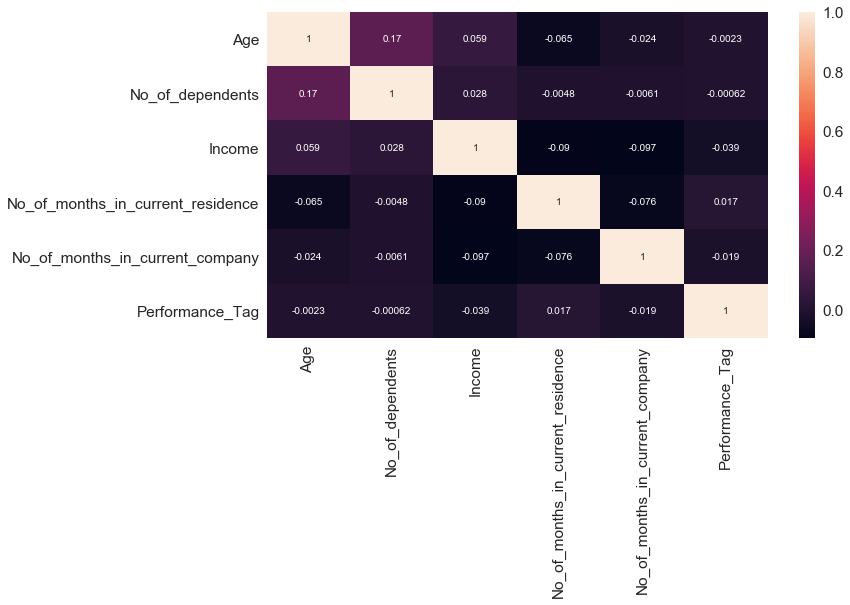

In [407]:
plt.figure(figsize=(10,6))
sns.heatmap(demo_numeric.drop('Application_ID',axis=1).corr(), annot=True)
plt.show()

In [408]:
demo_cat = demo.select_dtypes(include=['object'])

In [409]:
demo_cat.head()

Gender Marital_Status_at_the_time_of_application     Education Profession Type_of_residence
0      F                                   Married      Bachelor        SAL            Rented
1      M                                   Married  Professional    SE_PROF            Rented
2      M                                    Single      Bachelor    SE_PROF            Rented
3      M                                   Married      Bachelor         SE            Rented
4      F                                   Married  Professional        SAL            Rented

In [410]:
demo_cat_final = pd.get_dummies(demo_cat,drop_first=True)
demo_cat_final.head()

Gender_M  Marital_Status_at_the_time_of_application_Single  Education_Masters  Education_Others  Education_Phd  Education_Professional  Profession_SE  Profession_SE_PROF  Type_of_residence_Living with Parents  Type_of_residence_Others  Type_of_residence_Owned  Type_of_residence_Rented
0         0                                                 0                  0                 0              0                       0              0                   0                                      0                         0                        0                         1
1         1                                                 0                  0                 0              0                       1              0                   1                                      0                         0                        0                         1
2         1                                                 1                  0                 0              0                       0              0                   1                                      0                         0                        0                         1
3         1                                                 0                  0                 0              0                       0              1                   0                                      0                         0                        0                         1
4         0                                                 0                  0                 0              0                       1              0                   0                                      0                         0                        0                         1

In [411]:
demo_numeric.shape

(69708, 7)

In [412]:
demo_cat_final.shape

(69708, 12)

In [413]:
demo_final = pd.concat([demo_numeric,demo_cat_final],axis=1)
demo_final.head()

Application_ID  Age  No_of_dependents  Income  No_of_months_in_current_residence  No_of_months_in_current_company  Performance_Tag  Gender_M  Marital_Status_at_the_time_of_application_Single  Education_Masters  Education_Others  Education_Phd  Education_Professional  Profession_SE  Profession_SE_PROF  Type_of_residence_Living with Parents  Type_of_residence_Others  Type_of_residence_Owned  Type_of_residence_Rented
0       954457215   48               2.0    40.0                                113                               56              0.0         0                                                 0                  0                 0              0                       0              0                   0                                      0                         0                        0                         1
1       432830445   31               4.0    55.0                                112                               46              0.0         1                                                 0                  0                 0              0                       1              0                   1                                      0                         0                        0                         1
2       941387308   32               2.0    46.0                                104                               49              0.0         1                                                 1                  0                 0              0                       0              0                   1                                      0                         0                        0                         1
3       392161677   43               1.0    53.0                                 94                               53              0.0         1                                                 0                  0                 0              0                       0              1                   0                                      0                         0                        0                         1
4       182011211   35               5.0    44.0                                112                               43              0.0         0                                                 0                  0                 0              0                       1              0                   0                                      0                         0                        0                         1

In [414]:
demo_final.isnull().sum()

Application_ID                                      0
Age                                                 0
No_of_dependents                                    0
Income                                              0
No_of_months_in_current_residence                   0
No_of_months_in_current_company                     0
Performance_Tag                                     0
Gender_M                                            0
Marital_Status_at_the_time_of_application_Single    0
Education_Masters                                   0
Education_Others                                    0
Education_Phd                                       0
Education_Professional                              0
Profession_SE                                       0
Profession_SE_PROF                                  0
Type_of_residence_Living with Parents               0
Type_of_residence_Others                            0
Type_of_residence_Owned                             0
Type_of_residence_Rented    

### Model Building on Actual Data:

In [415]:
demo_final['Performance_Tag'].value_counts()

0.0    66763
1.0     2945
Name: Performance_Tag, dtype: int64

In [416]:
X = demo_final.drop(['Application_ID','Performance_Tag'],axis=1)
y = demo_final['Performance_Tag']

In [417]:
X.head()

Age  No_of_dependents  Income  No_of_months_in_current_residence  No_of_months_in_current_company  Gender_M  Marital_Status_at_the_time_of_application_Single  Education_Masters  Education_Others  Education_Phd  Education_Professional  Profession_SE  Profession_SE_PROF  Type_of_residence_Living with Parents  Type_of_residence_Others  Type_of_residence_Owned  Type_of_residence_Rented
0   48               2.0    40.0                                113                               56         0                                                 0                  0                 0              0                       0              0                   0                                      0                         0                        0                         1
1   31               4.0    55.0                                112                               46         1                                                 0                  0                 0              0                       1              0                   1                                      0                         0                        0                         1
2   32               2.0    46.0                                104                               49         1                                                 1                  0                 0              0                       0              0                   1                                      0                         0                        0                         1
3   43               1.0    53.0                                 94                               53         1                                                 0                  0                 0              0                       0              1                   0                                      0                         0                        0                         1
4   35               5.0    44.0                                112                               43         0                                                 0                  0                 0              0                       1              0                   0                                      0                         0                        0                         1

In [418]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.7,test_size=0.3,random_state=142,stratify=y)

In [419]:
print(X_train.shape)
print(X_test.shape)

(48795, 17)
(20913, 17)


In [420]:
y_train.value_counts()

0.0    46734
1.0     2061
Name: Performance_Tag, dtype: int64

**Logistic Regression :**

In [421]:
logistic = LogisticRegression(class_weight='balanced')

# create pipeline
steps = [("scaler", StandardScaler()),
         ("logistic", logistic)
        ]

pipeline_logistic = Pipeline(steps)
pipeline_logistic.fit(X_train,y_train)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logistic', LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False))])

In [422]:
pipeline_logistic.score(X_train,y_train)

0.5457731324930833

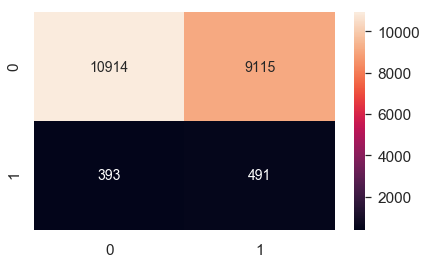

In [423]:
y_pred = pipeline_logistic.predict(X_test)
plot_confusion_matrix(y_test,y_pred)

In [424]:
calculate_classification_metrics(pipeline_logistic,X_test,y_test)

Accuracy:0.545
Sensitivity:0.555
Specificity:0.545
AUC:0.56
Ks_2sampResult(statistic=0.10449169970511085, pvalue=1.5971878714566242e-08)


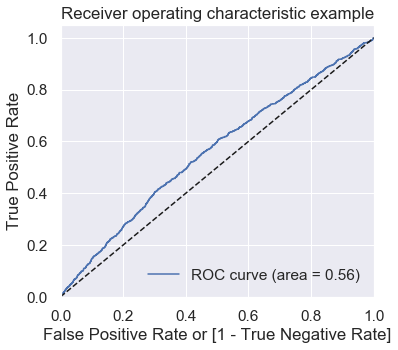

In [425]:
pred_probs_test = pipeline_logistic.predict_proba(X_test)[:,1]
draw_roc(y_test, pred_probs_test)

In [426]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.97      0.54      0.70     20029
         1.0       0.05      0.56      0.09       884

   micro avg       0.55      0.55      0.55     20913
   macro avg       0.51      0.55      0.40     20913
weighted avg       0.93      0.55      0.67     20913



**Hyperparameter Tuning**

In [427]:
# logistic regression - the class weight is used to handle class imbalance - it adjusts the cost function
logistic = LogisticRegression(class_weight='balanced')

# create pipeline
steps = [("scaler", StandardScaler()),
         ("logistic", logistic)
        ]

pipeline_logistic = Pipeline(steps)

# hyperparameter space
params = {'logistic__C': [0.005,0.008,0.01,0.03,0.05,0.1, 0.5, 1], 'logistic__penalty': ['l1', 'l2']}

# create 5 folds
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 4)

# create gridsearch object
model = GridSearchCV(estimator=pipeline_logistic, cv=folds, param_grid=params, scoring='roc_auc', n_jobs=-1, verbose=1)

In [428]:
model.fit(X_train,y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   14.3s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=4, shuffle=True),
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logistic', LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'logistic__C': [0.005, 0.008, 0.01, 0.03, 0.05, 0.1, 0.5, 1], 'logistic__penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [429]:
# print best hyperparameters
print("Best AUC: ", model.best_score_)
print("Best hyperparameters: ", model.best_params_)

Best AUC:  0.5626468842020073
Best hyperparameters:  {'logistic__C': 0.005, 'logistic__penalty': 'l1'}


In [430]:
calculate_classification_metrics(model,X_test,y_test)

Accuracy:0.514
Sensitivity:0.592
Specificity:0.511
AUC:0.57
Ks_2sampResult(statistic=0.11458729864321171, pvalue=3.6562205892746335e-10)


In [431]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.97      0.54      0.70     20029
         1.0       0.05      0.56      0.09       884

   micro avg       0.55      0.55      0.55     20913
   macro avg       0.51      0.55      0.40     20913
weighted avg       0.93      0.55      0.67     20913



**RandomForestClassifier :**

In [432]:
# # Importing random forest classifier from sklearn library
from sklearn.ensemble import RandomForestClassifier

# # Running the random forest with default parameters.
rfc = RandomForestClassifier(class_weight='balanced',max_depth=2)

# create pipeline
steps = [("scaler", StandardScaler()),
         ("random_forest", rfc)
        ]

pipeline_rfc = Pipeline(steps)

pipeline_rfc.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('random_forest', RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=2, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_i...tors=10, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False))])

In [433]:
calculate_classification_metrics(pipeline_rfc,X_train,y_train)

Accuracy:0.503
Sensitivity:0.645
Specificity:0.497
AUC:0.60
Ks_2sampResult(statistic=0.17815573524638095, pvalue=3.81693534353256e-55)


In [434]:
calculate_classification_metrics(pipeline_rfc,X_test,y_test)

Accuracy:0.507
Sensitivity:0.64
Specificity:0.501
AUC:0.59
Ks_2sampResult(statistic=0.1539662286065296, pvalue=5.246445901143686e-18)


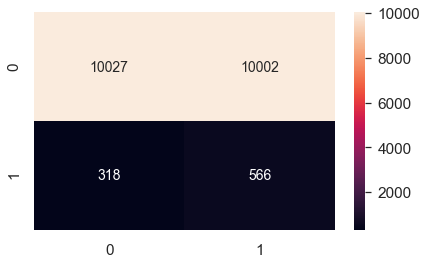

In [435]:
y_pred = pipeline_rfc.predict(X_test)
plot_confusion_matrix(y_test,y_pred)

In [436]:
param_grid = {
    'random_forest__max_depth': range(1,3),
    'random_forest__min_samples_leaf': range(100, 300, 100),
    'random_forest__min_samples_split': range(200, 400, 100),
    'random_forest__n_estimators': [100,300,500], 
    'random_forest__max_features': [5,10]
}

# Create a base model
rf = RandomForestClassifier(class_weight='balanced')

# create pipeline
steps = [("scaler", StandardScaler()),
         ("random_forest", rf)
        ]

pipeline_rf = Pipeline(steps)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = pipeline_rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1,verbose = 1,scoring='roc_auc')
# Fit the grid search to the data
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   46.6s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:  3.4min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('random_forest', RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            mi...='warn', n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'random_forest__max_depth': range(1, 3), 'random_forest__min_samples_leaf': range(100, 300, 100), 'random_forest__min_samples_split': range(200, 400, 100), 'random_forest__n_estimators': [100, 300, 500], 'random_forest__max_features': [5, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [437]:
# print best hyperparameters
print("Best AUC: ", grid_search.best_score_)
print("Best hyperparameters: ", grid_search.best_params_)

Best AUC:  0.5969951247510688
Best hyperparameters:  {'random_forest__max_depth': 2, 'random_forest__max_features': 10, 'random_forest__min_samples_leaf': 100, 'random_forest__min_samples_split': 200, 'random_forest__n_estimators': 100}


In [438]:
calculate_classification_metrics(grid_search,X_test,y_test)

Accuracy:0.562
Sensitivity:0.586
Specificity:0.561
AUC:0.60
Ks_2sampResult(statistic=0.16455370482031817, pvalue=1.6549911326562733e-20)


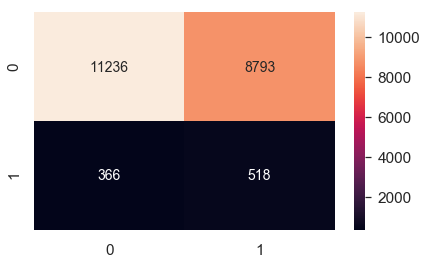

In [439]:
y_pred = grid_search.predict(X_test)
plot_confusion_matrix(y_test,y_pred)

In [440]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.97      0.56      0.71     20029
         1.0       0.06      0.59      0.10       884

   micro avg       0.56      0.56      0.56     20913
   macro avg       0.51      0.57      0.41     20913
weighted avg       0.93      0.56      0.68     20913



**XGBClassifier :**

In [441]:
y_train[y_train==0].count()

46734

In [442]:
y_train.value_counts()/len(y_train)

0.0    0.957762
1.0    0.042238
Name: Performance_Tag, dtype: float64

In [443]:
scale_pos_weight = (y_train[y_train==0].count())/(y_train[y_train==1].count())
scale_pos_weight

22.675400291120816

In [444]:
import xgboost as xgb
clf_gbt = xgb.XGBClassifier(max_depth=2,scale_pos_weight=scale_pos_weight,learning_rate=0.1)
clf_gbt.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=2, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=22.675400291120816, seed=None,
       silent=None, subsample=1, verbosity=1)

In [445]:
calculate_classification_metrics(clf_gbt,X_test,y_test)

Accuracy:0.621
Sensitivity:0.54
Specificity:0.625
AUC:0.61
Ks_2sampResult(statistic=0.1691500378749456, pvalue=1.2057267092848116e-21)


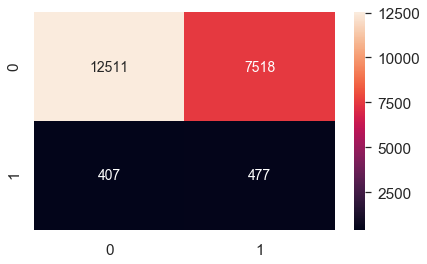

In [446]:
y_pred = clf_gbt.predict(X_test)
plot_confusion_matrix(y_test,y_pred)

In [447]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.97      0.62      0.76     20029
         1.0       0.06      0.54      0.11       884

   micro avg       0.62      0.62      0.62     20913
   macro avg       0.51      0.58      0.43     20913
weighted avg       0.93      0.62      0.73     20913



In [448]:
clf_gbt.get_booster().get_score(importance_type = 'weight')

{'No_of_months_in_current_residence': 71,
 'No_of_months_in_current_company': 68,
 'Income': 67,
 'Age': 51,
 'Profession_SE': 7,
 'No_of_dependents': 12,
 'Type_of_residence_Living with Parents': 1,
 'Education_Professional': 2,
 'Type_of_residence_Owned': 2,
 'Gender_M': 1}

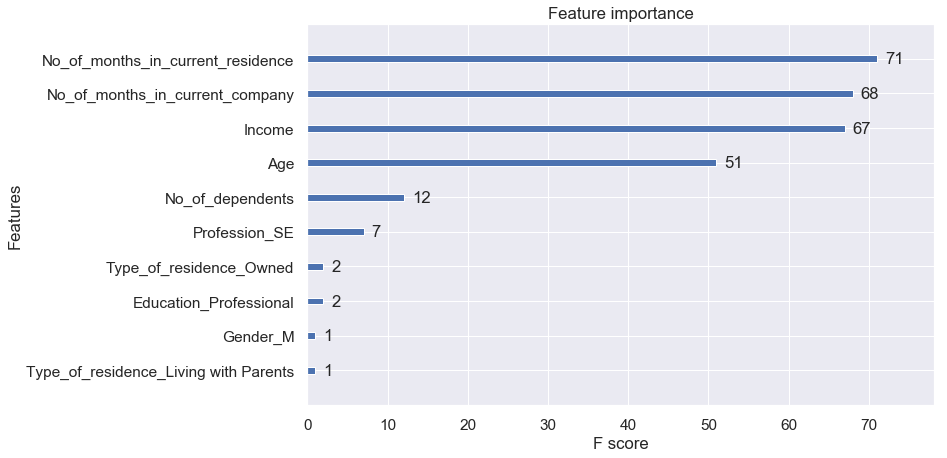

In [449]:
fig, ax = plt.subplots(figsize=(10, 7))
xgb.plot_importance(clf_gbt, importance_type = 'weight',ax=ax)
plt.show()

### Model Building on WOE Data:

In [450]:
demo_woe_data.head()

Application_ID   woe_Age  woe_Education  woe_Gender  woe_Income  woe_Marital_Status_at_the_time_of_application  woe_No_of_dependents  woe_No_of_months_in_current_company  woe_No_of_months_in_current_residence  woe_Profession  woe_Type_of_residence  Performance_Tag
0       954457215  0.007596      -0.014907   -0.032933    0.245612                                       0.004087             -0.005845                             0.123411                               -0.20823        0.028074               0.004056              0.0
1       432830445 -0.033484       0.017725    0.010391    0.263833                                       0.004087              0.011748                             0.072353                               -0.20823        0.014157               0.004056              0.0
2       941387308 -0.033484      -0.014907    0.010391    0.263833                                      -0.022694             -0.005845                             0.072353                               -0.20823        0.014157               0.004056              0.0
3       392161677  0.007596      -0.014907    0.010391    0.263833                                       0.004087             -0.005845                             0.123411                               -0.20823       -0.091452               0.004056              0.0
4       182011211 -0.033484       0.017725   -0.032933    0.245612                                       0.004087              0.011748                             0.072353                               -0.20823        0.028074               0.004056              0.0

In [451]:
X = demo_woe_data.drop(['Application_ID','Performance_Tag'],axis=1)
y = demo_woe_data['Performance_Tag']

In [452]:
X.head()

woe_Age  woe_Education  woe_Gender  woe_Income  woe_Marital_Status_at_the_time_of_application  woe_No_of_dependents  woe_No_of_months_in_current_company  woe_No_of_months_in_current_residence  woe_Profession  woe_Type_of_residence
0  0.007596      -0.014907   -0.032933    0.245612                                       0.004087             -0.005845                             0.123411                               -0.20823        0.028074               0.004056
1 -0.033484       0.017725    0.010391    0.263833                                       0.004087              0.011748                             0.072353                               -0.20823        0.014157               0.004056
2 -0.033484      -0.014907    0.010391    0.263833                                      -0.022694             -0.005845                             0.072353                               -0.20823        0.014157               0.004056
3  0.007596      -0.014907    0.010391    0.263833                                       0.004087             -0.005845                             0.123411                               -0.20823       -0.091452               0.004056
4 -0.033484       0.017725   -0.032933    0.245612                                       0.004087              0.011748                             0.072353                               -0.20823        0.028074               0.004056

In [453]:
y.head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Performance_Tag, dtype: float64

In [454]:
print(X.shape)
print(y.shape)

(69722, 10)
(69722,)


In [455]:
y.value_counts()

0.0    66777
1.0     2945
Name: Performance_Tag, dtype: int64

In [456]:
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.7,test_size=0.3,random_state=100,stratify=y)

In [457]:
print(X_train.shape)
print(X_test.shape)

(48805, 10)
(20917, 10)


In [458]:
y_train.value_counts()

0.0    46744
1.0     2061
Name: Performance_Tag, dtype: int64

In [459]:
#X_train,y_train = class_imbalance(X_train,y_train,target='Performance Tag')

In [460]:
#Training the model on the train data
lr = LogisticRegression(class_weight='balanced')
lr.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

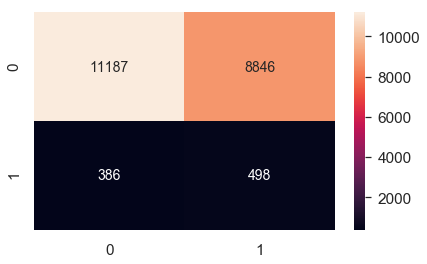

In [461]:
y_pred = lr.predict(X_test)
plot_confusion_matrix(y_test,y_pred)

In [462]:
calculate_classification_metrics(lr,X_test,y_test)

Accuracy:0.559
Sensitivity:0.563
Specificity:0.558
AUC:0.58
Ks_2sampResult(statistic=0.1343856166736649, pvalue=8.075411740364155e-14)


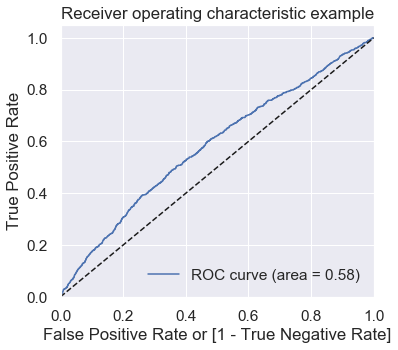

In [463]:
pred_probs_test = lr.predict_proba(X_test)[:,1]
draw_roc(y_test, pred_probs_test)

In [464]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.97      0.56      0.71     20033
         1.0       0.05      0.56      0.10       884

   micro avg       0.56      0.56      0.56     20917
   macro avg       0.51      0.56      0.40     20917
weighted avg       0.93      0.56      0.68     20917



**Hyperparameter Tuning**

In [465]:
logistic = LogisticRegression(class_weight='balanced')

# hyperparameter space
params = {'C': [0.005,0.008,0.01,0.03,0.05,0.1, 0.5, 1], 'penalty': ['l1', 'l2']}

# create 5 folds
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 4)

# create gridsearch object
model = GridSearchCV(estimator=logistic, cv=folds, param_grid=params, scoring='roc_auc', n_jobs=-1, verbose=1)

In [466]:
model.fit(X_train,y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    4.3s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=4, shuffle=True),
       error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': [0.005, 0.008, 0.01, 0.03, 0.05, 0.1, 0.5, 1], 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [467]:
# print best hyperparameters
print("Best AUC: ", model.best_score_)
print("Best hyperparameters: ", model.best_params_)

Best AUC:  0.5853213040925308
Best hyperparameters:  {'C': 0.05, 'penalty': 'l1'}


In [468]:
calculate_classification_metrics(model,X_test,y_test)

Accuracy:0.579
Sensitivity:0.553
Specificity:0.58
AUC:0.58
Ks_2sampResult(statistic=0.1435212781263856, pvalue=1.057330725811649e-15)


In [469]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.97      0.56      0.71     20033
         1.0       0.05      0.56      0.10       884

   micro avg       0.56      0.56      0.56     20917
   macro avg       0.51      0.56      0.40     20917
weighted avg       0.93      0.56      0.68     20917



### Inference :

We tested different models on the demographic actual data, as well as logistic model on woe data. From the performance metrics of the various models on demographic data, it can be observed that demographic data doesn't have much predictive power. We will need the credit bureau data to enhance the predictive power of the data.

# Credit Bureau and Demographic Data :

## Data Understanding and Cleansing :

In [470]:
# Reading the credit bureau data
credit_bureau = pd.read_csv('Credit Bureau data.csv')
credit_bureau.head()

Application ID  No of times 90 DPD or worse in last 6 months  No of times 60 DPD or worse in last 6 months  No of times 30 DPD or worse in last 6 months  No of times 90 DPD or worse in last 12 months  No of times 60 DPD or worse in last 12 months  No of times 30 DPD or worse in last 12 months  Avgas CC Utilization in last 12 months  No of trades opened in last 6 months  No of trades opened in last 12 months  No of PL trades opened in last 6 months  No of PL trades opened in last 12 months  No of Inquiries in last 6 months (excluding home & auto loans)  No of Inquiries in last 12 months (excluding home & auto loans)  Presence of open home loan  Outstanding Balance  Total No of Trades  Presence of open auto loan  Performance Tag
0       954457215                                             0                                             0                                             0                                              0                                              0                                              0                                     4.0                                   1.0                                      2                                        0                                         0                                                  0                                                               0                                       1.0            2999395.0                   4                           0              0.0
1       432830445                                             0                                             0                                             0                                              0                                              0                                              0                                     3.0                                   1.0                                      2                                        0                                         0                                                  0                                                               0                                       0.0               3078.0                   5                           0              0.0
2       941387308                                             0                                             0                                             0                                              0                                              0                                              0                                     7.0                                   0.0                                      0                                        0                                         0                                                  0                                                               0                                       1.0            3004972.0                   2                           0              0.0
3       392161677                                             0                                             0                                             0                                              0                                              0                                              0                                    11.0                                   1.0                                      1                                        0                                         0                                                  0                                                               0                                       1.0            3355373.0                   4                           1              0.0
4       182011211                                             0                                             0                                             0                                              0                                              0                                              0       

In [471]:
credit_bureau.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71295 entries, 0 to 71294
Data columns (total 19 columns):
Application ID                                                     71295 non-null int64
No of times 90 DPD or worse in last 6 months                       71295 non-null int64
No of times 60 DPD or worse in last 6 months                       71295 non-null int64
No of times 30 DPD or worse in last 6 months                       71295 non-null int64
No of times 90 DPD or worse in last 12 months                      71295 non-null int64
No of times 60 DPD or worse in last 12 months                      71295 non-null int64
No of times 30 DPD or worse in last 12 months                      71295 non-null int64
Avgas CC Utilization in last 12 months                             70237 non-null float64
No of trades opened in last 6 months                               71294 non-null float64
No of trades opened in last 12 months                              71295 non-null int64
No of P

In [472]:
credit_bureau.describe()

Application ID  No of times 90 DPD or worse in last 6 months  No of times 60 DPD or worse in last 6 months  No of times 30 DPD or worse in last 6 months  No of times 90 DPD or worse in last 12 months  No of times 60 DPD or worse in last 12 months  No of times 30 DPD or worse in last 12 months  Avgas CC Utilization in last 12 months  No of trades opened in last 6 months  No of trades opened in last 12 months  No of PL trades opened in last 6 months  No of PL trades opened in last 12 months  No of Inquiries in last 6 months (excluding home & auto loans)  No of Inquiries in last 12 months (excluding home & auto loans)  Presence of open home loan  Outstanding Balance  Total No of Trades  Presence of open auto loan  Performance Tag
count    7.129500e+04                                  71295.000000                                  71295.000000                                  71295.000000                                   71295.000000                                   71295.000000                                   71295.000000                            70237.000000                          71294.000000                           71295.000000                             71295.000000                              71295.000000                                       71295.000000                                                    71295.000000                              71023.000000         7.102300e+04        71295.000000                71295.000000     69870.000000
mean     4.989601e+08                                      0.270313                                      0.430535                                      0.577207                                       0.450340                                       0.655488                                       0.800912                               29.696926                              2.298048                               5.826888                                 1.206901                                  2.397447                                           1.763532                                                        3.535241                                  0.256424         1.249163e+06            8.186633                    0.084620         0.042193
std      2.885905e+08                                      0.534166                                      0.825334                                      1.074436                                       0.808387                                       1.089535                                       1.331940                               29.533308                              2.070191                               5.065096                                 1.352936                                  2.420086                                           1.971294                                                        3.582199                                  0.436662         1.278874e+06            7.090776                    0.278318         0.201030
min      1.004500e+05                                      0.000000                                      0.000000                                      0.000000                                       0.000000                                       0.000000                                       0.000000                                0.000000                              0.000000                               0.000000                                 0.000000                                  0.000000                                           0.000000                                                        0.000000                                  0.000000         0.000000e+00            0.000000                    0.000000         0.000000
25%      2.483719e+08                                      0.000000                                      0.000000                                      0.000000                                       0.000000                                       0.000000                                  

In [473]:
# Data understnading using pandas profiling
columns = credit_bureau.columns # taking a backup of columns as pandas profiling alters column names
pandas_profiling.ProfileReport(credit_bureau)

From the profiling report we could get a high level understanding of the data , the columns having high missing values and highly correlated columns, We will be handling all these data issues.

In [474]:
credit_bureau.columns = columns

In [475]:
credit_bureau.isnull().sum()

Application ID                                                        0
No of times 90 DPD or worse in last 6 months                          0
No of times 60 DPD or worse in last 6 months                          0
No of times 30 DPD or worse in last 6 months                          0
No of times 90 DPD or worse in last 12 months                         0
No of times 60 DPD or worse in last 12 months                         0
No of times 30 DPD or worse in last 12 months                         0
Avgas CC Utilization in last 12 months                             1058
No of trades opened in last 6 months                                  1
No of trades opened in last 12 months                                 0
No of PL trades opened in last 6 months                               0
No of PL trades opened in last 12 months                              0
No of Inquiries in last 6 months (excluding home & auto loans)        0
No of Inquiries in last 12 months (excluding home & auto loans) 

In [476]:
missing_values(credit_bureau)

Total columns at least one Values: 
                                        Total   Percent
Performance Tag                          1425  1.998738
Avgas CC Utilization in last 12 months   1058  1.483975
Outstanding Balance                       272  0.381513
Presence of open home loan                272  0.381513
No of trades opened in last 6 months        1  0.001403


Performance Tag has around 1425 missing values, which are the rejected candidates. We will keep it separate for later analysis and remove those rows from the dataset.

In [477]:
credit_bureau.drop_duplicates().shape

(71295, 19)

In [478]:
credit_bureau.columns = credit_bureau.columns.str.strip().str.replace(' ','_').str.replace('(','').str.replace(')','')

In [479]:
credit_bureau.head()

Application_ID  No_of_times_90_DPD_or_worse_in_last_6_months  No_of_times_60_DPD_or_worse_in_last_6_months  No_of_times_30_DPD_or_worse_in_last_6_months  No_of_times_90_DPD_or_worse_in_last_12_months  No_of_times_60_DPD_or_worse_in_last_12_months  No_of_times_30_DPD_or_worse_in_last_12_months  Avgas_CC_Utilization_in_last_12_months  No_of_trades_opened_in_last_6_months  No_of_trades_opened_in_last_12_months  No_of_PL_trades_opened_in_last_6_months  No_of_PL_trades_opened_in_last_12_months  No_of_Inquiries_in_last_6_months_excluding_home_&_auto_loans  No_of_Inquiries_in_last_12_months_excluding_home_&_auto_loans  Presence_of_open_home_loan  Outstanding_Balance  Total_No_of_Trades  Presence_of_open_auto_loan  Performance_Tag
0       954457215                                             0                                             0                                             0                                              0                                              0                                              0                                     4.0                                   1.0                                      2                                        0                                         0                                                  0                                                             0                                     1.0            2999395.0                   4                           0              0.0
1       432830445                                             0                                             0                                             0                                              0                                              0                                              0                                     3.0                                   1.0                                      2                                        0                                         0                                                  0                                                             0                                     0.0               3078.0                   5                           0              0.0
2       941387308                                             0                                             0                                             0                                              0                                              0                                              0                                     7.0                                   0.0                                      0                                        0                                         0                                                  0                                                             0                                     1.0            3004972.0                   2                           0              0.0
3       392161677                                             0                                             0                                             0                                              0                                              0                                              0                                    11.0                                   1.0                                      1                                        0                                         0                                                  0                                                             0                                     1.0            3355373.0                   4                           1              0.0
4       182011211                                             0                                             0                                             0                                              0                                              0                                              0                           

In [480]:
# Storing the rejected candidates in a separate dataframe for later analysis
rejected_credit_bureau = credit_bureau[credit_bureau["Performance_Tag"].isna()]
rejected_credit_bureau.head()

Application_ID  No_of_times_90_DPD_or_worse_in_last_6_months  No_of_times_60_DPD_or_worse_in_last_6_months  No_of_times_30_DPD_or_worse_in_last_6_months  No_of_times_90_DPD_or_worse_in_last_12_months  No_of_times_60_DPD_or_worse_in_last_12_months  No_of_times_30_DPD_or_worse_in_last_12_months  Avgas_CC_Utilization_in_last_12_months  No_of_trades_opened_in_last_6_months  No_of_trades_opened_in_last_12_months  No_of_PL_trades_opened_in_last_6_months  No_of_PL_trades_opened_in_last_12_months  No_of_Inquiries_in_last_6_months_excluding_home_&_auto_loans  No_of_Inquiries_in_last_12_months_excluding_home_&_auto_loans  Presence_of_open_home_loan  Outstanding_Balance  Total_No_of_Trades  Presence_of_open_auto_loan  Performance_Tag
69603       906908303                                             0                                             0                                             2                                              1                                              2                                              3                                    30.0                                   4.0                                     12                                        3                                         7                                                  2                                                             4                                     0.0            1309623.0                  13                           0              NaN
69604        10990583                                             1                                             1                                             1                                              3                                              2                                              2                                    16.0                                   3.0                                      7                                        3                                         4                                                  3                                                             5                                     0.0             775626.0                   7                           0              NaN
69605       589678446                                             3                                             4                                             5                                              3                                              5                                              6                                    83.0                                   2.0                                      7                                        2                                         4                                                  0                                                             3                                     0.0             732602.0                   8                           0              NaN
69606       809411322                                             1                                             3                                             4                                              3                                              4                                              5                                    87.0                                   2.0                                      7                                        1                                         4                                                  4                                                             5                                     0.0             842057.0                   8                           0              NaN
69607       150246616                                             2                                             2                                             4                                              3                                              2                                              6       

In [481]:
rejected_credit_bureau.shape

(1425, 19)

In [482]:
# Check for number of unique values
credit_bureau.nunique()

Application_ID                                                   71292
No_of_times_90_DPD_or_worse_in_last_6_months                         4
No_of_times_60_DPD_or_worse_in_last_6_months                         6
No_of_times_30_DPD_or_worse_in_last_6_months                         8
No_of_times_90_DPD_or_worse_in_last_12_months                        6
No_of_times_60_DPD_or_worse_in_last_12_months                        8
No_of_times_30_DPD_or_worse_in_last_12_months                       10
Avgas_CC_Utilization_in_last_12_months                             114
No_of_trades_opened_in_last_6_months                                13
No_of_trades_opened_in_last_12_months                               29
No_of_PL_trades_opened_in_last_6_months                              7
No_of_PL_trades_opened_in_last_12_months                            13
No_of_Inquiries_in_last_6_months_excluding_home_&_auto_loans        11
No_of_Inquiries_in_last_12_months_excluding_home_&_auto_loans       21
Presen

In [483]:
# Check duplicates on Application_ID
credit_bureau["Application_ID"].duplicated().sum()

3

In [484]:
credit_bureau[credit_bureau['Application_ID'].duplicated(keep=False)]

Application_ID  No_of_times_90_DPD_or_worse_in_last_6_months  No_of_times_60_DPD_or_worse_in_last_6_months  No_of_times_30_DPD_or_worse_in_last_6_months  No_of_times_90_DPD_or_worse_in_last_12_months  No_of_times_60_DPD_or_worse_in_last_12_months  No_of_times_30_DPD_or_worse_in_last_12_months  Avgas_CC_Utilization_in_last_12_months  No_of_trades_opened_in_last_6_months  No_of_trades_opened_in_last_12_months  No_of_PL_trades_opened_in_last_6_months  No_of_PL_trades_opened_in_last_12_months  No_of_Inquiries_in_last_6_months_excluding_home_&_auto_loans  No_of_Inquiries_in_last_12_months_excluding_home_&_auto_loans  Presence_of_open_home_loan  Outstanding_Balance  Total_No_of_Trades  Presence_of_open_auto_loan  Performance_Tag
5243        653287861                                             0                                             0                                             0                                              0                                              0                                              0                                    15.0                                   0.0                                      0                                        0                                         0                                                  0                                                             0                                     0.0              10494.0                   2                           0              0.0
24386       765011468                                             0                                             0                                             0                                              0                                              0                                              0                                    11.0                                   1.0                                      2                                        0                                         1                                                  2                                                             2                                     0.0             212656.0                   3                           0              0.0
27586       765011468                                             0                                             0                                             0                                              0                                              0                                              0                                    11.0                                   1.0                                      3                                        0                                         0                                                  1                                                             3                                     0.0              29817.0                   6                           0              0.0
42637       653287861                                             1                                             1                                             1                                              2                                              2                                              2                                   113.0                                   2.0                                      5                                        1                                         3                                                  1                                                             3                                     0.0             628075.0                   6                           0              1.0
48602       671989187                                             1                                             2                                             3                                              2                                              2                                              3       

In [485]:
# Deleting first occurrence rows with duplicated application id
credit_bureau.drop_duplicates(subset=['Application_ID'], keep='last', inplace=True)

In [486]:
credit_bureau.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71292 entries, 0 to 71294
Data columns (total 19 columns):
Application_ID                                                   71292 non-null int64
No_of_times_90_DPD_or_worse_in_last_6_months                     71292 non-null int64
No_of_times_60_DPD_or_worse_in_last_6_months                     71292 non-null int64
No_of_times_30_DPD_or_worse_in_last_6_months                     71292 non-null int64
No_of_times_90_DPD_or_worse_in_last_12_months                    71292 non-null int64
No_of_times_60_DPD_or_worse_in_last_12_months                    71292 non-null int64
No_of_times_30_DPD_or_worse_in_last_12_months                    71292 non-null int64
Avgas_CC_Utilization_in_last_12_months                           70234 non-null float64
No_of_trades_opened_in_last_6_months                             71291 non-null float64
No_of_trades_opened_in_last_12_months                            71292 non-null int64
No_of_PL_trades_opened_in_l

**Handling missing values**

In [487]:
missing_values(credit_bureau)

Total columns at least one Values: 
                                        Total   Percent
Performance_Tag                          1425  1.998822
Avgas_CC_Utilization_in_last_12_months   1058  1.484037
Outstanding_Balance                       272  0.381529
Presence_of_open_home_loan                272  0.381529
No_of_trades_opened_in_last_6_months        1  0.001403


In [488]:
# Removing the entries with performance_tag as null from the dataset
credit_bureau = credit_bureau[~credit_bureau['Performance_Tag'].isna()]

In [489]:
missing_values(credit_bureau)

Total columns at least one Values: 
                                        Total   Percent
Avgas_CC_Utilization_in_last_12_months   1023  1.464211
Outstanding_Balance                       272  0.389311
Presence_of_open_home_loan                272  0.389311
No_of_trades_opened_in_last_6_months        1  0.001431


In [490]:
credit_bureau[credit_bureau["Avgas_CC_Utilization_in_last_12_months"].isna()]['Performance_Tag'].value_counts()

0.0    975
1.0     48
Name: Performance_Tag, dtype: int64

In [491]:
credit_bureau[credit_bureau["Outstanding_Balance"].isna()]['Performance_Tag'].value_counts()

0.0    264
1.0      8
Name: Performance_Tag, dtype: int64

In [492]:
credit_bureau[credit_bureau["Presence_of_open_home_loan"].isna()]['Performance_Tag'].value_counts()

0.0    264
1.0      8
Name: Performance_Tag, dtype: int64

In [493]:
# Creating a copy of the dataframe on which we will perform the woe transformation
credit_bureau_woe = credit_bureau.copy()

In [494]:
credit_bureau.dropna(subset = ['Avgas_CC_Utilization_in_last_12_months','Outstanding_Balance',\
                               'No_of_trades_opened_in_last_6_months'],inplace=True)

In [495]:
credit_bureau.isnull().sum()

Application_ID                                                   0
No_of_times_90_DPD_or_worse_in_last_6_months                     0
No_of_times_60_DPD_or_worse_in_last_6_months                     0
No_of_times_30_DPD_or_worse_in_last_6_months                     0
No_of_times_90_DPD_or_worse_in_last_12_months                    0
No_of_times_60_DPD_or_worse_in_last_12_months                    0
No_of_times_30_DPD_or_worse_in_last_12_months                    0
Avgas_CC_Utilization_in_last_12_months                           0
No_of_trades_opened_in_last_6_months                             0
No_of_trades_opened_in_last_12_months                            0
No_of_PL_trades_opened_in_last_6_months                          0
No_of_PL_trades_opened_in_last_12_months                         0
No_of_Inquiries_in_last_6_months_excluding_home_&_auto_loans     0
No_of_Inquiries_in_last_12_months_excluding_home_&_auto_loans    0
Presence_of_open_home_loan                                    

### Creation of WOE Dataset :

In [496]:
credit_bureau_woe.head()

Application_ID  No_of_times_90_DPD_or_worse_in_last_6_months  No_of_times_60_DPD_or_worse_in_last_6_months  No_of_times_30_DPD_or_worse_in_last_6_months  No_of_times_90_DPD_or_worse_in_last_12_months  No_of_times_60_DPD_or_worse_in_last_12_months  No_of_times_30_DPD_or_worse_in_last_12_months  Avgas_CC_Utilization_in_last_12_months  No_of_trades_opened_in_last_6_months  No_of_trades_opened_in_last_12_months  No_of_PL_trades_opened_in_last_6_months  No_of_PL_trades_opened_in_last_12_months  No_of_Inquiries_in_last_6_months_excluding_home_&_auto_loans  No_of_Inquiries_in_last_12_months_excluding_home_&_auto_loans  Presence_of_open_home_loan  Outstanding_Balance  Total_No_of_Trades  Presence_of_open_auto_loan  Performance_Tag
0       954457215                                             0                                             0                                             0                                              0                                              0                                              0                                     4.0                                   1.0                                      2                                        0                                         0                                                  0                                                             0                                     1.0            2999395.0                   4                           0              0.0
1       432830445                                             0                                             0                                             0                                              0                                              0                                              0                                     3.0                                   1.0                                      2                                        0                                         0                                                  0                                                             0                                     0.0               3078.0                   5                           0              0.0
2       941387308                                             0                                             0                                             0                                              0                                              0                                              0                                     7.0                                   0.0                                      0                                        0                                         0                                                  0                                                             0                                     1.0            3004972.0                   2                           0              0.0
3       392161677                                             0                                             0                                             0                                              0                                              0                                              0                                    11.0                                   1.0                                      1                                        0                                         0                                                  0                                                             0                                     1.0            3355373.0                   4                           1              0.0
4       182011211                                             0                                             0                                             0                                              0                                              0                                              0                           

In [497]:
credit_bureau_woe.shape

(69867, 19)

In [498]:
credit_bureau_woe_bak = credit_bureau_woe.copy()

In [499]:
credit_bureau_woe_details, credit_bureau_iv = woe(credit_bureau_woe.loc[:,'No_of_times_90_DPD_or_worse_in_last_6_months':], \
                                                  credit_bureau_woe['Performance_Tag'],'Performance_Tag')

In [500]:
credit_bureau_iv.sort_values('IV',ascending=False)

Variable        IV
0              Avgas_CC_Utilization_in_last_12_months  0.294080
11              No_of_trades_opened_in_last_12_months  0.257518
1   No_of_Inquiries_in_last_12_months_excluding_ho...  0.229279
16                                 Total_No_of_Trades  0.189996
5       No_of_times_30_DPD_or_worse_in_last_12_months  0.188403
3            No_of_PL_trades_opened_in_last_12_months  0.176856
6        No_of_times_30_DPD_or_worse_in_last_6_months  0.145515
7       No_of_times_60_DPD_or_worse_in_last_12_months  0.138034
4             No_of_PL_trades_opened_in_last_6_months  0.124506
9       No_of_times_90_DPD_or_worse_in_last_12_months  0.096123
12               No_of_trades_opened_in_last_6_months  0.095478
2   No_of_Inquiries_in_last_6_months_excluding_hom...  0.092685
8        No_of_times_60_DPD_or_worse_in_last_6_months  0.089478
10       No_of_times_90_DPD_or_worse_in_last_6_months  0.030681
13                                Outstanding_Balance  0.008594
14                         Presence_of_open_auto_loan  0.001662
15                         Presence_of_open_home_loan  0.000462

In [501]:
credit_bureau_woe_details.head()

Variable  Min_value  Max_value      N  Events  Non-Events  % of Events  % of Non-Events       WoE        IV
0  No_of_times_90_DPD_or_worse_in_last_6_months        0.0        1.0  67883  2765.0     65118.0     0.937924         0.973087  0.036804  0.001294
1  No_of_times_90_DPD_or_worse_in_last_6_months        2.0        3.0   1984   183.0      1801.0     0.062076         0.026913 -0.835745  0.029387
2  No_of_times_60_DPD_or_worse_in_last_6_months        0.0        1.0  63001  2366.0     60635.0     0.802578         0.906095  0.121316  0.012558
3  No_of_times_60_DPD_or_worse_in_last_6_months        2.0        5.0   6866   582.0      6284.0     0.197422         0.093905 -0.743064  0.076920
4  No_of_times_30_DPD_or_worse_in_last_6_months        0.0        1.0  59598  2078.0     57520.0     0.704885         0.859547  0.198371  0.030680

In [502]:
data = [go.Bar(
            x=credit_bureau_woe_details['Variable'],
            y=credit_bureau_woe_details['WoE'],
            text=credit_bureau_woe_details['Variable'],
            marker=dict(
            color='rgb(158,20,25)',
            line=dict(
            color='rgb(8,48,107)',
            width=1.5,
        )
    ),
    opacity=0.6
    )]


layout = go.Layout(
    title='Weight of Evidence(WOE)',
        xaxis=dict(
        title='Features',
            tickangle=-45,
        tickfont=dict(
            size=10,
            color='rgb(107, 107, 107)'
        )
    ),
    yaxis=dict(
        title='Weight of Evidence(WOE)',
        titlefont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        ),
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
    ),
)

plotly.offline.iplot({
    "data": data,'layout':layout
})

In [503]:
data = [go.Bar(
            x=credit_bureau_iv['Variable'],
            y=credit_bureau_iv['IV'],
            text=credit_bureau_iv['Variable'],
            marker=dict(
            color='rgb(58,256,225)',
            line=dict(
            color='rgb(8,48,107)',
            width=1.5,
        )
    ),
    opacity=0.6
    )]


layout = go.Layout(
    title='Information Values',
        xaxis=dict(
        tickangle=-45,
        title='Features',
        tickfont=dict(
            size=10,
            color='rgb(7, 7, 7)'
        )
    ),
    yaxis=dict(
        title='Information Value(IV)',
        titlefont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        ),
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
    ),
)

plotly.offline.iplot({
    "data": data,'layout':layout
})

In [504]:
# df = credit_bureau_woe.loc[:,'No_of_times_90_DPD_or_worse_in_last_6_months':]
# transform_vars_list = df.columns.difference(['Performance_Tag'])
# transform_prefix = 'woe_'
# transform_vars_list

In [505]:
woe_transformed_df = apply_woe(credit_bureau_woe,credit_bureau_woe_details,transform_prefix='woe_',\
                               exclude=['Application_ID','Performance_Tag'])

Transforming for column : Avgas_CC_Utilization_in_last_12_months
Transforming for column : No_of_Inquiries_in_last_12_months_excluding_home_&_auto_loans
Transforming for column : No_of_Inquiries_in_last_6_months_excluding_home_&_auto_loans
Transforming for column : No_of_PL_trades_opened_in_last_12_months
Transforming for column : No_of_PL_trades_opened_in_last_6_months
Transforming for column : No_of_times_30_DPD_or_worse_in_last_12_months
Transforming for column : No_of_times_30_DPD_or_worse_in_last_6_months
Transforming for column : No_of_times_60_DPD_or_worse_in_last_12_months
Transforming for column : No_of_times_60_DPD_or_worse_in_last_6_months
Transforming for column : No_of_times_90_DPD_or_worse_in_last_12_months
Transforming for column : No_of_times_90_DPD_or_worse_in_last_6_months
Transforming for column : No_of_trades_opened_in_last_12_months
Transforming for column : No_of_trades_opened_in_last_6_months
Transforming for column : Outstanding_Balance
Transforming for column :

In [506]:
woe_transformed_df.head()

Application_ID  No_of_times_90_DPD_or_worse_in_last_6_months  No_of_times_60_DPD_or_worse_in_last_6_months  No_of_times_30_DPD_or_worse_in_last_6_months  No_of_times_90_DPD_or_worse_in_last_12_months  No_of_times_60_DPD_or_worse_in_last_12_months  No_of_times_30_DPD_or_worse_in_last_12_months  Avgas_CC_Utilization_in_last_12_months  No_of_trades_opened_in_last_6_months  No_of_trades_opened_in_last_12_months  No_of_PL_trades_opened_in_last_6_months  No_of_PL_trades_opened_in_last_12_months  No_of_Inquiries_in_last_6_months_excluding_home_&_auto_loans  No_of_Inquiries_in_last_12_months_excluding_home_&_auto_loans  Presence_of_open_home_loan  Outstanding_Balance  Total_No_of_Trades  Presence_of_open_auto_loan  Performance_Tag  woe_Avgas_CC_Utilization_in_last_12_months  woe_No_of_Inquiries_in_last_12_months_excluding_home_&_auto_loans  woe_No_of_Inquiries_in_last_6_months_excluding_home_&_auto_loans  woe_No_of_PL_trades_opened_in_last_12_months  woe_No_of_PL_trades_opened_in_last_6_months  woe_No_of_times_30_DPD_or_worse_in_last_12_months  woe_No_of_times_30_DPD_or_worse_in_last_6_months  woe_No_of_times_60_DPD_or_worse_in_last_12_months  woe_No_of_times_60_DPD_or_worse_in_last_6_months  woe_No_of_times_90_DPD_or_worse_in_last_12_months  woe_No_of_times_90_DPD_or_worse_in_last_6_months  woe_No_of_trades_opened_in_last_12_months  woe_No_of_trades_opened_in_last_6_months  woe_Outstanding_Balance  woe_Presence_of_open_auto_loan  woe_Presence_of_open_home_loan  woe_Total_No_of_Trades
0       954457215                                             0                                             0                                             0                                              0                                              0                                              0                                     4.0                                   1.0                                      2                                        0                                         0                                                  0                                                             0                                     1.0            2999395.0                   4                           0              0.0                                    0.799246                                           0.828596                                                           0.319569                                                     0.453449                                     0.314271                                           0.269272                                          0.198371                                           0.200955                                          0.121316                                           0.133954                                          0.036804                                   0.865398                                  0.270556                -0.087933                       -0.011997                       -0.001235                0.686484
1       432830445                                             0                                             0                                             0                                              0                                              0                                              0                                     3.0                                   1.0                                      2                                        0                                         0                                                  0                                                             0                                     0.0               3078.0                   5                           0              0.0                                    0.799246                                           0.828596                                                           0.319569                                                     0.453449                                   

In [507]:
credit_bureau_woe_data = create_woe_df(woe_transformed_df)
credit_bureau_woe_data.head()

Application_ID  woe_Avgas_CC_Utilization_in_last_12_months  woe_No_of_Inquiries_in_last_12_months_excluding_home_&_auto_loans  woe_No_of_Inquiries_in_last_6_months_excluding_home_&_auto_loans  woe_No_of_PL_trades_opened_in_last_12_months  woe_No_of_PL_trades_opened_in_last_6_months  woe_No_of_times_30_DPD_or_worse_in_last_12_months  woe_No_of_times_30_DPD_or_worse_in_last_6_months  woe_No_of_times_60_DPD_or_worse_in_last_12_months  woe_No_of_times_60_DPD_or_worse_in_last_6_months  woe_No_of_times_90_DPD_or_worse_in_last_12_months  woe_No_of_times_90_DPD_or_worse_in_last_6_months  woe_No_of_trades_opened_in_last_12_months  woe_No_of_trades_opened_in_last_6_months  woe_Outstanding_Balance  woe_Presence_of_open_auto_loan  woe_Presence_of_open_home_loan  woe_Total_No_of_Trades  Performance_Tag
0       954457215                                    0.799246                                           0.828596                                                           0.319569                                                     0.453449                                     0.314271                                           0.269272                                          0.198371                                           0.200955                                          0.121316                                           0.133954                                          0.036804                                   0.865398                                  0.270556                -0.087933                       -0.011997                       -0.001235                0.686484              0.0
1       432830445                                    0.799246                                           0.828596                                                           0.319569                                                     0.453449                                     0.314271                                           0.269272                                          0.198371                                           0.200955                                          0.121316                                           0.133954                                          0.036804                                   0.865398                                  0.270556                 0.092939                       -0.011997                       -0.001235               -0.210878              0.0
2       941387308                                    0.799246                                           0.828596                                                           0.319569                                                     0.453449                                     0.314271                                           0.269272                                          0.198371                                           0.200955                                          0.121316                                           0.133954                                          0.036804                                   0.865398                                  0.270556                -0.087933                       -0.011997                       -0.001235                0.686484              0.0
3       392161677                                    0.574668                                           0.828596                                                           0.319569                                                     0.453449                                     0.314271                                           0.269272                                          0.198371                                           0.200955                                          0.121316                                           0.133954                                          0.036804                                   0.865398                                  0.270556                -0.087933                        0.138547                       -0.001235                0.686484 

In [508]:
credit_bureau_woe_data.isnull().sum()

Application_ID                                                       0
woe_Avgas_CC_Utilization_in_last_12_months                           0
woe_No_of_Inquiries_in_last_12_months_excluding_home_&_auto_loans    0
woe_No_of_Inquiries_in_last_6_months_excluding_home_&_auto_loans     0
woe_No_of_PL_trades_opened_in_last_12_months                         0
woe_No_of_PL_trades_opened_in_last_6_months                          0
woe_No_of_times_30_DPD_or_worse_in_last_12_months                    0
woe_No_of_times_30_DPD_or_worse_in_last_6_months                     0
woe_No_of_times_60_DPD_or_worse_in_last_12_months                    0
woe_No_of_times_60_DPD_or_worse_in_last_6_months                     0
woe_No_of_times_90_DPD_or_worse_in_last_12_months                    0
woe_No_of_times_90_DPD_or_worse_in_last_6_months                     0
woe_No_of_trades_opened_in_last_12_months                            0
woe_No_of_trades_opened_in_last_6_months                             0
woe_Ou

In [509]:
credit_bureau_woe_data.shape

(69867, 19)

In [510]:
credit_bureau_woe_data['Performance_Tag'].value_counts()

0.0    66919
1.0     2948
Name: Performance_Tag, dtype: int64

### Merge actual demographic and actual credit bureau data

In [511]:
credit_bureau.shape

(68844, 19)

In [512]:
demo.shape

(69708, 12)

In [513]:
merged_actual_df = pd.merge(left=demo,right=credit_bureau,on = 'Application_ID',how='inner')
merged_actual_df.head()

Application_ID  Age Gender Marital_Status_at_the_time_of_application  No_of_dependents  Income     Education Profession Type_of_residence  No_of_months_in_current_residence  No_of_months_in_current_company  Performance_Tag_x  No_of_times_90_DPD_or_worse_in_last_6_months  No_of_times_60_DPD_or_worse_in_last_6_months  No_of_times_30_DPD_or_worse_in_last_6_months  No_of_times_90_DPD_or_worse_in_last_12_months  No_of_times_60_DPD_or_worse_in_last_12_months  No_of_times_30_DPD_or_worse_in_last_12_months  Avgas_CC_Utilization_in_last_12_months  No_of_trades_opened_in_last_6_months  No_of_trades_opened_in_last_12_months  No_of_PL_trades_opened_in_last_6_months  No_of_PL_trades_opened_in_last_12_months  No_of_Inquiries_in_last_6_months_excluding_home_&_auto_loans  No_of_Inquiries_in_last_12_months_excluding_home_&_auto_loans  Presence_of_open_home_loan  Outstanding_Balance  Total_No_of_Trades  Presence_of_open_auto_loan  Performance_Tag_y
0       954457215   48      F                                   Married               2.0    40.0      Bachelor        SAL            Rented                                113                               56                0.0                                             0                                             0                                             0                                              0                                              0                                              0                                     4.0                                   1.0                                      2                                        0                                         0                                                  0                                                             0                                     1.0            2999395.0                   4                           0                0.0
1       432830445   31      M                                   Married               4.0    55.0  Professional    SE_PROF            Rented                                112                               46                0.0                                             0                                             0                                             0                                              0                                              0                                              0                                     3.0                                   1.0                                      2                                        0                                         0                                                  0                                                             0                                     0.0               3078.0                   5                           0                0.0
2       941387308   32      M                                    Single               2.0    46.0      Bachelor    SE_PROF            Rented                                104                               49                0.0                                             0                                             0                                             0                                              0                                              0                                              0                                     7.0                                   0.0                                      0                                        0                                         0                                                  0                                                             0                                     1.0            3004972.0                   2                           0                0.0
3       392161677   43      M                                   Married               1.0    53.0      Bachelor         SE            Rented                                 94                               53   

In [514]:
merged_actual_df.shape

(68692, 30)

In [515]:
#merged_actual_df = merged_actual_df.drop('Performance_Tag_x',axis=1)
#merged_actual_df.rename({'Performance_Tag_y':'Performance_Tag'},axis=1,inplace=True)

In [516]:
#merged_actual_df.head()

### Exploratory Data Analysis

In [517]:
merged_actual_df.columns

Index(['Application_ID', 'Age', 'Gender', 'Marital_Status_at_the_time_of_application', 'No_of_dependents', 'Income', 'Education', 'Profession', 'Type_of_residence', 'No_of_months_in_current_residence', 'No_of_months_in_current_company', 'Performance_Tag_x', 'No_of_times_90_DPD_or_worse_in_last_6_months', 'No_of_times_60_DPD_or_worse_in_last_6_months', 'No_of_times_30_DPD_or_worse_in_last_6_months', 'No_of_times_90_DPD_or_worse_in_last_12_months', 'No_of_times_60_DPD_or_worse_in_last_12_months', 'No_of_times_30_DPD_or_worse_in_last_12_months', 'Avgas_CC_Utilization_in_last_12_months', 'No_of_trades_opened_in_last_6_months', 'No_of_trades_opened_in_last_12_months', 'No_of_PL_trades_opened_in_last_6_months', 'No_of_PL_trades_opened_in_last_12_months', 'No_of_Inquiries_in_last_6_months_excluding_home_&_auto_loans', 'No_of_Inquiries_in_last_12_months_excluding_home_&_auto_loans', 'Presence_of_open_home_loan', 'Outstanding_Balance', 'Total_No_of_Trades', 'Presence_of_open_auto_loan', 'Perfor

We see that there are two variables created for "performance tag" for each data given. We can check if both the variable contains the same value and keep only one of them. Subtracting one from the other will give the difference as zero for all if all the values are same.

In [518]:
merged_actual_df["Performance_Tag_Diff"] = merged_actual_df["Performance_Tag_x"] - merged_actual_df["Performance_Tag_y"]

In [519]:
print(merged_actual_df.loc[merged_actual_df['Performance_Tag_Diff'] == 1])

Empty DataFrame
Columns: [Application_ID, Age, Gender, Marital_Status_at_the_time_of_application, No_of_dependents, Income, Education, Profession, Type_of_residence, No_of_months_in_current_residence, No_of_months_in_current_company, Performance_Tag_x, No_of_times_90_DPD_or_worse_in_last_6_months, No_of_times_60_DPD_or_worse_in_last_6_months, No_of_times_30_DPD_or_worse_in_last_6_months, No_of_times_90_DPD_or_worse_in_last_12_months, No_of_times_60_DPD_or_worse_in_last_12_months, No_of_times_30_DPD_or_worse_in_last_12_months, Avgas_CC_Utilization_in_last_12_months, No_of_trades_opened_in_last_6_months, No_of_trades_opened_in_last_12_months, No_of_PL_trades_opened_in_last_6_months, No_of_PL_trades_opened_in_last_12_months, No_of_Inquiries_in_last_6_months_excluding_home_&_auto_loans, No_of_Inquiries_in_last_12_months_excluding_home_&_auto_loans, Presence_of_open_home_loan, Outstanding_Balance, Total_No_of_Trades, Presence_of_open_auto_loan, Performance_Tag_y, Performance_Tag_Diff]
Index

Since there are no rows where the performance tag value is defferent from each other in both the datasets provided, so we will keep only one column for performance tag and drop the other.

In [520]:
merged_actual_df["Performance_Tag"] = merged_actual_df["Performance_Tag_x"]
merged_actual_df = merged_actual_df.drop(columns=['Performance_Tag_x', 'Performance_Tag_y','Performance_Tag_Diff'])
merged_actual_df.columns

Index(['Application_ID', 'Age', 'Gender', 'Marital_Status_at_the_time_of_application', 'No_of_dependents', 'Income', 'Education', 'Profession', 'Type_of_residence', 'No_of_months_in_current_residence', 'No_of_months_in_current_company', 'No_of_times_90_DPD_or_worse_in_last_6_months', 'No_of_times_60_DPD_or_worse_in_last_6_months', 'No_of_times_30_DPD_or_worse_in_last_6_months', 'No_of_times_90_DPD_or_worse_in_last_12_months', 'No_of_times_60_DPD_or_worse_in_last_12_months', 'No_of_times_30_DPD_or_worse_in_last_12_months', 'Avgas_CC_Utilization_in_last_12_months', 'No_of_trades_opened_in_last_6_months', 'No_of_trades_opened_in_last_12_months', 'No_of_PL_trades_opened_in_last_6_months', 'No_of_PL_trades_opened_in_last_12_months', 'No_of_Inquiries_in_last_6_months_excluding_home_&_auto_loans', 'No_of_Inquiries_in_last_12_months_excluding_home_&_auto_loans', 'Presence_of_open_home_loan', 'Outstanding_Balance', 'Total_No_of_Trades', 'Presence_of_open_auto_loan', 'Performance_Tag'], dtype='o

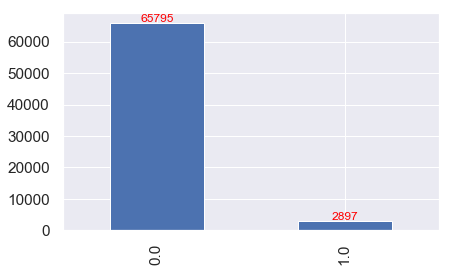

In [521]:
# To see the variations in the distribution of performance tag
fig, ax = plt.subplots()
merged_actual_df['Performance_Tag'].value_counts().plot(ax=ax, kind='bar')
#to make the label over the bars
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), 
            fontsize=12, color='red', ha='center', va='bottom')

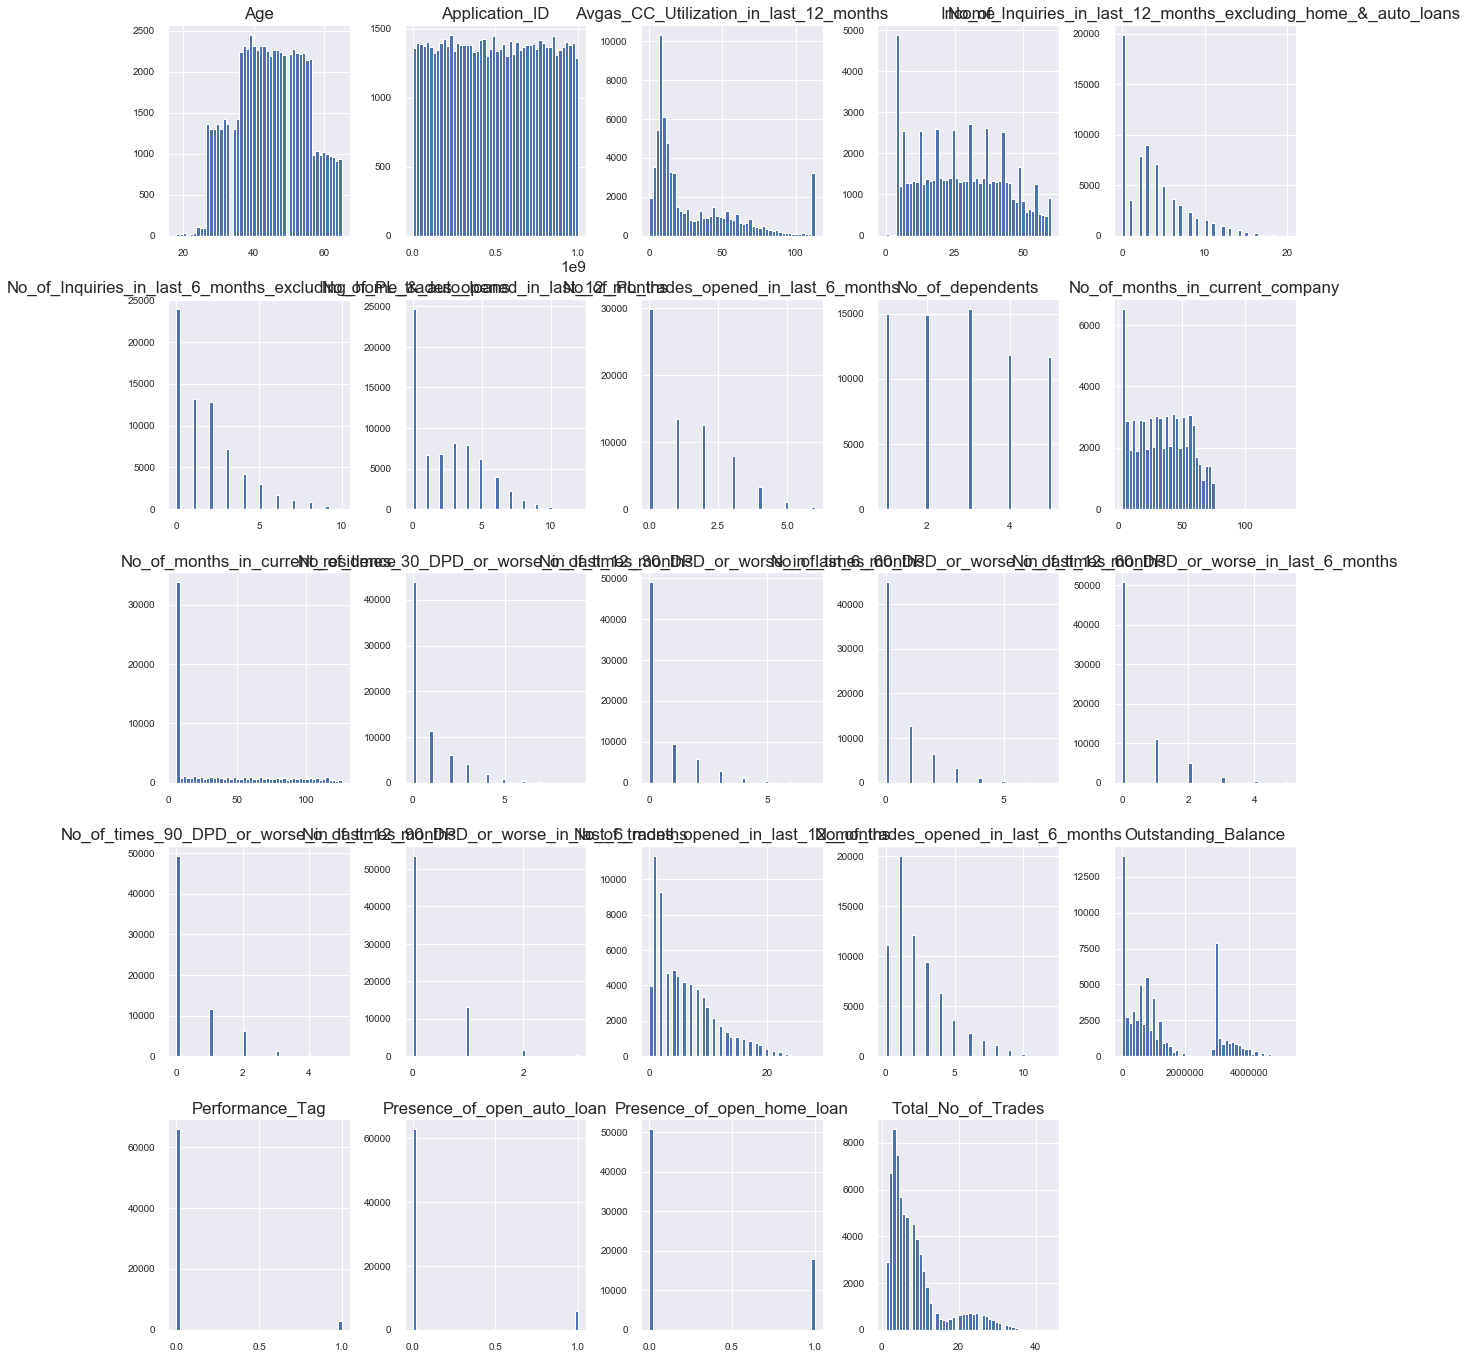

In [522]:
merged_actual_df.hist(figsize=(18, 24), bins=50, xlabelsize=10, ylabelsize=10);

The plot above shows the variation in the distribution of the values of each column in the data set.

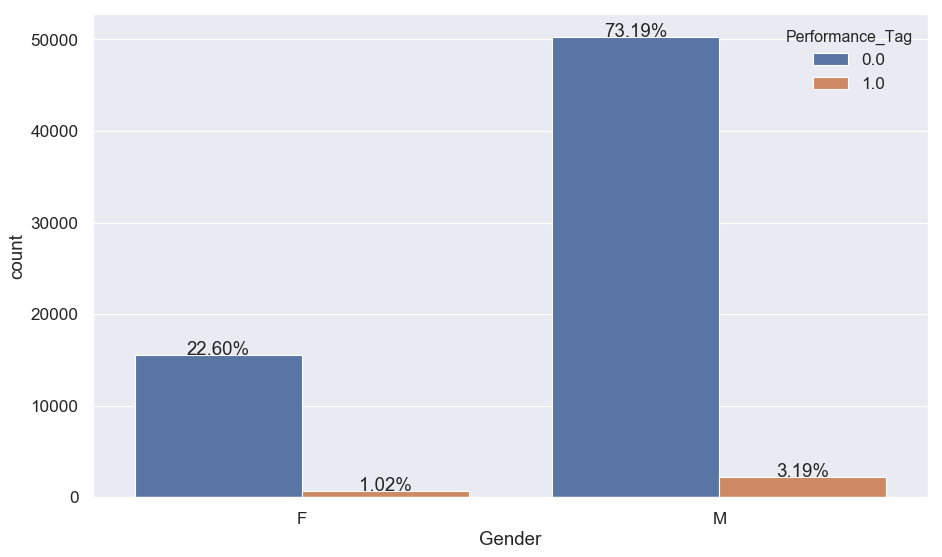

In [523]:
# Exploring the variable features of the CredXData
plt.figure(num=None, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
ax = sns.countplot(x="Gender",hue = "Performance_Tag", data=merged_actual_df)
total = float(len(merged_actual_df))
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2%}'.format(height/total),
            ha="center") 

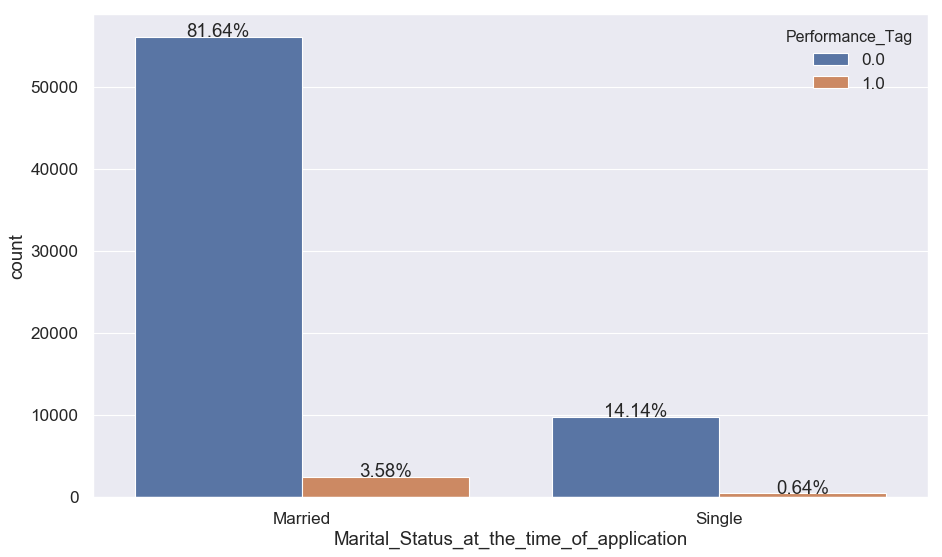

In [524]:
# Exploring the variable features of the CredXData
plt.figure(num=None, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
ax = sns.countplot(x="Marital_Status_at_the_time_of_application",hue = "Performance_Tag", data=merged_actual_df)
total = float(len(merged_actual_df))
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2%}'.format(height/total),
            ha="center") 

In [525]:
# Adding new cols for Age - univariate analysis (Age_Bucket)
merged_actual_df.loc[(merged_actual_df.Age >= 0) & (merged_actual_df.Age < 10), 'Age_Bucket'] = '0-9'  
merged_actual_df.loc[(merged_actual_df.Age >= 10) & (merged_actual_df.Age < 20), 'Age_Bucket'] = '10-19' 
merged_actual_df.loc[(merged_actual_df.Age >= 20) & (merged_actual_df.Age < 30), 'Age_Bucket'] = '20-29' 
merged_actual_df.loc[(merged_actual_df.Age >= 30) & (merged_actual_df.Age < 40), 'Age_Bucket'] = '30-39' 
merged_actual_df.loc[(merged_actual_df.Age >= 40) & (merged_actual_df.Age < 50), 'Age_Bucket'] = '40-49' 
merged_actual_df.loc[(merged_actual_df.Age >= 50) & (merged_actual_df.Age < 60), 'Age_Bucket'] = '50-59'
merged_actual_df.loc[(merged_actual_df.Age >= 60) & (merged_actual_df.Age < 70), 'Age_Bucket'] = '60-69'

merged_actual_df.loc[(merged_actual_df.Age >= 70), 'Age_Bucket'] = '70+'
merged_actual_df.loc[(merged_actual_df.Age < 0), 'Age_Bucket'] = 'NaN'

merged_actual_df.head()

Application_ID  Age Gender Marital_Status_at_the_time_of_application  No_of_dependents  Income     Education Profession Type_of_residence  No_of_months_in_current_residence  No_of_months_in_current_company  No_of_times_90_DPD_or_worse_in_last_6_months  No_of_times_60_DPD_or_worse_in_last_6_months  No_of_times_30_DPD_or_worse_in_last_6_months  No_of_times_90_DPD_or_worse_in_last_12_months  No_of_times_60_DPD_or_worse_in_last_12_months  No_of_times_30_DPD_or_worse_in_last_12_months  Avgas_CC_Utilization_in_last_12_months  No_of_trades_opened_in_last_6_months  No_of_trades_opened_in_last_12_months  No_of_PL_trades_opened_in_last_6_months  No_of_PL_trades_opened_in_last_12_months  No_of_Inquiries_in_last_6_months_excluding_home_&_auto_loans  No_of_Inquiries_in_last_12_months_excluding_home_&_auto_loans  Presence_of_open_home_loan  Outstanding_Balance  Total_No_of_Trades  Presence_of_open_auto_loan  Performance_Tag Age_Bucket
0       954457215   48      F                                   Married               2.0    40.0      Bachelor        SAL            Rented                                113                               56                                             0                                             0                                             0                                              0                                              0                                              0                                     4.0                                   1.0                                      2                                        0                                         0                                                  0                                                             0                                     1.0            2999395.0                   4                           0              0.0      40-49
1       432830445   31      M                                   Married               4.0    55.0  Professional    SE_PROF            Rented                                112                               46                                             0                                             0                                             0                                              0                                              0                                              0                                     3.0                                   1.0                                      2                                        0                                         0                                                  0                                                             0                                     0.0               3078.0                   5                           0              0.0      30-39
2       941387308   32      M                                    Single               2.0    46.0      Bachelor    SE_PROF            Rented                                104                               49                                             0                                             0                                             0                                              0                                              0                                              0                                     7.0                                   0.0                                      0                                        0                                         0                                                  0                                                             0                                     1.0            3004972.0                   2                           0              0.0      30-39
3       392161677   43      M                                   Married               1.0    53.0      Bachelor         SE            Rented                                 94                               53                                           

In [526]:
# Adding new cols for Income - univariate analysis (Income_Bucket)
merged_actual_df.loc[(merged_actual_df.Income >= 0) & (merged_actual_df.Income < 10), 'Income_Bucket'] = '0-9'  
merged_actual_df.loc[(merged_actual_df.Income >= 10) & (merged_actual_df.Income < 20), 'Income_Bucket'] = '10-19' 
merged_actual_df.loc[(merged_actual_df.Income >= 20) & (merged_actual_df.Income < 30), 'Income_Bucket'] = '20-29' 
merged_actual_df.loc[(merged_actual_df.Income >= 30) & (merged_actual_df.Income < 40), 'Income_Bucket'] = '30-39' 
merged_actual_df.loc[(merged_actual_df.Income >= 40) & (merged_actual_df.Income < 50), 'Income_Bucket'] = '40-49' 
merged_actual_df.loc[(merged_actual_df.Income >= 50) & (merged_actual_df.Income < 60), 'Income_Bucket'] = '50-59'

merged_actual_df.loc[(merged_actual_df.Income >= 60), 'Age_Bucket'] = '60+'
merged_actual_df.loc[(merged_actual_df.Income < 0), 'Age_Bucket'] = 'NaN'

merged_actual_df.head()

Application_ID  Age Gender Marital_Status_at_the_time_of_application  No_of_dependents  Income     Education Profession Type_of_residence  No_of_months_in_current_residence  No_of_months_in_current_company  No_of_times_90_DPD_or_worse_in_last_6_months  No_of_times_60_DPD_or_worse_in_last_6_months  No_of_times_30_DPD_or_worse_in_last_6_months  No_of_times_90_DPD_or_worse_in_last_12_months  No_of_times_60_DPD_or_worse_in_last_12_months  No_of_times_30_DPD_or_worse_in_last_12_months  Avgas_CC_Utilization_in_last_12_months  No_of_trades_opened_in_last_6_months  No_of_trades_opened_in_last_12_months  No_of_PL_trades_opened_in_last_6_months  No_of_PL_trades_opened_in_last_12_months  No_of_Inquiries_in_last_6_months_excluding_home_&_auto_loans  No_of_Inquiries_in_last_12_months_excluding_home_&_auto_loans  Presence_of_open_home_loan  Outstanding_Balance  Total_No_of_Trades  Presence_of_open_auto_loan  Performance_Tag Age_Bucket Income_Bucket
0       954457215   48      F                                   Married               2.0    40.0      Bachelor        SAL            Rented                                113                               56                                             0                                             0                                             0                                              0                                              0                                              0                                     4.0                                   1.0                                      2                                        0                                         0                                                  0                                                             0                                     1.0            2999395.0                   4                           0              0.0      40-49         40-49
1       432830445   31      M                                   Married               4.0    55.0  Professional    SE_PROF            Rented                                112                               46                                             0                                             0                                             0                                              0                                              0                                              0                                     3.0                                   1.0                                      2                                        0                                         0                                                  0                                                             0                                     0.0               3078.0                   5                           0              0.0      30-39         50-59
2       941387308   32      M                                    Single               2.0    46.0      Bachelor    SE_PROF            Rented                                104                               49                                             0                                             0                                             0                                              0                                              0                                              0                                     7.0                                   0.0                                      0                                        0                                         0                                                  0                                                             0                                     1.0            3004972.0                   2                           0              0.0      30-39         40-49
3       392161677   43      M                                   Married               1.0    53.0      Bachelor         SE            Rented                                 94                    

In [527]:
merged_actual_df.shape

(68692, 31)

In [528]:
#Descriptive Statistics for all variables
merged_actual_df.describe()

Application_ID           Age  No_of_dependents        Income  No_of_months_in_current_residence  No_of_months_in_current_company  No_of_times_90_DPD_or_worse_in_last_6_months  No_of_times_60_DPD_or_worse_in_last_6_months  No_of_times_30_DPD_or_worse_in_last_6_months  No_of_times_90_DPD_or_worse_in_last_12_months  No_of_times_60_DPD_or_worse_in_last_12_months  No_of_times_30_DPD_or_worse_in_last_12_months  Avgas_CC_Utilization_in_last_12_months  No_of_trades_opened_in_last_6_months  No_of_trades_opened_in_last_12_months  No_of_PL_trades_opened_in_last_6_months  No_of_PL_trades_opened_in_last_12_months  No_of_Inquiries_in_last_6_months_excluding_home_&_auto_loans  No_of_Inquiries_in_last_12_months_excluding_home_&_auto_loans  Presence_of_open_home_loan  Outstanding_Balance  Total_No_of_Trades  Presence_of_open_auto_loan  Performance_Tag
count    6.869200e+04  68692.000000      68692.000000  68692.000000                       68692.000000                     68692.000000                                  68692.000000                                  68692.000000                                  68692.000000                                   68692.000000                                   68692.000000                                   68692.000000                            68692.000000                          68692.000000                           68692.000000                             68692.000000                              68692.000000                                       68692.000000                                                  68692.000000                            68692.000000         6.869200e+04        68692.000000                68692.000000     68692.000000
mean     4.992697e+08     45.043659          2.859416     27.420588                          34.540063                        34.233069                                      0.252417                                      0.396800                                      0.530251                                       0.420340                                       0.610173                                       0.742284                               29.299191                              2.320416                               5.874367                                 1.208147                                  2.400017                                           1.785171                                                      3.574943                                0.261937         1.265703e+06            8.301971                    0.086080         0.042174
std      2.886666e+08      9.877233          1.385444     15.449086                          36.775009                        20.358440                                      0.508053                                      0.774867                                      1.004062                                       0.766078                                       1.025105                                       1.247079                               29.526946                              2.079401                               5.085783                                 1.355040                                  2.424196                                           1.989230                                                      3.618916                                0.439692         1.286133e+06            7.140774                    0.280484         0.200987
min      1.004500e+05     18.000000          1.000000      0.000000                           6.000000                         3.000000                                      0.000000                                      0.000000                                      0.000000                                       0.000000                                       0.000000                                       0.000000                                0.000000                              0.000000                               0.000000                                 0.000000                   

In [529]:
merged_actual_df_Defaulter = merged_actual_df[merged_actual_df['Performance_Tag']==1]
merged_actual_df_Defaulter.shape

(2897, 31)

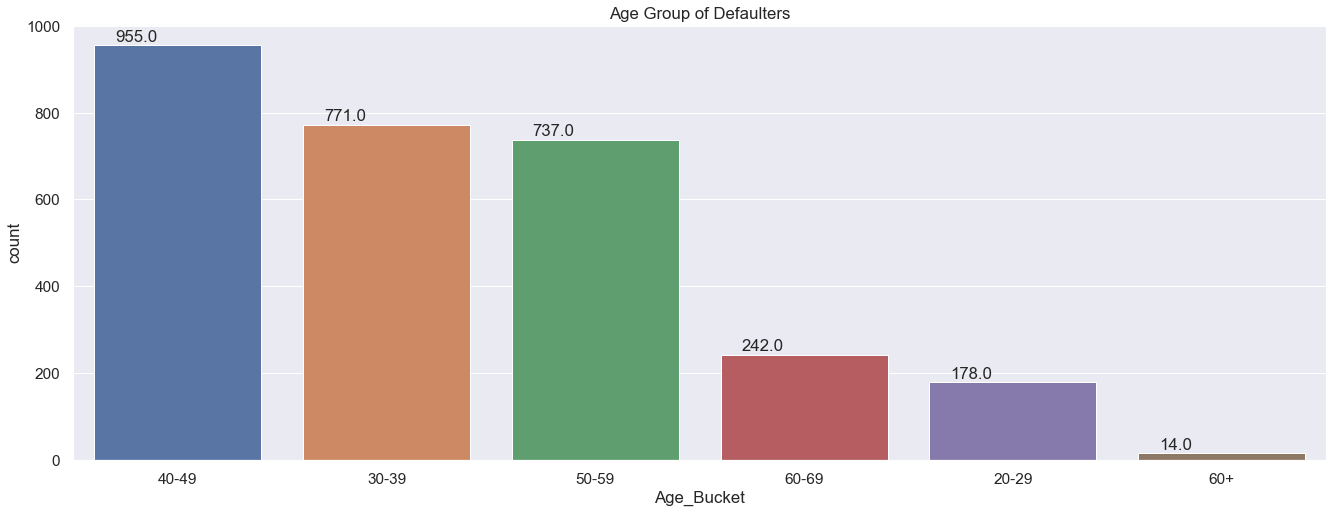

In [530]:
# Graph plot for the Age group having the highest defaulters.
plt.figure(figsize=(20, 8))
plt.title('Age Group of Defaulters')
ax = sns.countplot(merged_actual_df_Defaulter.Age_Bucket, order=merged_actual_df_Defaulter.Age_Bucket.value_counts().index);

for p in ax.patches:
        ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+10))

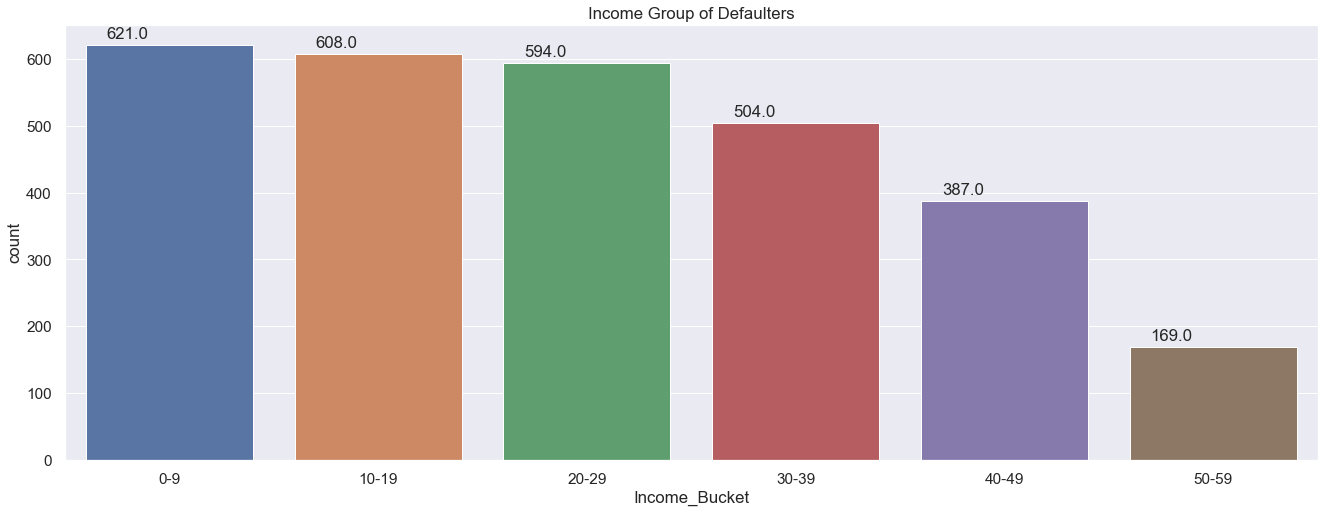

In [531]:
# Graph plot for the Income group having the highest defaulters.
plt.figure(figsize=(20, 8))
plt.title('Income Group of Defaulters')
ax = sns.countplot(merged_actual_df_Defaulter.Income_Bucket, order=merged_actual_df_Defaulter.Income_Bucket.value_counts().index);

for p in ax.patches:
    ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+10))

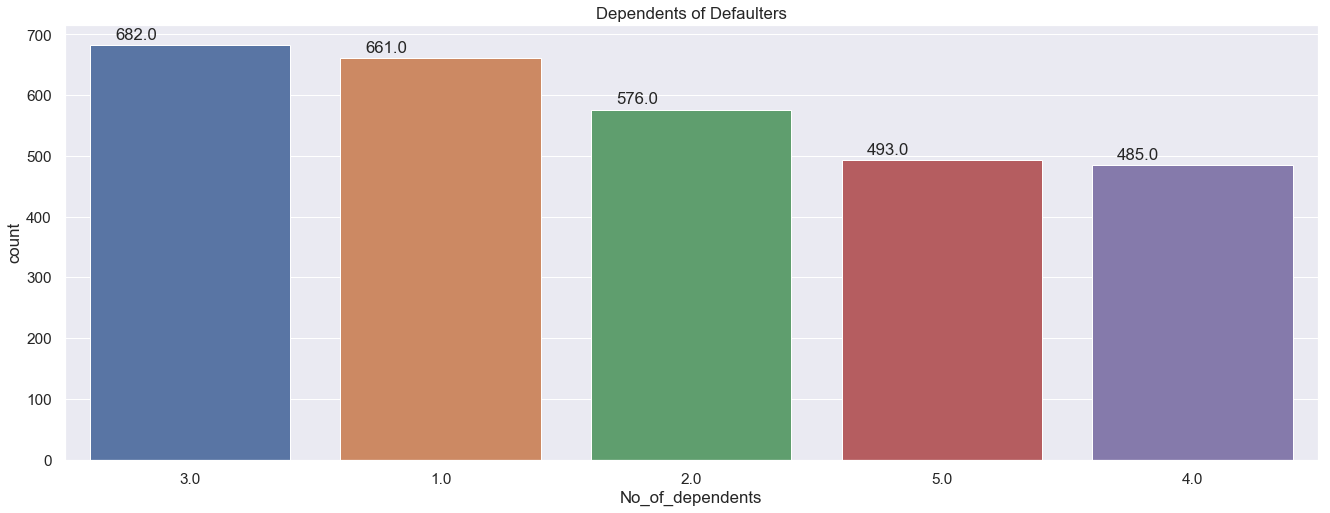

In [532]:
# Graph plot for the people with no of dependants for defaulters.
plt.figure(figsize=(20, 8))
plt.title('Dependents of Defaulters')
ax = sns.countplot(merged_actual_df_Defaulter["No_of_dependents"], order=merged_actual_df_Defaulter["No_of_dependents"].value_counts().index);

for p in ax.patches:
    ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+10))

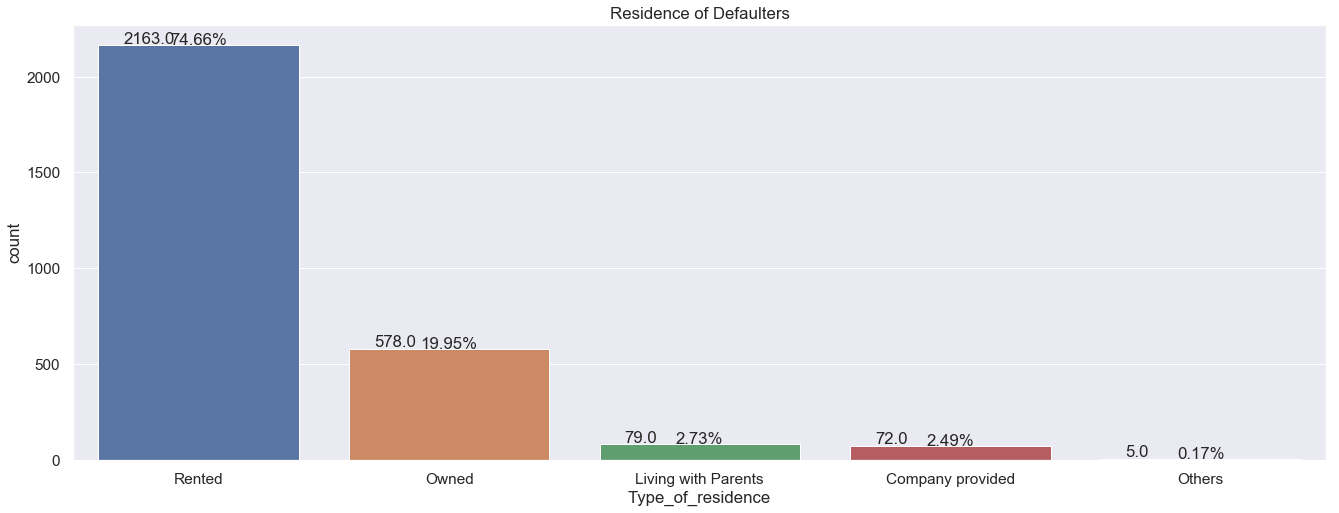

In [533]:
# Graph plot for the Residence of defaulters.
plt.figure(figsize=(20, 8))
plt.title('Residence of Defaulters')
ax = sns.countplot(merged_actual_df_Defaulter["Type_of_residence"], order=merged_actual_df_Defaulter["Type_of_residence"].value_counts().index);

for p in ax.patches:
    ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+10))
    
#to show the percentage as label
total = float(len(merged_actual_df_Defaulter))
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2%}'.format(height/total),
            ha="center") 

From the above plot it is very evident that most of the defaulters stay ina arented house.

In [534]:
# correlation matrix
cor = merged_actual_df_Defaulter.corr()
cor

Application_ID       Age  No_of_dependents    Income  No_of_months_in_current_residence  No_of_months_in_current_company  No_of_times_90_DPD_or_worse_in_last_6_months  No_of_times_60_DPD_or_worse_in_last_6_months  No_of_times_30_DPD_or_worse_in_last_6_months  No_of_times_90_DPD_or_worse_in_last_12_months  No_of_times_60_DPD_or_worse_in_last_12_months  No_of_times_30_DPD_or_worse_in_last_12_months  Avgas_CC_Utilization_in_last_12_months  No_of_trades_opened_in_last_6_months  No_of_trades_opened_in_last_12_months  No_of_PL_trades_opened_in_last_6_months  No_of_PL_trades_opened_in_last_12_months  No_of_Inquiries_in_last_6_months_excluding_home_&_auto_loans  No_of_Inquiries_in_last_12_months_excluding_home_&_auto_loans  Presence_of_open_home_loan  Outstanding_Balance  Total_No_of_Trades  Presence_of_open_auto_loan  Performance_Tag
Application_ID                                            1.000000 -0.014773         -0.031847 -0.000915                           0.027587                        -0.003034                                     -0.004913                                      0.002295                                      0.005389                                       0.003774                                      -0.000581                                       0.007789                                0.015297                              0.021133                               0.023495                                 0.018821                                  0.022300                                           0.017933                                                      0.015870                               -0.030201            -0.024057            0.023100                   -0.018194              NaN
Age                                                      -0.014773  1.000000          0.188015  0.070073                           0.006629                        -0.003855                                     -0.016493                                     -0.026233                                     -0.035976                                      -0.023872                                      -0.033317                                      -0.042222                                0.000008                             -0.020306                              -0.016674                                -0.023620                                 -0.019677                                          -0.001889                                                      0.004552                                0.012005             0.006627           -0.007567                    0.004907              NaN
No_of_dependents                                         -0.031847  0.188015          1.000000 -0.006005                           0.010793                        -0.008741                                      0.012738                                      0.017626                                      0.010511                                       0.008417                                       0.019741                                       0.006720                                0.022109                             -0.024662                              -0.035282                                -0.036846                                 -0.028435                                          -0.024175                                                     -0.030719                                0.028705             0.019263           -0.021025                   -0.002552              NaN
Income                                                   -0.000915  0.070073         -0.006005  1.000000                          -0.156691                        -0.056417                                     -0.205310                                     -0.220986                                     -0.233026                                      -0.224064                                      -0.229859                                      -0.232390                               -0.150

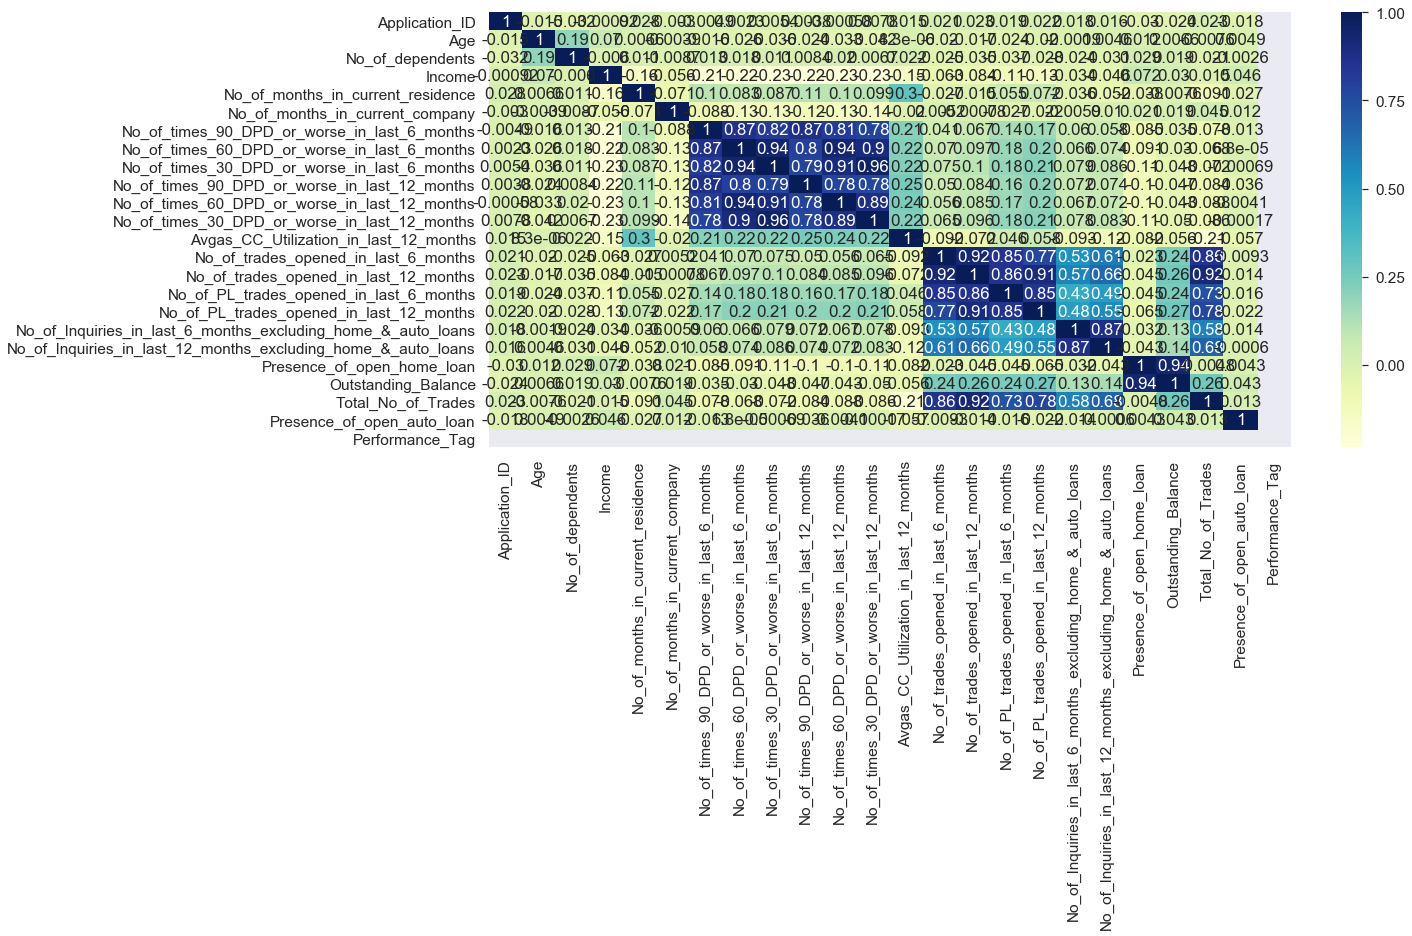

In [535]:
# plotting correlations on a heatmap

# figure size
plt.figure(figsize=(16,8))

# heatmap
sns.heatmap(cor, cmap="YlGnBu", annot=True)
plt.show()


From the graph, we make out the highly corelated variable which affects the model in it decision making.

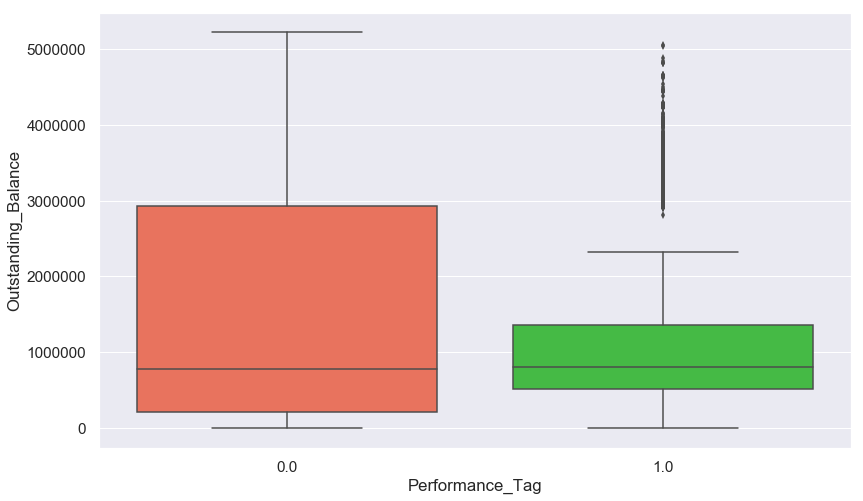

In [536]:
ax = plt.subplots(figsize=(12, 8))
c = ["tomato","limegreen"]
#subtitle('Outstanding Balance',fontsize=18)
sns.set_style("whitegrid")
sns.boxplot(merged_actual_df["Performance_Tag"],merged_actual_df["Outstanding_Balance"],palette=c)


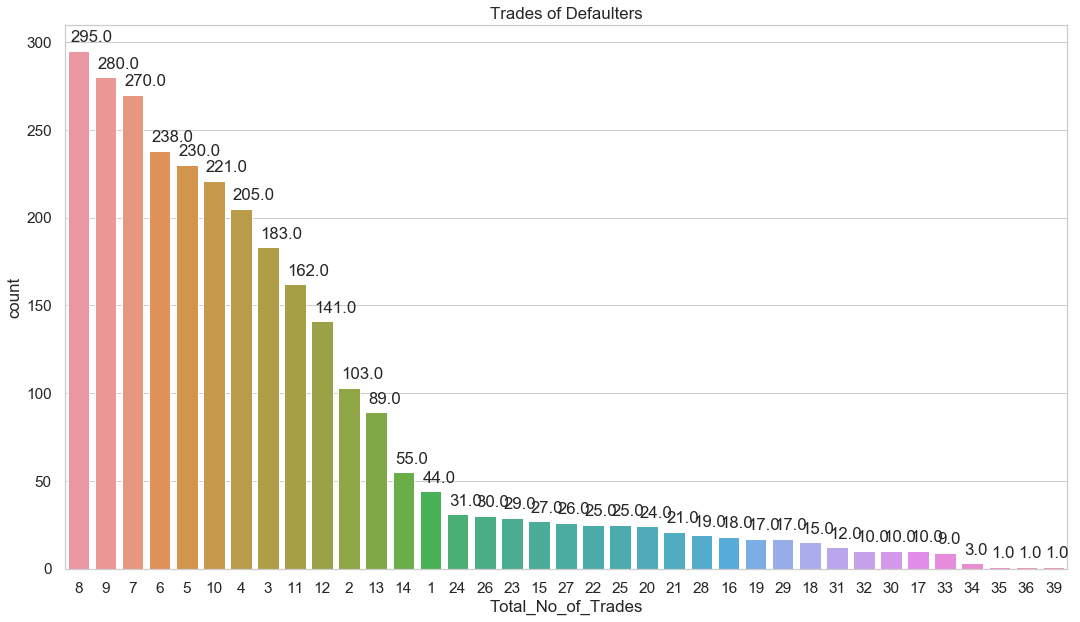

In [537]:
#plot the graph for the No of Trades done by defaulters.
plt.figure(figsize=(16, 10))
plt.title('Trades of Defaulters')
ax = sns.countplot(merged_actual_df_Defaulter["Total_No_of_Trades"], order=merged_actual_df_Defaulter["Total_No_of_Trades"].value_counts().index);

for p in ax.patches:
    ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+5))


From the above plot, it is clear that the `No of Trades` done between `4-10` has more probability of getting a defaulter. As most of the defaulters have made a transaction of 4-10 trades.

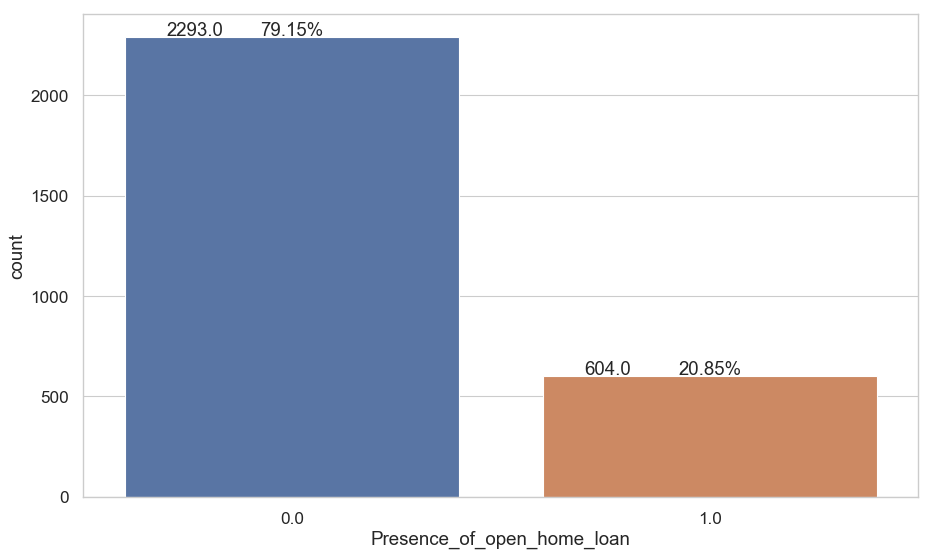

In [538]:
plt.figure(num=None, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
ax = sns.countplot(x="Presence_of_open_home_loan", data=merged_actual_df_Defaulter)
#plt.show()

for p in ax.patches:
    ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+5))
total = float(len(merged_actual_df_Defaulter))
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2%}'.format(height/total),
            ha="center") 

Around 80% of the defaulters does not have `Home Loan` which means the applicants taking home loan has less chances of being a defaulter.
The same can be observed in below case as well the where most of the defaulters does not have any open auto loan.
This can signify that opting for auto deductions can reduce the chances of any applicant being a defaulter.

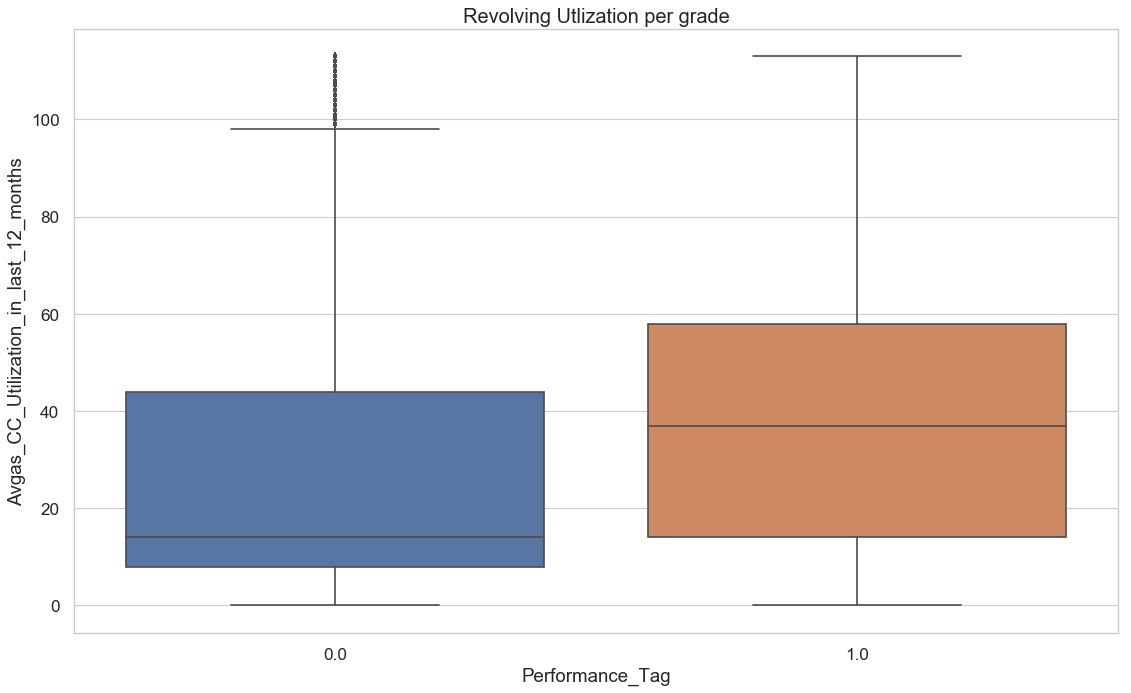

In [539]:
plt.figure(num=None, figsize=(15,10),dpi=80)
plt.title("Revolving Utlization per grade", fontsize=18)
sns.boxplot(x='Performance_Tag', y='Avgas_CC_Utilization_in_last_12_months', data=merged_actual_df)
plt.show()

For the defaulters case, the mean of avg CC utilisation lies around 36, which is more than the mean of the non-defaulters case

### Merge woe demographic and woe credit bureau data

In [540]:
demo_woe_data.shape

(69722, 12)

In [541]:
credit_bureau_woe_data.shape

(69867, 19)

In [542]:
demo_woe_data.head()

Application_ID   woe_Age  woe_Education  woe_Gender  woe_Income  woe_Marital_Status_at_the_time_of_application  woe_No_of_dependents  woe_No_of_months_in_current_company  woe_No_of_months_in_current_residence  woe_Profession  woe_Type_of_residence  Performance_Tag
0       954457215  0.007596      -0.014907   -0.032933    0.245612                                       0.004087             -0.005845                             0.123411                               -0.20823        0.028074               0.004056              0.0
1       432830445 -0.033484       0.017725    0.010391    0.263833                                       0.004087              0.011748                             0.072353                               -0.20823        0.014157               0.004056              0.0
2       941387308 -0.033484      -0.014907    0.010391    0.263833                                      -0.022694             -0.005845                             0.072353                               -0.20823        0.014157               0.004056              0.0
3       392161677  0.007596      -0.014907    0.010391    0.263833                                       0.004087             -0.005845                             0.123411                               -0.20823       -0.091452               0.004056              0.0
4       182011211 -0.033484       0.017725   -0.032933    0.245612                                       0.004087              0.011748                             0.072353                               -0.20823        0.028074               0.004056              0.0

In [543]:
credit_bureau_woe_data.head()

Application_ID  woe_Avgas_CC_Utilization_in_last_12_months  woe_No_of_Inquiries_in_last_12_months_excluding_home_&_auto_loans  woe_No_of_Inquiries_in_last_6_months_excluding_home_&_auto_loans  woe_No_of_PL_trades_opened_in_last_12_months  woe_No_of_PL_trades_opened_in_last_6_months  woe_No_of_times_30_DPD_or_worse_in_last_12_months  woe_No_of_times_30_DPD_or_worse_in_last_6_months  woe_No_of_times_60_DPD_or_worse_in_last_12_months  woe_No_of_times_60_DPD_or_worse_in_last_6_months  woe_No_of_times_90_DPD_or_worse_in_last_12_months  woe_No_of_times_90_DPD_or_worse_in_last_6_months  woe_No_of_trades_opened_in_last_12_months  woe_No_of_trades_opened_in_last_6_months  woe_Outstanding_Balance  woe_Presence_of_open_auto_loan  woe_Presence_of_open_home_loan  woe_Total_No_of_Trades  Performance_Tag
0       954457215                                    0.799246                                           0.828596                                                           0.319569                                                     0.453449                                     0.314271                                           0.269272                                          0.198371                                           0.200955                                          0.121316                                           0.133954                                          0.036804                                   0.865398                                  0.270556                -0.087933                       -0.011997                       -0.001235                0.686484              0.0
1       432830445                                    0.799246                                           0.828596                                                           0.319569                                                     0.453449                                     0.314271                                           0.269272                                          0.198371                                           0.200955                                          0.121316                                           0.133954                                          0.036804                                   0.865398                                  0.270556                 0.092939                       -0.011997                       -0.001235               -0.210878              0.0
2       941387308                                    0.799246                                           0.828596                                                           0.319569                                                     0.453449                                     0.314271                                           0.269272                                          0.198371                                           0.200955                                          0.121316                                           0.133954                                          0.036804                                   0.865398                                  0.270556                -0.087933                       -0.011997                       -0.001235                0.686484              0.0
3       392161677                                    0.574668                                           0.828596                                                           0.319569                                                     0.453449                                     0.314271                                           0.269272                                          0.198371                                           0.200955                                          0.121316                                           0.133954                                          0.036804                                   0.865398                                  0.270556                -0.087933                        0.138547                       -0.001235                0.686484 

In [544]:
merged_woe_df = pd.merge(left=demo_woe_data,right=credit_bureau_woe_data,on = 'Application_ID',how='inner')
merged_woe_df.head()

Application_ID   woe_Age  woe_Education  woe_Gender  woe_Income  woe_Marital_Status_at_the_time_of_application  woe_No_of_dependents  woe_No_of_months_in_current_company  woe_No_of_months_in_current_residence  woe_Profession  woe_Type_of_residence  Performance_Tag_x  woe_Avgas_CC_Utilization_in_last_12_months  woe_No_of_Inquiries_in_last_12_months_excluding_home_&_auto_loans  woe_No_of_Inquiries_in_last_6_months_excluding_home_&_auto_loans  woe_No_of_PL_trades_opened_in_last_12_months  woe_No_of_PL_trades_opened_in_last_6_months  woe_No_of_times_30_DPD_or_worse_in_last_12_months  woe_No_of_times_30_DPD_or_worse_in_last_6_months  woe_No_of_times_60_DPD_or_worse_in_last_12_months  woe_No_of_times_60_DPD_or_worse_in_last_6_months  woe_No_of_times_90_DPD_or_worse_in_last_12_months  woe_No_of_times_90_DPD_or_worse_in_last_6_months  woe_No_of_trades_opened_in_last_12_months  woe_No_of_trades_opened_in_last_6_months  woe_Outstanding_Balance  woe_Presence_of_open_auto_loan  woe_Presence_of_open_home_loan  woe_Total_No_of_Trades  Performance_Tag_y
0       954457215  0.007596      -0.014907   -0.032933    0.245612                                       0.004087             -0.005845                             0.123411                               -0.20823        0.028074               0.004056                0.0                                    0.799246                                           0.828596                                                           0.319569                                                     0.453449                                     0.314271                                           0.269272                                          0.198371                                           0.200955                                          0.121316                                           0.133954                                          0.036804                                   0.865398                                  0.270556                -0.087933                       -0.011997                       -0.001235                0.686484                0.0
1       432830445 -0.033484       0.017725    0.010391    0.263833                                       0.004087              0.011748                             0.072353                               -0.20823        0.014157               0.004056                0.0                                    0.799246                                           0.828596                                                           0.319569                                                     0.453449                                     0.314271                                           0.269272                                          0.198371                                           0.200955                                          0.121316                                           0.133954                                          0.036804                                   0.865398                                  0.270556                 0.092939                       -0.011997                       -0.001235               -0.210878                0.0
2       941387308 -0.033484      -0.014907    0.010391    0.263833                                      -0.022694             -0.005845                             0.072353                               -0.20823        0.014157               0.004056                0.0                                    0.799246                                           0.828596                                                           0.319569                                                     0.453449                                     0.314271                                           0.269272                                          0.198371                                           0.200955                                          0.121316                                           0.133954                                       

In [545]:
merged_woe_df.shape

(69722, 30)

In [546]:
merged_woe_df = merged_woe_df.drop('Performance_Tag_x',axis=1)
merged_woe_df.rename({'Performance_Tag_y':'Performance_Tag'},axis=1,inplace=True)

In [547]:
merged_woe_df.head()

Application_ID   woe_Age  woe_Education  woe_Gender  woe_Income  woe_Marital_Status_at_the_time_of_application  woe_No_of_dependents  woe_No_of_months_in_current_company  woe_No_of_months_in_current_residence  woe_Profession  woe_Type_of_residence  woe_Avgas_CC_Utilization_in_last_12_months  woe_No_of_Inquiries_in_last_12_months_excluding_home_&_auto_loans  woe_No_of_Inquiries_in_last_6_months_excluding_home_&_auto_loans  woe_No_of_PL_trades_opened_in_last_12_months  woe_No_of_PL_trades_opened_in_last_6_months  woe_No_of_times_30_DPD_or_worse_in_last_12_months  woe_No_of_times_30_DPD_or_worse_in_last_6_months  woe_No_of_times_60_DPD_or_worse_in_last_12_months  woe_No_of_times_60_DPD_or_worse_in_last_6_months  woe_No_of_times_90_DPD_or_worse_in_last_12_months  woe_No_of_times_90_DPD_or_worse_in_last_6_months  woe_No_of_trades_opened_in_last_12_months  woe_No_of_trades_opened_in_last_6_months  woe_Outstanding_Balance  woe_Presence_of_open_auto_loan  woe_Presence_of_open_home_loan  woe_Total_No_of_Trades  Performance_Tag
0       954457215  0.007596      -0.014907   -0.032933    0.245612                                       0.004087             -0.005845                             0.123411                               -0.20823        0.028074               0.004056                                    0.799246                                           0.828596                                                           0.319569                                                     0.453449                                     0.314271                                           0.269272                                          0.198371                                           0.200955                                          0.121316                                           0.133954                                          0.036804                                   0.865398                                  0.270556                -0.087933                       -0.011997                       -0.001235                0.686484              0.0
1       432830445 -0.033484       0.017725    0.010391    0.263833                                       0.004087              0.011748                             0.072353                               -0.20823        0.014157               0.004056                                    0.799246                                           0.828596                                                           0.319569                                                     0.453449                                     0.314271                                           0.269272                                          0.198371                                           0.200955                                          0.121316                                           0.133954                                          0.036804                                   0.865398                                  0.270556                 0.092939                       -0.011997                       -0.001235               -0.210878              0.0
2       941387308 -0.033484      -0.014907    0.010391    0.263833                                      -0.022694             -0.005845                             0.072353                               -0.20823        0.014157               0.004056                                    0.799246                                           0.828596                                                           0.319569                                                     0.453449                                     0.314271                                           0.269272                                          0.198371                                           0.200955                                          0.121316                                           0.133954                                          0.036804                                   0.865398                            

### Data Preparation for WOE data

In [548]:
print("Top Absolute Correlations")
print(get_top_abs_correlations(merged_woe_df, 10))

Top Absolute Correlations
woe_No_of_trades_opened_in_last_12_months                          woe_Total_No_of_Trades                               0.871623
woe_No_of_times_30_DPD_or_worse_in_last_12_months                  woe_No_of_times_30_DPD_or_worse_in_last_6_months     0.846675
woe_No_of_PL_trades_opened_in_last_6_months                        woe_No_of_trades_opened_in_last_6_months             0.804954
woe_No_of_times_30_DPD_or_worse_in_last_6_months                   woe_No_of_times_60_DPD_or_worse_in_last_6_months     0.795197
woe_No_of_Inquiries_in_last_12_months_excluding_home_&_auto_loans  woe_No_of_trades_opened_in_last_12_months            0.777209
woe_No_of_PL_trades_opened_in_last_12_months                       woe_No_of_PL_trades_opened_in_last_6_months          0.776750
woe_No_of_times_30_DPD_or_worse_in_last_6_months                   woe_No_of_times_60_DPD_or_worse_in_last_12_months    0.775766
woe_No_of_times_60_DPD_or_worse_in_last_12_months                  woe_

In [549]:
# Removing columns with high correlation
cols_to_drop = ['woe_No_of_Inquiries_in_last_6_months_excluding_home_&_auto_loans','woe_No_of_times_30_DPD_or_worse_in_last_6_months',\
                'woe_No_of_times_60_DPD_or_worse_in_last_12_months', 'woe_No_of_trades_opened_in_last_12_months',\
                'woe_No_of_trades_opened_in_last_6_months','woe_Total_No_of_Trades','woe_No_of_PL_trades_opened_in_last_6_months',\
               'woe_No_of_times_60_DPD_or_worse_in_last_6_months']
cols_to_drop = ['woe_No_of_trades_opened_in_last_12_months','woe_No_of_times_30_DPD_or_worse_in_last_6_months','woe_No_of_trades_opened_in_last_6_months']
merged_woe_df = merged_woe_df.drop(cols_to_drop,axis=1)

In [550]:
merged_woe_df.head()

Application_ID   woe_Age  woe_Education  woe_Gender  woe_Income  woe_Marital_Status_at_the_time_of_application  woe_No_of_dependents  woe_No_of_months_in_current_company  woe_No_of_months_in_current_residence  woe_Profession  woe_Type_of_residence  woe_Avgas_CC_Utilization_in_last_12_months  woe_No_of_Inquiries_in_last_12_months_excluding_home_&_auto_loans  woe_No_of_Inquiries_in_last_6_months_excluding_home_&_auto_loans  woe_No_of_PL_trades_opened_in_last_12_months  woe_No_of_PL_trades_opened_in_last_6_months  woe_No_of_times_30_DPD_or_worse_in_last_12_months  woe_No_of_times_60_DPD_or_worse_in_last_12_months  woe_No_of_times_60_DPD_or_worse_in_last_6_months  woe_No_of_times_90_DPD_or_worse_in_last_12_months  woe_No_of_times_90_DPD_or_worse_in_last_6_months  woe_Outstanding_Balance  woe_Presence_of_open_auto_loan  woe_Presence_of_open_home_loan  woe_Total_No_of_Trades  Performance_Tag
0       954457215  0.007596      -0.014907   -0.032933    0.245612                                       0.004087             -0.005845                             0.123411                               -0.20823        0.028074               0.004056                                    0.799246                                           0.828596                                                           0.319569                                                     0.453449                                     0.314271                                           0.269272                                           0.200955                                          0.121316                                           0.133954                                          0.036804                -0.087933                       -0.011997                       -0.001235                0.686484              0.0
1       432830445 -0.033484       0.017725    0.010391    0.263833                                       0.004087              0.011748                             0.072353                               -0.20823        0.014157               0.004056                                    0.799246                                           0.828596                                                           0.319569                                                     0.453449                                     0.314271                                           0.269272                                           0.200955                                          0.121316                                           0.133954                                          0.036804                 0.092939                       -0.011997                       -0.001235               -0.210878              0.0
2       941387308 -0.033484      -0.014907    0.010391    0.263833                                      -0.022694             -0.005845                             0.072353                               -0.20823        0.014157               0.004056                                    0.799246                                           0.828596                                                           0.319569                                                     0.453449                                     0.314271                                           0.269272                                           0.200955                                          0.121316                                           0.133954                                          0.036804                -0.087933                       -0.011997                       -0.001235                0.686484              0.0
3       392161677  0.007596      -0.014907    0.010391    0.263833                                       0.004087             -0.005845                             0.123411                               -0.20823       -0.091452               0.004056                                    0.574668                                           0.828596                                                  

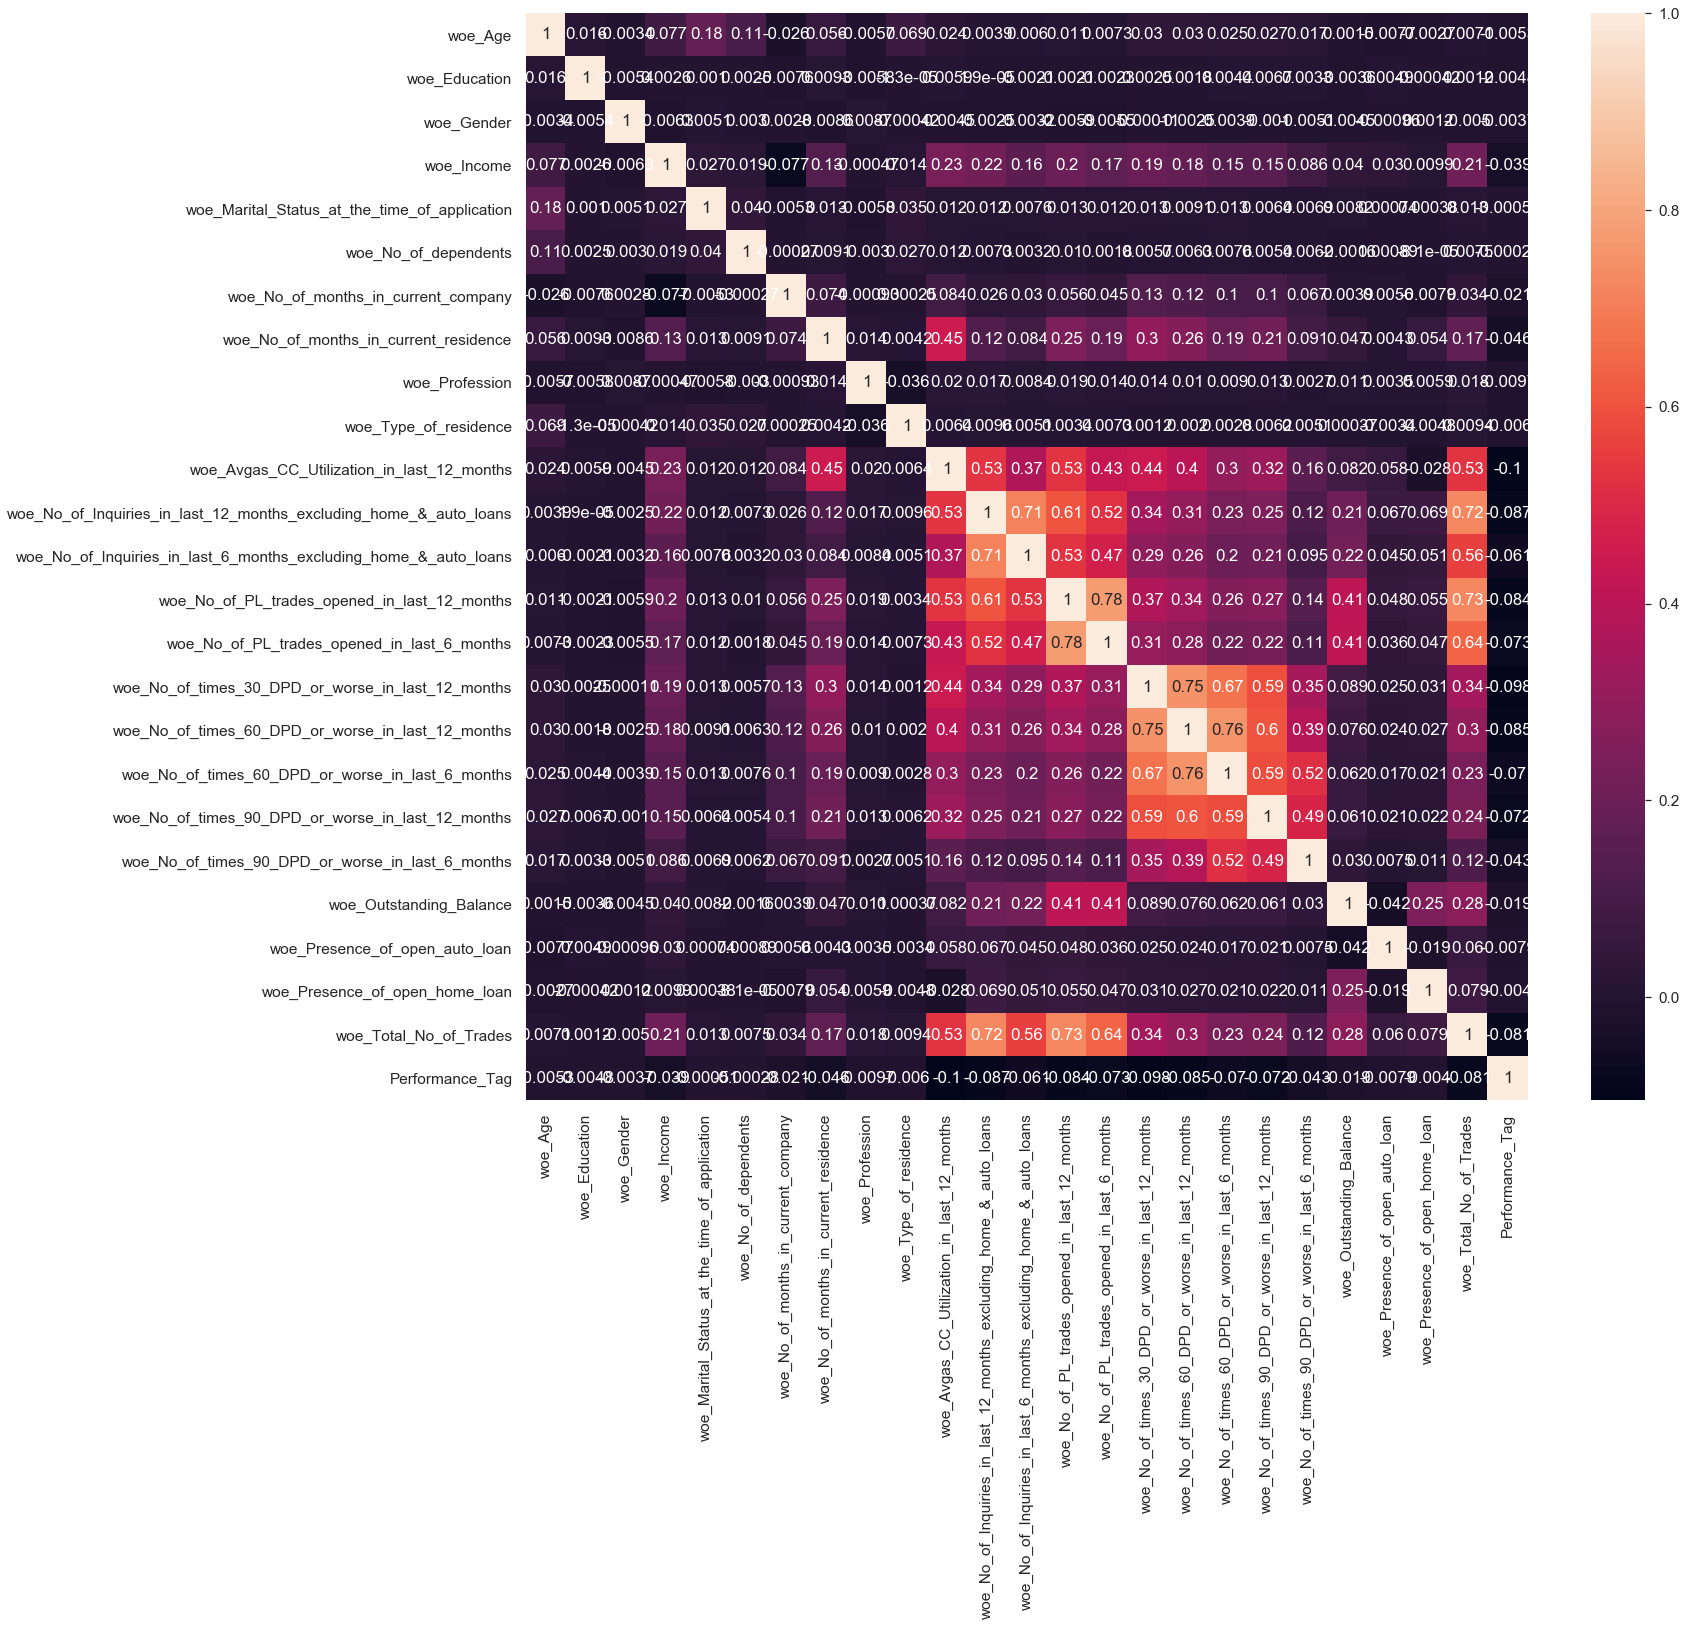

In [551]:
plt.figure(figsize=(20,20))
sns.heatmap(merged_woe_df.drop('Application_ID',axis=1).corr(), annot=True)
plt.show()

### Model building on WOE merged data :

In [552]:
merged_woe_df.shape

(69722, 26)

In [553]:
X = merged_woe_df.drop(['Application_ID','Performance_Tag'],axis=1)
y = merged_woe_df['Performance_Tag']

In [554]:
X.shape

(69722, 24)

In [555]:
X.head()

woe_Age  woe_Education  woe_Gender  woe_Income  woe_Marital_Status_at_the_time_of_application  woe_No_of_dependents  woe_No_of_months_in_current_company  woe_No_of_months_in_current_residence  woe_Profession  woe_Type_of_residence  woe_Avgas_CC_Utilization_in_last_12_months  woe_No_of_Inquiries_in_last_12_months_excluding_home_&_auto_loans  woe_No_of_Inquiries_in_last_6_months_excluding_home_&_auto_loans  woe_No_of_PL_trades_opened_in_last_12_months  woe_No_of_PL_trades_opened_in_last_6_months  woe_No_of_times_30_DPD_or_worse_in_last_12_months  woe_No_of_times_60_DPD_or_worse_in_last_12_months  woe_No_of_times_60_DPD_or_worse_in_last_6_months  woe_No_of_times_90_DPD_or_worse_in_last_12_months  woe_No_of_times_90_DPD_or_worse_in_last_6_months  woe_Outstanding_Balance  woe_Presence_of_open_auto_loan  woe_Presence_of_open_home_loan  woe_Total_No_of_Trades
0  0.007596      -0.014907   -0.032933    0.245612                                       0.004087             -0.005845                             0.123411                               -0.20823        0.028074               0.004056                                    0.799246                                           0.828596                                                           0.319569                                                     0.453449                                     0.314271                                           0.269272                                           0.200955                                          0.121316                                           0.133954                                          0.036804                -0.087933                       -0.011997                       -0.001235                0.686484
1 -0.033484       0.017725    0.010391    0.263833                                       0.004087              0.011748                             0.072353                               -0.20823        0.014157               0.004056                                    0.799246                                           0.828596                                                           0.319569                                                     0.453449                                     0.314271                                           0.269272                                           0.200955                                          0.121316                                           0.133954                                          0.036804                 0.092939                       -0.011997                       -0.001235               -0.210878
2 -0.033484      -0.014907    0.010391    0.263833                                      -0.022694             -0.005845                             0.072353                               -0.20823        0.014157               0.004056                                    0.799246                                           0.828596                                                           0.319569                                                     0.453449                                     0.314271                                           0.269272                                           0.200955                                          0.121316                                           0.133954                                          0.036804                -0.087933                       -0.011997                       -0.001235                0.686484
3  0.007596      -0.014907    0.010391    0.263833                                       0.004087             -0.005845                             0.123411                               -0.20823       -0.091452               0.004056                                    0.574668                                           0.828596                                                           0.319569                                                     0.453449                                     0.314271                          

In [556]:
y.value_counts()

0.0    66777
1.0     2945
Name: Performance_Tag, dtype: int64

In [557]:
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.7,test_size=0.3,random_state=100,stratify=y)

In [558]:
print(X_train.shape)
print(X_test.shape)

(48805, 24)
(20917, 24)


In [559]:
#X_train,y_train = class_imbalance(X_train,y_train,target='Performance Tag')
#print(X_train.shape)

In [560]:
y_train.value_counts()

0.0    46744
1.0     2061
Name: Performance_Tag, dtype: int64

**Logistic Regression :**

In [561]:
#Training the model on the train data
logistic = LogisticRegression(class_weight='balanced')

# create pipeline
steps = [("scaler", StandardScaler()),
         ("logistic", logistic)
        ]

pipeline_logistic = Pipeline(steps)
pipeline_logistic.fit(X_train,y_train)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logistic', LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False))])

In [562]:
pipeline_logistic.score(X_train,y_train)

0.5846941911689376

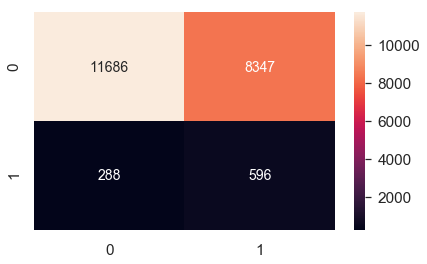

In [563]:
y_pred = pipeline_logistic.predict(X_test)
plot_confusion_matrix(y_test,y_pred)

In [564]:
calculate_classification_metrics(pipeline_logistic,X_test,y_test)

Accuracy:0.587
Sensitivity:0.674
Specificity:0.583
AUC:0.67
Ks_2sampResult(statistic=0.2722463817054801, pvalue=2.1437591689881233e-55)


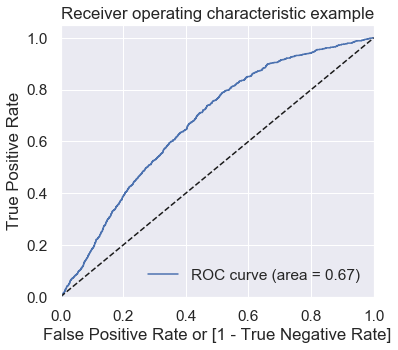

In [565]:
pred_probs_test = pipeline_logistic.predict_proba(X_test)[:,1]
draw_roc(y_test, pred_probs_test)

In [566]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.98      0.58      0.73     20033
         1.0       0.07      0.67      0.12       884

   micro avg       0.59      0.59      0.59     20917
   macro avg       0.52      0.63      0.43     20917
weighted avg       0.94      0.59      0.70     20917



**Hyperparameter Tuning**

In [567]:
# logistic regression - the class weight is used to handle class imbalance - it adjusts the cost function
logistic = LogisticRegression(class_weight='balanced')

# create pipeline
steps = [("scaler", StandardScaler()),
         ("logistic", logistic)
        ]

pipeline_logistic = Pipeline(steps)

# hyperparameter space
params = {'logistic__C': [0.005,0.008,0.01,0.03,0.05,0.1, 0.5, 1], 'logistic__penalty': ['l1', 'l2']}

# create 5 folds
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 4)

# create gridsearch object
model = GridSearchCV(estimator=pipeline_logistic, cv=folds, param_grid=params, scoring='roc_auc', n_jobs=-1, verbose=1)

In [568]:
model.fit(X_train,y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   12.7s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=4, shuffle=True),
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logistic', LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'logistic__C': [0.005, 0.008, 0.01, 0.03, 0.05, 0.1, 0.5, 1], 'logistic__penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [569]:
# print best hyperparameters
print("Best AUC: ", model.best_score_)
print("Best hyperparameters: ", model.best_params_)

Best AUC:  0.671759819717459
Best hyperparameters:  {'logistic__C': 0.008, 'logistic__penalty': 'l1'}


In [570]:
calculate_classification_metrics(model,X_test,y_test)

Accuracy:0.575
Sensitivity:0.683
Specificity:0.571
AUC:0.67
Ks_2sampResult(statistic=0.27166498806381234, pvalue=3.678800107065671e-55)


In [571]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.98      0.58      0.73     20033
         1.0       0.07      0.67      0.12       884

   micro avg       0.59      0.59      0.59     20917
   macro avg       0.52      0.63      0.43     20917
weighted avg       0.94      0.59      0.70     20917



In [572]:
lr_final = LogisticRegression(class_weight='balanced',penalty='l1',C=model.best_params_['logistic__C'])
lr_final.fit(X_train,y_train)

LogisticRegression(C=0.008, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [573]:
df1 = pd.DataFrame(lr_final.predict_proba(X_test)[:,1],columns=['Prob'])
df2 = pd.DataFrame(y_test).reset_index(drop=True).rename({'Performance_Tag':'y'},axis=1)
df = pd.concat([df1,df2],axis=1)
df.head()

Prob    y
0  0.679820  0.0
1  0.385012  0.0
2  0.524397  0.0
3  0.507114  0.0
4  0.626758  0.0

In [574]:
df['Actual Prediction'] = lr_final.predict(X_test)
threshold_cutoff = 0.485
df['Final Prediction'] = df['Prob'].apply(lambda x:1 if x > threshold_cutoff else 0)

In [575]:
df.head()

Prob    y  Actual Prediction  Final Prediction
0  0.679820  0.0                1.0                 1
1  0.385012  0.0                0.0                 0
2  0.524397  0.0                1.0                 1
3  0.507114  0.0                1.0                 1
4  0.626758  0.0                1.0                 1

In [576]:
confusion = confusion_matrix(y_test,df['Final Prediction'])
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives
print("Accuracy:{}".format(round((TP+TN)/(TP+TN+FP+FN),3)))
print("Sensitivity:{}".format(round(TP/float(TP+FN),3)))
print("Specificity:{}".format(round(TN/float(TN+FP),3)))
pred_probs = df['Prob']
print("AUC:{:2.2f}".format(roc_auc_score(y_test, pred_probs)))

Accuracy:0.561
Sensitivity:0.702
Specificity:0.555
AUC:0.67


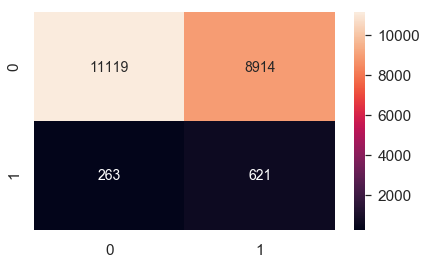

In [577]:
plot_confusion_matrix(y_test,df['Final Prediction'])

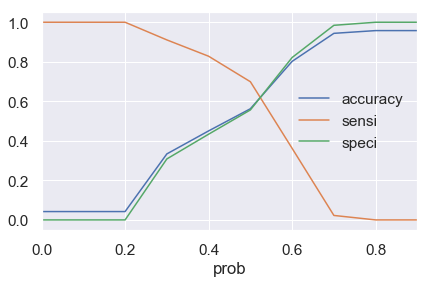

In [578]:
plot_sensi_speci_curve(df,'y','Prob')

In [579]:
print(classification_report(df['y'], df['Final Prediction']))

              precision    recall  f1-score   support

         0.0       0.98      0.56      0.71     20033
         1.0       0.07      0.70      0.12       884

   micro avg       0.56      0.56      0.56     20917
   macro avg       0.52      0.63      0.41     20917
weighted avg       0.94      0.56      0.68     20917



In [580]:
lr_final.coef_

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.5270148 , -0.39802086,  0.        , -0.1866287 , -0.0839878 ,
        -0.38507491, -0.05884458,  0.        , -0.08849869,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ]])

In [581]:
weight_df = pd.DataFrame(lr_final.coef_[0],X.columns).reset_index().rename({'index':'Variable',0:'Weight'},axis=1)
weight_df.sort_values('Weight',ascending=False)

Variable    Weight
0                                             woe_Age  0.000000
9                               woe_Type_of_residence  0.000000
22                     woe_Presence_of_open_home_loan  0.000000
21                     woe_Presence_of_open_auto_loan  0.000000
20                            woe_Outstanding_Balance  0.000000
19   woe_No_of_times_90_DPD_or_worse_in_last_6_months  0.000000
17   woe_No_of_times_60_DPD_or_worse_in_last_6_months  0.000000
1                                       woe_Education  0.000000
12  woe_No_of_Inquiries_in_last_6_months_excluding...  0.000000
8                                      woe_Profession  0.000000
7               woe_No_of_months_in_current_residence  0.000000
6                 woe_No_of_months_in_current_company  0.000000
5                                woe_No_of_dependents  0.000000
4       woe_Marital_Status_at_the_time_of_application  0.000000
3                                          woe_Income  0.000000
2                                          woe_Gender  0.000000
23                             woe_Total_No_of_Trades  0.000000
16  woe_No_of_times_60_DPD_or_worse_in_last_12_months -0.058845
14        woe_No_of_PL_trades_opened_in_last_6_months -0.083988
18  woe_No_of_times_90_DPD_or_worse_in_last_12_months -0.088499
13       woe_No_of_PL_trades_opened_in_last_12_months -0.186629
15  woe_No_of_times_30_DPD_or_worse_in_last_12_months -0.385075
11  woe_No_of_Inquiries_in_last_12_months_excludin... -0.398021
10         woe_Avgas_CC_Utilization_in_last_12_months -0.527015

In [582]:
credit_bureau_iv.sort_values('IV',ascending=False)

Variable        IV
0              Avgas_CC_Utilization_in_last_12_months  0.294080
11              No_of_trades_opened_in_last_12_months  0.257518
1   No_of_Inquiries_in_last_12_months_excluding_ho...  0.229279
16                                 Total_No_of_Trades  0.189996
5       No_of_times_30_DPD_or_worse_in_last_12_months  0.188403
3            No_of_PL_trades_opened_in_last_12_months  0.176856
6        No_of_times_30_DPD_or_worse_in_last_6_months  0.145515
7       No_of_times_60_DPD_or_worse_in_last_12_months  0.138034
4             No_of_PL_trades_opened_in_last_6_months  0.124506
9       No_of_times_90_DPD_or_worse_in_last_12_months  0.096123
12               No_of_trades_opened_in_last_6_months  0.095478
2   No_of_Inquiries_in_last_6_months_excluding_hom...  0.092685
8        No_of_times_60_DPD_or_worse_in_last_6_months  0.089478
10       No_of_times_90_DPD_or_worse_in_last_6_months  0.030681
13                                Outstanding_Balance  0.008594
14                         Presence_of_open_auto_loan  0.001662
15                         Presence_of_open_home_loan  0.000462

**Logistic using IV selected columns :**

In [583]:
iv_features = ['woe_Avgas_CC_Utilization_in_last_12_months','woe_No_of_Inquiries_in_last_12_months_excluding_home_&_auto_loans',\
               'woe_Total_No_of_Trades',\
               'woe_No_of_times_30_DPD_or_worse_in_last_12_months','woe_No_of_PL_trades_opened_in_last_12_months',\
               'woe_No_of_times_60_DPD_or_worse_in_last_12_months',\
               'woe_No_of_PL_trades_opened_in_last_6_months']
X_train_iv = X_train[iv_features]
X_test_iv = X_test[iv_features]

In [584]:
# logistic regression - the class weight is used to handle class imbalance - it adjusts the cost function
logistic = LogisticRegression(class_weight='balanced')

# create pipeline
steps = [("scaler", StandardScaler()),
         ("logistic", logistic)
        ]

pipeline_logistic = Pipeline(steps)

# hyperparameter space
params = {'logistic__C': [0.005,0.008,0.01,0.03,0.05,0.1, 0.5, 1], 'logistic__penalty': ['l1', 'l2']}

# create 5 folds
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 4)

# create gridsearch object
model = GridSearchCV(estimator=pipeline_logistic, cv=folds, param_grid=params, scoring='roc_auc', n_jobs=-1, verbose=1)

In [585]:
model.fit(X_train_iv,y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    5.6s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=4, shuffle=True),
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logistic', LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'logistic__C': [0.005, 0.008, 0.01, 0.03, 0.05, 0.1, 0.5, 1], 'logistic__penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [586]:
# print best hyperparameters
print("Best AUC: ", model.best_score_)
print("Best hyperparameters: ", model.best_params_)

Best AUC:  0.6719673956062566
Best hyperparameters:  {'logistic__C': 1, 'logistic__penalty': 'l2'}


In [587]:
calculate_classification_metrics(model,X_test_iv,y_test)

Accuracy:0.575
Sensitivity:0.686
Specificity:0.571
AUC:0.67
Ks_2sampResult(statistic=0.2715167033218719, pvalue=4.2212686108023815e-55)


**RandomForest Classifier:**

In [588]:
# Running the random forest with default parameters.
rfc = RandomForestClassifier(class_weight='balanced',max_depth=2)

# create pipeline
steps = [("scaler", StandardScaler()),
         ("random_forest", rfc)
        ]

pipeline_rfc = Pipeline(steps)

pipeline_rfc.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('random_forest', RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=2, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_i...tors=10, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False))])

In [589]:
calculate_classification_metrics(pipeline_rfc,X_test,y_test)

Accuracy:0.604
Sensitivity:0.654
Specificity:0.602
AUC:0.67
Ks_2sampResult(statistic=0.2635357542407968, pvalue=6.201064566437821e-52)


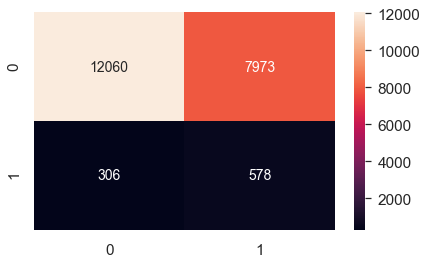

In [590]:
y_pred = pipeline_rfc.predict(X_test)
plot_confusion_matrix(y_test,y_pred)

**XGBClassifier :**

In [591]:
scale_pos_weight = (y_train[y_train==0].count())/(y_train[y_train==1].count())
scale_pos_weight

22.680252304706453

In [592]:
import xgboost as xgb
clf_gbt = xgb.XGBClassifier(max_depth=2,scale_pos_weight=scale_pos_weight,learning_rate=0.1)
clf_gbt.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=2, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=22.680252304706453, seed=None,
       silent=None, subsample=1, verbosity=1)

In [593]:
calculate_classification_metrics(clf_gbt,X_test,y_test)

Accuracy:0.555
Sensitivity:0.713
Specificity:0.548
AUC:0.67
Ks_2sampResult(statistic=0.2762625491468489, pvalue=4.9818125474692054e-57)


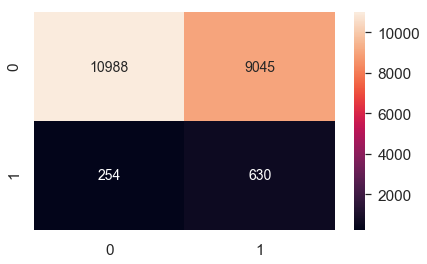

In [594]:
y_pred = clf_gbt.predict(X_test)
plot_confusion_matrix(y_test,y_pred)

In [595]:
clf_gbt.get_booster().get_score(importance_type = 'weight')

{'woe_Avgas_CC_Utilization_in_last_12_months': 29,
 'woe_No_of_times_30_DPD_or_worse_in_last_12_months': 23,
 'woe_No_of_Inquiries_in_last_12_months_excluding_home_&_auto_loans': 20,
 'woe_No_of_PL_trades_opened_in_last_12_months': 12,
 'woe_No_of_times_90_DPD_or_worse_in_last_12_months': 6,
 'woe_Total_No_of_Trades': 9,
 'woe_No_of_times_60_DPD_or_worse_in_last_12_months': 8,
 'woe_Income': 37,
 'woe_Profession': 16,
 'woe_Education': 21,
 'woe_No_of_months_in_current_residence': 18,
 'woe_No_of_PL_trades_opened_in_last_6_months': 11,
 'woe_No_of_months_in_current_company': 16,
 'woe_Gender': 12,
 'woe_No_of_dependents': 11,
 'woe_No_of_Inquiries_in_last_6_months_excluding_home_&_auto_loans': 8,
 'woe_Type_of_residence': 17,
 'woe_Outstanding_Balance': 4,
 'woe_Age': 7,
 'woe_No_of_times_90_DPD_or_worse_in_last_6_months': 4,
 'woe_Presence_of_open_auto_loan': 2,
 'woe_Marital_Status_at_the_time_of_application': 1}

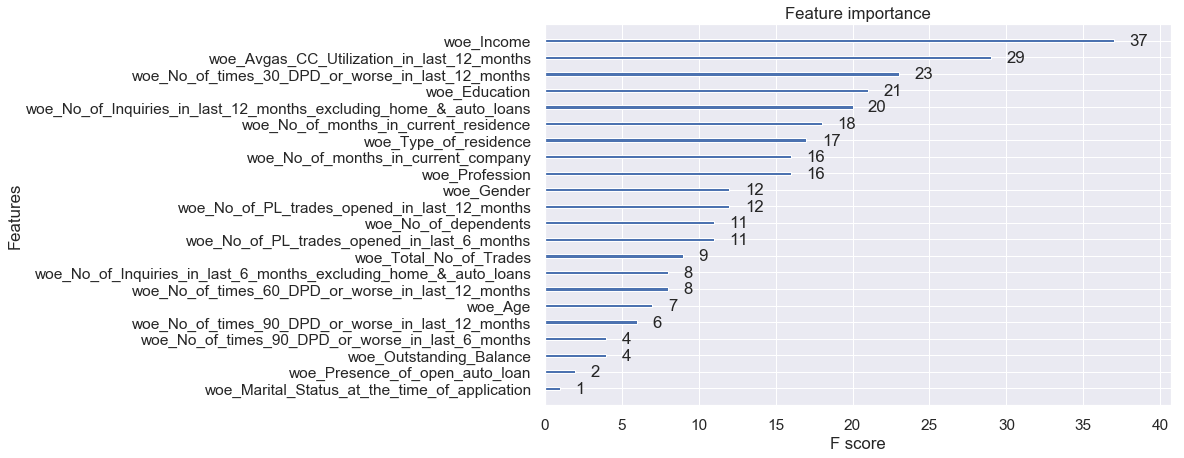

In [596]:
fig, ax = plt.subplots(figsize=(10, 7))
xgb.plot_importance(clf_gbt, importance_type = 'weight',ax=ax)
plt.show()

### Performance comparison of different models :

We built different models on the woe merged dataset and compared the performance. As the dataset is highly imbalanced we used class_weight feature of models to handle the imbalance. Considering the business scenario, where we need to identify the defaulters more strictly we need to reduce the false negatives, so we chose Sensitivity as the choice of metric.

Below table summarizes the metrics obtained from different models :

<table style="width:50%">
  <tr>
    <th>Model</th>
    <th>Accuracy</th>
    <th>Sensitivity</th>
    <th>Specificity</th>
    <th>AUC Score</th>
  </tr>
  <tr>
    <td>Logistic(All Features)</td>
    <td>0.562</td>
    <td>0.702</td>
    <td>0.555</td>
    <td>0.67</td>
  </tr>
  <tr>
    <td>Logistic(IV Features)</td>
    <td>0.575</td>
    <td>0.686</td>
    <td>0.57</td>
    <td>0.67</td>
  </tr>
  <tr>
    <td>Random Forest</td>
    <td>0.561</td>
    <td>0.682</td>
    <td>0.555</td>
    <td>0.66</td>
  </tr>
  <tr>
    <td>XGBoost</td>
    <td>0.555</td>
    <td>0.713</td>
    <td>0.548</td>
    <td>0.67</td>
  </tr>

</table>

We could observe that Logistic Regression have the best overall performance, though the difference is negligible. We will proceed with Logsitic Regression as our final model with cutoff probability of 0.48.

## Application Scorecard :

We will be building the scorecard for all the candidates using the probability obtained from the model.

In [597]:
merged_woe_df.head()

Application_ID   woe_Age  woe_Education  woe_Gender  woe_Income  woe_Marital_Status_at_the_time_of_application  woe_No_of_dependents  woe_No_of_months_in_current_company  woe_No_of_months_in_current_residence  woe_Profession  woe_Type_of_residence  woe_Avgas_CC_Utilization_in_last_12_months  woe_No_of_Inquiries_in_last_12_months_excluding_home_&_auto_loans  woe_No_of_Inquiries_in_last_6_months_excluding_home_&_auto_loans  woe_No_of_PL_trades_opened_in_last_12_months  woe_No_of_PL_trades_opened_in_last_6_months  woe_No_of_times_30_DPD_or_worse_in_last_12_months  woe_No_of_times_60_DPD_or_worse_in_last_12_months  woe_No_of_times_60_DPD_or_worse_in_last_6_months  woe_No_of_times_90_DPD_or_worse_in_last_12_months  woe_No_of_times_90_DPD_or_worse_in_last_6_months  woe_Outstanding_Balance  woe_Presence_of_open_auto_loan  woe_Presence_of_open_home_loan  woe_Total_No_of_Trades  Performance_Tag
0       954457215  0.007596      -0.014907   -0.032933    0.245612                                       0.004087             -0.005845                             0.123411                               -0.20823        0.028074               0.004056                                    0.799246                                           0.828596                                                           0.319569                                                     0.453449                                     0.314271                                           0.269272                                           0.200955                                          0.121316                                           0.133954                                          0.036804                -0.087933                       -0.011997                       -0.001235                0.686484              0.0
1       432830445 -0.033484       0.017725    0.010391    0.263833                                       0.004087              0.011748                             0.072353                               -0.20823        0.014157               0.004056                                    0.799246                                           0.828596                                                           0.319569                                                     0.453449                                     0.314271                                           0.269272                                           0.200955                                          0.121316                                           0.133954                                          0.036804                 0.092939                       -0.011997                       -0.001235               -0.210878              0.0
2       941387308 -0.033484      -0.014907    0.010391    0.263833                                      -0.022694             -0.005845                             0.072353                               -0.20823        0.014157               0.004056                                    0.799246                                           0.828596                                                           0.319569                                                     0.453449                                     0.314271                                           0.269272                                           0.200955                                          0.121316                                           0.133954                                          0.036804                -0.087933                       -0.011997                       -0.001235                0.686484              0.0
3       392161677  0.007596      -0.014907    0.010391    0.263833                                       0.004087             -0.005845                             0.123411                               -0.20823       -0.091452               0.004056                                    0.574668                                           0.828596                                                  

In [598]:
merged_woe_df.shape

(69722, 26)

In [599]:
X.shape

(69722, 24)

In [600]:
pred_df = pd.DataFrame(lr_final.predict_proba(X)[:,1],columns=['Prob'])
pred_df.head()

Prob
0  0.271030
1  0.271030
2  0.271030
3  0.295036
4  0.295036

In [601]:
pred_df = pd.concat([merged_woe_df['Application_ID'],pred_df['Prob'],merged_woe_df['Performance_Tag']],axis=1)
pred_df = pred_df.rename({'Performance_Tag':'Actual'},axis=1)
pred_df['Predicted'] = pred_df['Prob'].apply(lambda x:1 if x > threshold_cutoff else 0)
pred_df.head()

Application_ID      Prob  Actual  Predicted
0       954457215  0.271030     0.0          0
1       432830445  0.271030     0.0          0
2       941387308  0.271030     0.0          0
3       392161677  0.295036     0.0          0
4       182011211  0.295036     0.0          0

In [602]:
pred_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69722 entries, 0 to 69721
Data columns (total 4 columns):
Application_ID    69722 non-null int64
Prob              69722 non-null float64
Actual            69722 non-null float64
Predicted         69722 non-null int64
dtypes: float64(2), int64(2)
memory usage: 2.7 MB


In [603]:
pred_df['Score'] = calculate_application_score(pred_df)

In [604]:
pred_df.head()

Application_ID      Prob  Actual  Predicted       Score
0       954457215  0.271030     0.0          0  362.109621
1       432830445  0.271030     0.0          0  362.109621
2       941387308  0.271030     0.0          0  362.109621
3       392161677  0.295036     0.0          0  358.694582
4       182011211  0.295036     0.0          0  358.694582

In [605]:
pred_df['Score'].describe()

count    69722.000000
mean       338.643518
std         18.039407
min        307.716414
25%        324.312471
50%        338.646657
75%        358.694582
max        362.109621
Name: Score, dtype: float64

In [606]:
# Calculate the cutoff score from the probability threshold of the model
slope = 20/(np.log(20)-np.log(10))
#threshold_cutoff = 0.485
cutoff_score = 400 + (slope * (np.log((1-threshold_cutoff)/threshold_cutoff) -np.log(10)))
cutoff_score

335.29319180217453

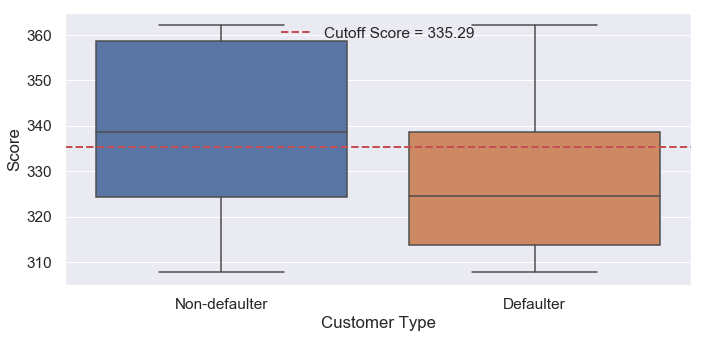

In [607]:
plt.figure(figsize=(10,5))
ax = sns.boxplot(y=pred_df['Score'],x=pred_df['Actual'].apply(lambda x:'Non-defaulter' if x==0 else 'Defaulter'))
plt.axhline(cutoff_score, label='Cutoff Score = %0.2f' %cutoff_score,color='r',linestyle='--',linewidth=2)
ax.set_xlabel('Customer Type')
plt.legend(loc="upper center")
plt.show()

**We could observe that the mean and median score for the approved customers are higher than those of rejected customers. The red dotted line indicates the cutoff score we have chosen.**

**Confusion Matrix on the whole data**

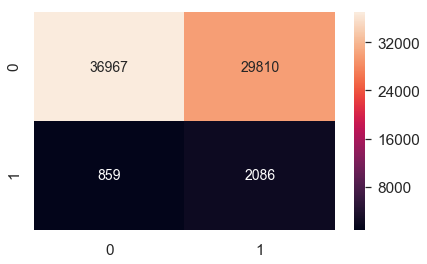

In [608]:
plot_confusion_matrix(pred_df['Actual'],pred_df['Predicted'])

In [609]:
confusion = confusion_matrix(pred_df['Actual'],pred_df['Predicted'])
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives
print("Accuracy:{}".format(round((TP+TN)/(TP+TN+FP+FN),3)))
print("Sensitivity:{}".format(round(TP/float(TP+FN),3)))
print("Specificity:{}".format(round(TN/float(TN+FP),3)))
print("AUC:{:2.2f}".format(roc_auc_score(pred_df['Actual'],pred_df['Prob'])))
from scipy.stats import ks_2samp
pred_probs_true = [j for i,j in zip(pred_df['Actual'],pred_df['Prob']) if i==0]
pred_probs_false = [j for i,j in zip(pred_df['Actual'],pred_df['Prob']) if i==1]
print(ks_2samp(pred_probs_true,pred_probs_false))

Accuracy:0.56
Sensitivity:0.708
Specificity:0.554
AUC:0.67
Ks_2sampResult(statistic=0.2679899215016465, pvalue=3.463397816569736e-177)


In [610]:
pred_df.head()

Application_ID      Prob  Actual  Predicted       Score
0       954457215  0.271030     0.0          0  362.109621
1       432830445  0.271030     0.0          0  362.109621
2       941387308  0.271030     0.0          0  362.109621
3       392161677  0.295036     0.0          0  358.694582
4       182011211  0.295036     0.0          0  358.694582

In [611]:
pred_df[pred_df['Predicted']==0]['Score'].min()

335.6009913052122

In [612]:
pred_df[pred_df['Predicted']==1]['Score'].max()

335.2886187024596

In [613]:
pred_df['Cutoff Score Prediction'] = pred_df['Score'].apply(lambda x:1 if x <= cutoff_score else 0)

In [614]:
pred_df.head()

Application_ID      Prob  Actual  Predicted       Score  Cutoff Score Prediction
0       954457215  0.271030     0.0          0  362.109621                        0
1       432830445  0.271030     0.0          0  362.109621                        0
2       941387308  0.271030     0.0          0  362.109621                        0
3       392161677  0.295036     0.0          0  358.694582                        0
4       182011211  0.295036     0.0          0  358.694582                        0

In [615]:
confusion = confusion_matrix(pred_df['Actual'],pred_df['Cutoff Score Prediction'])
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives
print("Accuracy:{}".format(round((TP+TN)/(TP+TN+FP+FN),3)))
print("Sensitivity:{}".format(round(TP/float(TP+FN),3)))
print("Specificity:{}".format(round(TN/float(TN+FP),3)))

Accuracy:0.56
Sensitivity:0.708
Specificity:0.554


### Check Model Performance on Rejected Candidates

In [616]:
# Final model
lr_final

LogisticRegression(C=0.008, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [617]:
rejected_demo.head()

Application_ID  Age Gender Marital_Status_at_the_time_of_application  No_of_dependents  Income     Education Profession Type_of_residence  No_of_months_in_current_residence  No_of_months_in_current_company  Performance_Tag
69603       906908303   35      M                                    Single               1.0     6.0      Bachelor        SAL            Rented                                 22                               18              NaN
69604        10990583   47      F                                   Married               4.0    12.0       Masters         SE            Rented                                122                               25              NaN
69605       589678446   46      M                                   Married               3.0     7.0  Professional         SE            Rented                                 10                               31              NaN
69606       809411322   41      M                                   Married               3.0    18.0       Masters        SAL            Rented                                  6                               47              NaN
69607       150246616   42      F                                   Married               4.0    17.0           Phd        SAL            Rented                                  8                               49              NaN

In [618]:
woe_transformed_df = apply_woe(rejected_demo,demo_woe_details,transform_prefix='woe_',\
                               exclude=['Application_ID','Performance_Tag'])

Transforming for column : Age
Transforming for column : Education
Transforming for column : Gender
Transforming for column : Income
Transforming for column : Marital_Status_at_the_time_of_application
Transforming for column : No_of_dependents
Transforming for column : No_of_months_in_current_company
Transforming for column : No_of_months_in_current_residence
Transforming for column : Profession
Transforming for column : Type_of_residence


In [619]:
woe_transformed_df.head()

Application_ID  Age Gender Marital_Status_at_the_time_of_application  No_of_dependents  Income     Education Profession Type_of_residence  No_of_months_in_current_residence  No_of_months_in_current_company  Performance_Tag   woe_Age  woe_Education  woe_Gender  woe_Income  woe_Marital_Status_at_the_time_of_application  woe_No_of_dependents  woe_No_of_months_in_current_company  woe_No_of_months_in_current_residence  woe_Profession  woe_Type_of_residence
69603       906908303   35      M                                    Single               1.0     6.0      Bachelor        SAL            Rented                                 22                               18              NaN -0.033484      -0.014907    0.010391   -0.291434                                      -0.022694             -0.005845                            -0.021448                               -0.20823        0.028074               0.004056
69604        10990583   47      F                                   Married               4.0    12.0       Masters         SE            Rented                                122                               25              NaN  0.007596      -0.008358   -0.032933   -0.056256                                       0.004087              0.011748                            -0.021448                               -0.20823       -0.091452               0.004056
69605       589678446   46      M                                   Married               3.0     7.0  Professional         SE            Rented                                 10                               31              NaN  0.007596       0.017725    0.010391   -0.291434                                       0.004087             -0.005845                            -0.021448                                0.25407       -0.091452               0.004056
69606       809411322   41      M                                   Married               3.0    18.0       Masters        SAL            Rented                                  6                               47              NaN  0.007596      -0.008358    0.010391   -0.056256                                       0.004087             -0.005845                             0.072353                                0.25407        0.028074               0.004056
69607       150246616   42      F                                   Married               4.0    17.0           Phd        SAL            Rented                                  8                               49              NaN  0.007596       0.023418   -0.032933   -0.056256                                       0.004087              0.011748                             0.072353                                0.25407        0.028074               0.004056

In [620]:
demo_rejected_woe = create_woe_df(woe_transformed_df)
demo_rejected_woe.head()

Application_ID   woe_Age  woe_Education  woe_Gender  woe_Income  woe_Marital_Status_at_the_time_of_application  woe_No_of_dependents  woe_No_of_months_in_current_company  woe_No_of_months_in_current_residence  woe_Profession  woe_Type_of_residence  Performance_Tag
69603       906908303 -0.033484      -0.014907    0.010391   -0.291434                                      -0.022694             -0.005845                            -0.021448                               -0.20823        0.028074               0.004056              NaN
69604        10990583  0.007596      -0.008358   -0.032933   -0.056256                                       0.004087              0.011748                            -0.021448                               -0.20823       -0.091452               0.004056              NaN
69605       589678446  0.007596       0.017725    0.010391   -0.291434                                       0.004087             -0.005845                            -0.021448                                0.25407       -0.091452               0.004056              NaN
69606       809411322  0.007596      -0.008358    0.010391   -0.056256                                       0.004087             -0.005845                             0.072353                                0.25407        0.028074               0.004056              NaN
69607       150246616  0.007596       0.023418   -0.032933   -0.056256                                       0.004087              0.011748                             0.072353                                0.25407        0.028074               0.004056              NaN

In [621]:
rejected_credit_bureau.head()

Application_ID  No_of_times_90_DPD_or_worse_in_last_6_months  No_of_times_60_DPD_or_worse_in_last_6_months  No_of_times_30_DPD_or_worse_in_last_6_months  No_of_times_90_DPD_or_worse_in_last_12_months  No_of_times_60_DPD_or_worse_in_last_12_months  No_of_times_30_DPD_or_worse_in_last_12_months  Avgas_CC_Utilization_in_last_12_months  No_of_trades_opened_in_last_6_months  No_of_trades_opened_in_last_12_months  No_of_PL_trades_opened_in_last_6_months  No_of_PL_trades_opened_in_last_12_months  No_of_Inquiries_in_last_6_months_excluding_home_&_auto_loans  No_of_Inquiries_in_last_12_months_excluding_home_&_auto_loans  Presence_of_open_home_loan  Outstanding_Balance  Total_No_of_Trades  Presence_of_open_auto_loan  Performance_Tag
69603       906908303                                             0                                             0                                             2                                              1                                              2                                              3                                    30.0                                   4.0                                     12                                        3                                         7                                                  2                                                             4                                     0.0            1309623.0                  13                           0              NaN
69604        10990583                                             1                                             1                                             1                                              3                                              2                                              2                                    16.0                                   3.0                                      7                                        3                                         4                                                  3                                                             5                                     0.0             775626.0                   7                           0              NaN
69605       589678446                                             3                                             4                                             5                                              3                                              5                                              6                                    83.0                                   2.0                                      7                                        2                                         4                                                  0                                                             3                                     0.0             732602.0                   8                           0              NaN
69606       809411322                                             1                                             3                                             4                                              3                                              4                                              5                                    87.0                                   2.0                                      7                                        1                                         4                                                  4                                                             5                                     0.0             842057.0                   8                           0              NaN
69607       150246616                                             2                                             2                                             4                                              3                                              2                                              6       

In [622]:
woe_transformed_df = apply_woe(rejected_credit_bureau,credit_bureau_woe_details,transform_prefix='woe_',\
                               exclude=['Application_ID','Performance_Tag'])

Transforming for column : Avgas_CC_Utilization_in_last_12_months
Transforming for column : No_of_Inquiries_in_last_12_months_excluding_home_&_auto_loans
Transforming for column : No_of_Inquiries_in_last_6_months_excluding_home_&_auto_loans
Transforming for column : No_of_PL_trades_opened_in_last_12_months
Transforming for column : No_of_PL_trades_opened_in_last_6_months
Transforming for column : No_of_times_30_DPD_or_worse_in_last_12_months
Transforming for column : No_of_times_30_DPD_or_worse_in_last_6_months
Transforming for column : No_of_times_60_DPD_or_worse_in_last_12_months
Transforming for column : No_of_times_60_DPD_or_worse_in_last_6_months
Transforming for column : No_of_times_90_DPD_or_worse_in_last_12_months
Transforming for column : No_of_times_90_DPD_or_worse_in_last_6_months
Transforming for column : No_of_trades_opened_in_last_12_months
Transforming for column : No_of_trades_opened_in_last_6_months
Transforming for column : Outstanding_Balance
Transforming for column :

In [623]:
woe_transformed_df.head()

Application_ID  No_of_times_90_DPD_or_worse_in_last_6_months  No_of_times_60_DPD_or_worse_in_last_6_months  No_of_times_30_DPD_or_worse_in_last_6_months  No_of_times_90_DPD_or_worse_in_last_12_months  No_of_times_60_DPD_or_worse_in_last_12_months  No_of_times_30_DPD_or_worse_in_last_12_months  Avgas_CC_Utilization_in_last_12_months  No_of_trades_opened_in_last_6_months  No_of_trades_opened_in_last_12_months  No_of_PL_trades_opened_in_last_6_months  No_of_PL_trades_opened_in_last_12_months  No_of_Inquiries_in_last_6_months_excluding_home_&_auto_loans  No_of_Inquiries_in_last_12_months_excluding_home_&_auto_loans  Presence_of_open_home_loan  Outstanding_Balance  Total_No_of_Trades  Presence_of_open_auto_loan  Performance_Tag  woe_Avgas_CC_Utilization_in_last_12_months  woe_No_of_Inquiries_in_last_12_months_excluding_home_&_auto_loans  woe_No_of_Inquiries_in_last_6_months_excluding_home_&_auto_loans  woe_No_of_PL_trades_opened_in_last_12_months  woe_No_of_PL_trades_opened_in_last_6_months  woe_No_of_times_30_DPD_or_worse_in_last_12_months  woe_No_of_times_30_DPD_or_worse_in_last_6_months  woe_No_of_times_60_DPD_or_worse_in_last_12_months  woe_No_of_times_60_DPD_or_worse_in_last_6_months  woe_No_of_times_90_DPD_or_worse_in_last_12_months  woe_No_of_times_90_DPD_or_worse_in_last_6_months  woe_No_of_trades_opened_in_last_12_months  woe_No_of_trades_opened_in_last_6_months  woe_Outstanding_Balance  woe_Presence_of_open_auto_loan  woe_Presence_of_open_home_loan  woe_Total_No_of_Trades
69603       906908303                                             0                                             0                                             2                                              1                                              2                                              3                                    30.0                                   4.0                                     12                                        3                                         7                                                  2                                                             4                                     0.0            1309623.0                  13                           0              NaN                                   -0.367972                                          -0.183212                                                          -0.292286                                                     -0.39584                                    -0.400317                                          -0.710764                                         -0.742491                                          -0.694835                                          0.121316                                           0.133954                                          0.036804                                  -0.368106                                 -0.354391                -0.087933                       -0.011997                       -0.001235               -0.332107
69604        10990583                                             1                                             1                                             1                                              3                                              2                                              2                                    16.0                                   3.0                                      7                                        3                                         4                                                  3                                                             5                                     0.0             775626.0                   7                           0              NaN                                   -0.367972                                          -0.368049                                                          -0.292286                                                     -0.39584                           

In [624]:
cb_rejected_woe = create_woe_df(woe_transformed_df)
cb_rejected_woe.head()

Application_ID  woe_Avgas_CC_Utilization_in_last_12_months  woe_No_of_Inquiries_in_last_12_months_excluding_home_&_auto_loans  woe_No_of_Inquiries_in_last_6_months_excluding_home_&_auto_loans  woe_No_of_PL_trades_opened_in_last_12_months  woe_No_of_PL_trades_opened_in_last_6_months  woe_No_of_times_30_DPD_or_worse_in_last_12_months  woe_No_of_times_30_DPD_or_worse_in_last_6_months  woe_No_of_times_60_DPD_or_worse_in_last_12_months  woe_No_of_times_60_DPD_or_worse_in_last_6_months  woe_No_of_times_90_DPD_or_worse_in_last_12_months  woe_No_of_times_90_DPD_or_worse_in_last_6_months  woe_No_of_trades_opened_in_last_12_months  woe_No_of_trades_opened_in_last_6_months  woe_Outstanding_Balance  woe_Presence_of_open_auto_loan  woe_Presence_of_open_home_loan  woe_Total_No_of_Trades  Performance_Tag
69603       906908303                                   -0.367972                                          -0.183212                                                          -0.292286                                                     -0.39584                                    -0.400317                                          -0.710764                                         -0.742491                                          -0.694835                                          0.121316                                           0.133954                                          0.036804                                  -0.368106                                 -0.354391                -0.087933                       -0.011997                       -0.001235               -0.332107              NaN
69604        10990583                                   -0.367972                                          -0.368049                                                          -0.292286                                                     -0.39584                                    -0.400317                                          -0.710764                                          0.198371                                          -0.694835                                          0.121316                                          -0.723329                                          0.036804                                  -0.228771                                 -0.354391                -0.087933                       -0.011997                       -0.001235               -0.210878              NaN
69605       589678446                                   -0.499292                                          -0.183212                                                           0.319569                                                     -0.39584                                    -0.400317                                          -0.710764                                         -0.742491                                          -0.694835                                         -0.743064                                          -0.723329                                         -0.835745                                  -0.228771                                  0.270556                 0.092939                       -0.011997                       -0.001235               -0.210878              NaN
69606       809411322                                   -0.499292                                          -0.368049                                                          -0.292286                                                     -0.39584                                     0.314271                                          -0.710764                                         -0.742491                                          -0.694835                                         -0.743064                                          -0.723329                                          0.036804                                  -0.228771                                  0.270556                -0.087933                       -0.011997                       -0.001235         

In [625]:
merged_rejected_df = pd.merge(left=demo_rejected_woe,right=cb_rejected_woe,on = 'Application_ID',how='inner')
merged_rejected_df.head()

Application_ID   woe_Age  woe_Education  woe_Gender  woe_Income  woe_Marital_Status_at_the_time_of_application  woe_No_of_dependents  woe_No_of_months_in_current_company  woe_No_of_months_in_current_residence  woe_Profession  woe_Type_of_residence  Performance_Tag_x  woe_Avgas_CC_Utilization_in_last_12_months  woe_No_of_Inquiries_in_last_12_months_excluding_home_&_auto_loans  woe_No_of_Inquiries_in_last_6_months_excluding_home_&_auto_loans  woe_No_of_PL_trades_opened_in_last_12_months  woe_No_of_PL_trades_opened_in_last_6_months  woe_No_of_times_30_DPD_or_worse_in_last_12_months  woe_No_of_times_30_DPD_or_worse_in_last_6_months  woe_No_of_times_60_DPD_or_worse_in_last_12_months  woe_No_of_times_60_DPD_or_worse_in_last_6_months  woe_No_of_times_90_DPD_or_worse_in_last_12_months  woe_No_of_times_90_DPD_or_worse_in_last_6_months  woe_No_of_trades_opened_in_last_12_months  woe_No_of_trades_opened_in_last_6_months  woe_Outstanding_Balance  woe_Presence_of_open_auto_loan  woe_Presence_of_open_home_loan  woe_Total_No_of_Trades  Performance_Tag_y
0       906908303 -0.033484      -0.014907    0.010391   -0.291434                                      -0.022694             -0.005845                            -0.021448                               -0.20823        0.028074               0.004056                NaN                                   -0.367972                                          -0.183212                                                          -0.292286                                                     -0.39584                                    -0.400317                                          -0.710764                                         -0.742491                                          -0.694835                                          0.121316                                           0.133954                                          0.036804                                  -0.368106                                 -0.354391                -0.087933                       -0.011997                       -0.001235               -0.332107                NaN
1        10990583  0.007596      -0.008358   -0.032933   -0.056256                                       0.004087              0.011748                            -0.021448                               -0.20823       -0.091452               0.004056                NaN                                   -0.367972                                          -0.368049                                                          -0.292286                                                     -0.39584                                    -0.400317                                          -0.710764                                          0.198371                                          -0.694835                                          0.121316                                          -0.723329                                          0.036804                                  -0.228771                                 -0.354391                -0.087933                       -0.011997                       -0.001235               -0.210878                NaN
2       589678446  0.007596       0.017725    0.010391   -0.291434                                       0.004087             -0.005845                            -0.021448                                0.25407       -0.091452               0.004056                NaN                                   -0.499292                                          -0.183212                                                           0.319569                                                     -0.39584                                    -0.400317                                          -0.710764                                         -0.742491                                          -0.694835                                         -0.743064                                          -0.723329                                       

In [626]:
merged_rejected_df.shape

(1425, 30)

In [627]:
merged_rejected_df = merged_rejected_df.drop('Performance_Tag_x',axis=1)
merged_rejected_df.rename({'Performance_Tag_y':'Performance_Tag'},axis=1,inplace=True)

In [628]:
merged_rejected_df.head()

Application_ID   woe_Age  woe_Education  woe_Gender  woe_Income  woe_Marital_Status_at_the_time_of_application  woe_No_of_dependents  woe_No_of_months_in_current_company  woe_No_of_months_in_current_residence  woe_Profession  woe_Type_of_residence  woe_Avgas_CC_Utilization_in_last_12_months  woe_No_of_Inquiries_in_last_12_months_excluding_home_&_auto_loans  woe_No_of_Inquiries_in_last_6_months_excluding_home_&_auto_loans  woe_No_of_PL_trades_opened_in_last_12_months  woe_No_of_PL_trades_opened_in_last_6_months  woe_No_of_times_30_DPD_or_worse_in_last_12_months  woe_No_of_times_30_DPD_or_worse_in_last_6_months  woe_No_of_times_60_DPD_or_worse_in_last_12_months  woe_No_of_times_60_DPD_or_worse_in_last_6_months  woe_No_of_times_90_DPD_or_worse_in_last_12_months  woe_No_of_times_90_DPD_or_worse_in_last_6_months  woe_No_of_trades_opened_in_last_12_months  woe_No_of_trades_opened_in_last_6_months  woe_Outstanding_Balance  woe_Presence_of_open_auto_loan  woe_Presence_of_open_home_loan  woe_Total_No_of_Trades  Performance_Tag
0       906908303 -0.033484      -0.014907    0.010391   -0.291434                                      -0.022694             -0.005845                            -0.021448                               -0.20823        0.028074               0.004056                                   -0.367972                                          -0.183212                                                          -0.292286                                                     -0.39584                                    -0.400317                                          -0.710764                                         -0.742491                                          -0.694835                                          0.121316                                           0.133954                                          0.036804                                  -0.368106                                 -0.354391                -0.087933                       -0.011997                       -0.001235               -0.332107              NaN
1        10990583  0.007596      -0.008358   -0.032933   -0.056256                                       0.004087              0.011748                            -0.021448                               -0.20823       -0.091452               0.004056                                   -0.367972                                          -0.368049                                                          -0.292286                                                     -0.39584                                    -0.400317                                          -0.710764                                          0.198371                                          -0.694835                                          0.121316                                          -0.723329                                          0.036804                                  -0.228771                                 -0.354391                -0.087933                       -0.011997                       -0.001235               -0.210878              NaN
2       589678446  0.007596       0.017725    0.010391   -0.291434                                       0.004087             -0.005845                            -0.021448                                0.25407       -0.091452               0.004056                                   -0.499292                                          -0.183212                                                           0.319569                                                     -0.39584                                    -0.400317                                          -0.710764                                         -0.742491                                          -0.694835                                         -0.743064                                          -0.723329                                         -0.835745                                  -0.228771                            

In [629]:
cols_to_drop = ['Application_ID','Performance_Tag','woe_No_of_trades_opened_in_last_12_months',\
                'woe_No_of_times_30_DPD_or_worse_in_last_6_months','woe_No_of_trades_opened_in_last_6_months']
pred_reject = pd.DataFrame(lr_final.predict_proba(merged_rejected_df.drop(cols_to_drop,axis=1))[:,1],columns=['Prob'])

In [630]:
pred_reject.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1425 entries, 0 to 1424
Data columns (total 1 columns):
Prob    1425 non-null float64
dtypes: float64(1)
memory usage: 11.2 KB


In [631]:
pred_reject = pd.concat([merged_rejected_df['Application_ID'],pred_reject['Prob']],axis=1)
pred_reject.head()

Application_ID      Prob
0       906908303  0.663086
1        10990583  0.695617
2       589678446  0.694693
3       809411322  0.697560
4       150246616  0.695617

In [632]:
pred_reject['Predicted'] = pred_reject['Prob'].apply(lambda x:1 if x > threshold_cutoff else 0)
pred_reject.head()

Application_ID      Prob  Predicted
0       906908303  0.663086          1
1        10990583  0.695617          1
2       589678446  0.694693          1
3       809411322  0.697560          1
4       150246616  0.695617          1

In [633]:
pred_reject['Predicted'].value_counts()

1    1420
0       5
Name: Predicted, dtype: int64

In [634]:
# Calculate score for the rejected candidates
pred_reject['Score'] = calculate_application_score(pred_reject)
pred_reject.head()

Application_ID      Prob  Predicted       Score
0       906908303  0.663086          1  314.025176
1        10990583  0.695617          1  309.713324
2       589678446  0.694693          1  309.839166
3       809411322  0.697560          1  309.448131
4       150246616  0.695617          1  309.713324

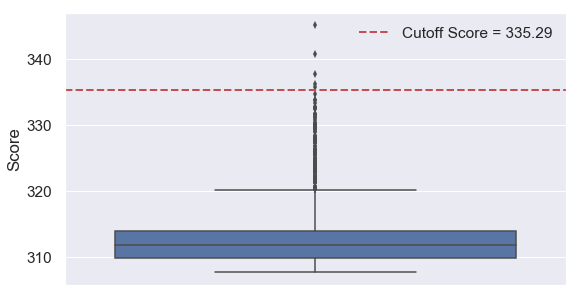

In [635]:
plt.figure(figsize=(8,5))
ax = sns.boxplot(y=pred_reject['Score'])
plt.axhline(cutoff_score, label='Cutoff Score = %0.2f' %cutoff_score,color='r',linestyle='--',linewidth=2)
plt.legend(loc="upper right")
plt.show()

In [636]:
pred_reject['Cutoff Score Status'] = pred_reject['Score'].apply(lambda x:'Defaulters' if x < cutoff_score else 'Non-defaulters')
pred_reject.head()

Application_ID      Prob  Predicted       Score Cutoff Score Status
0       906908303  0.663086          1  314.025176          Defaulters
1        10990583  0.695617          1  309.713324          Defaulters
2       589678446  0.694693          1  309.839166          Defaulters
3       809411322  0.697560          1  309.448131          Defaulters
4       150246616  0.695617          1  309.713324          Defaulters

In [637]:
pred_reject['Cutoff Score Status'].value_counts()

Defaulters        1420
Non-defaulters       5
Name: Cutoff Score Status, dtype: int64

In [638]:
round(100*pred_reject['Cutoff Score Status'].value_counts()/len(pred_reject),2)

Defaulters        99.65
Non-defaulters     0.35
Name: Cutoff Score Status, dtype: float64

From the above data we can observe that the model is identifying 1420 customers as default among the 1425 rejected candidates. So our model has been able to identify **99.65% of the rejected loan applications as defaulters.**

### Analyse Gain and Lift Chart :

In [639]:
pred_df.head()

Application_ID      Prob  Actual  Predicted       Score  Cutoff Score Prediction
0       954457215  0.271030     0.0          0  362.109621                        0
1       432830445  0.271030     0.0          0  362.109621                        0
2       941387308  0.271030     0.0          0  362.109621                        0
3       392161677  0.295036     0.0          0  358.694582                        0
4       182011211  0.295036     0.0          0  358.694582                        0

In [640]:
decile_df = pred_df[['Actual','Prob','Predicted']]
# Splitting into deciles
decile_df['decile'] = pd.qcut(decile_df['Prob'].rank(method='first'), 10, labels=np.arange(10, 0, -1))
cols = ['Actual','Prob','Predicted','decile']
decile_df = decile_df[cols]
decile_df.head()

Actual      Prob  Predicted decile
0     0.0  0.271030          0     10
1     0.0  0.271030          0     10
2     0.0  0.271030          0     10
3     0.0  0.295036          0      9
4     0.0  0.295036          0      9

In [641]:
lift_df = decile_df.groupby('decile')['Prob'].count().reset_index()
lift_df.rename({'Prob':'total'}, axis=1, inplace=True)

In [642]:
lift_df_pred = decile_df[decile_df['Actual']==1].groupby('decile')['Actual'].count().reset_index()

In [643]:
lift_df_final = lift_df.merge(lift_df_pred,on = 'decile')
lift_df_final = lift_df_final.sort_values(['decile'], ascending=False)
lift_df_final['cum_default'] = lift_df_final['Actual'].cumsum()
lift_df_final['% gain'] = 100*(lift_df_final['cum_default']/sum(lift_df_final['Actual']))
lift_df_final['cumlift'] = lift_df_final['% gain']/(lift_df_final['decile'].astype('int')*(100/10))
lift_df_final.reset_index(drop=True)

decile  total  Actual  cum_default      % gain   cumlift
0      1   6973     600          600   20.373514  2.037351
1      2   6972     542         1142   38.777589  1.938879
2      3   6972     380         1522   51.680815  1.722694
3      4   6972     387         1909   64.821732  1.620543
4      5   6972     300         2209   75.008489  1.500170
5      6   6972     253         2462   83.599321  1.393322
6      7   6972     194         2656   90.186757  1.288382
7      8   6972     111         2767   93.955857  1.174448
8      9   6972     124         2891   98.166384  1.090738
9     10   6973      54         2945  100.000000  1.000000

**From the above table we could see that we can predict 75% of total defaulters correctly by analysing only 50% of the total client base.**

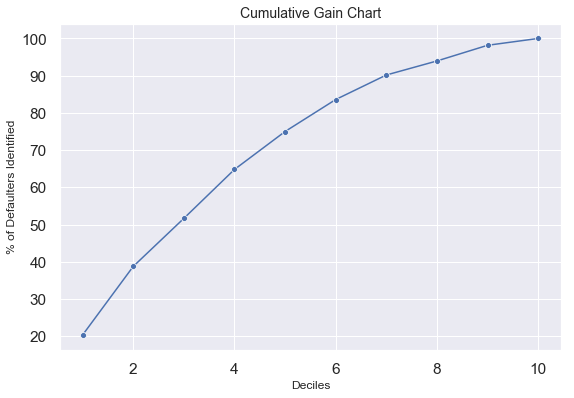

In [644]:
plt.figure(figsize=(8,6))
ax = sns.lineplot(data=lift_df_final,x='decile', y='% gain', marker="o")
ax.set_title("Cumulative Gain Chart",fontsize=14)
ax.set_xlabel("Deciles",fontsize=12)
ax.set_ylabel("% of Defaulters Identified",fontsize=12)
plt.show()

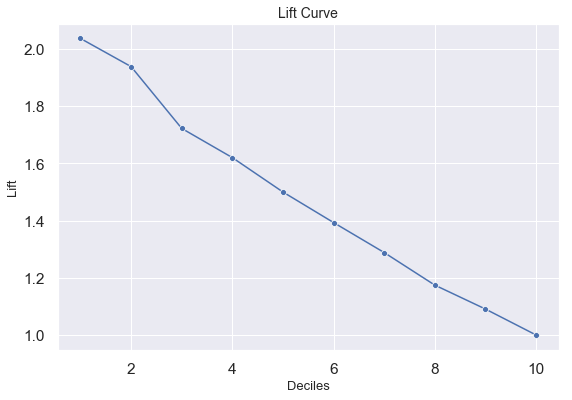

In [645]:
plt.figure(figsize=(8,6))
ax = sns.lineplot(data=lift_df_final,x='decile', y='cumlift',marker="o")
ax.set_title("Lift Curve",fontsize=14)
ax.set_xlabel("Deciles",fontsize=13)
ax.set_ylabel("Lift",fontsize=13)
plt.show()

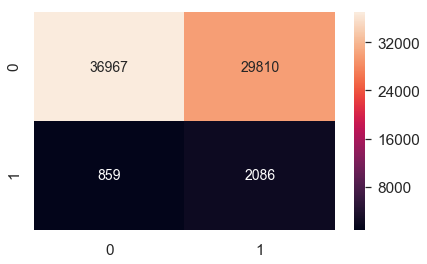

In [646]:
plot_confusion_matrix(pred_df['Actual'],pred_df['Predicted'])

### Evaluating Financial Benefits of the Model :

We will make some assumptions regarding the average credit loss for each defaulted customers and the profit obtained from each non-defaulters. We will analyse the overall financial benefit of the model and calculate the net financial gain obtained by using the model.

Let's assume the average credit loss for each defaulted customer is Rs 100000/- and profit for each non-defaulters be Rs 5000/-

**Credit Loss Saved**

The candidates who have been selected by the bank and have defaulted are responsible for the credit loss to the bank.We will calculate the percentage of credit loss we were able to avert by using the model.

In [649]:
defaulter_model =len(pred_df[(pred_df['Cutoff Score Prediction']==0) & (pred_df['Actual']==1)])
total_defaulters = len(pred_df[pred_df['Actual']==1])
total_num_customers = len(pred_df)
rejected_cust_non_defaulters = len(pred_reject[pred_reject['Cutoff Score Status']=='Non-defaulters'])
percent_defaulters_without_model = round(100*total_defaulters/total_num_customers,2)
percent_defaulters_with_model = round(100*defaulter_model/total_num_customers,2)

In [650]:
print("Number of Customers who are actual defaulters but identified as non-defaulters by the model : {}".format(defaulter_model))
print("Total number of defaulters : {}".format(total_defaulters))
print("% of candidates approved and then defaulted when model was not used : {}%".format(percent_defaulters_without_model))
print("% of candidates approved and then defaulted when model was used : {}%".format(percent_defaulters_with_model))
print("% of Credit Loss saved : {}%".format(round(percent_defaulters_without_model-percent_defaulters_with_model,2)))

Number of Customers who are actual defaulters but identified as non-defaulters by the model : 859
Total number of defaulters : 2945
% of candidates approved and then defaulted when model was not used : 4.22%
% of candidates approved and then defaulted when model was used : 1.23%
% of Credit Loss saved : 2.99%


**Revenue Loss**

Occurs when good customers are identified as bad and credit card application is rejected.

In [651]:
# Customers below the cutoff score but are actual non-defaulters
non_defaulters_model = len(pred_df[(pred_df['Cutoff Score Prediction']==1) & (pred_df['Actual']==0)])
total_non_defaulters = len(pred_df[pred_df['Actual']==0])
print("Number of customers who are actual non-defaulters but identified as defaulters by the model : {}"\
      .format(non_defaulters_model))
print("Number of non-defaulters correctly identified by model : {}".format(total_non_defaulters-non_defaulters_model))
print("Total number of non-defaulters : {}".format(total_non_defaulters))
print("% of good candidates rejected by our model : {:.2f}%".format(non_defaulters_model/total_non_defaulters*100))

Number of customers who are actual non-defaulters but identified as defaulters by the model : 29810
Number of non-defaulters correctly identified by model : 36967
Total number of non-defaulters : 66777
% of good candidates rejected by our model : 44.64%


In [653]:
profit_without_model = (total_non_defaulters*5000 - total_defaulters*100000)/10000000
profit_with_model = ((total_non_defaulters-non_defaulters_model)*5000 - defaulter_model*100000)/10000000
print("Net profit without model : Rs {:.2f} crores".format(profit_without_model))
print("Net profit with model : Rs {:.2f} crores".format(profit_with_model))
print("Net Financial gain using the model : Rs {:.2f} crores".format(profit_with_model-profit_without_model))
print("% Financial Gain : {:.2f}%".format((profit_with_model-profit_without_model)/profit_without_model*100))

Net profit without model : Rs 3.94 crores
Net profit with model : Rs 9.89 crores
Net Financial gain using the model : Rs 5.96 crores
% Financial Gain : 151.20%
